# 一、单目标PV部署分区决策图

## 1、Load data

In [7]:
import pandas as pd
from function import *
from function.global_varibles import *
import geopandas as gpd
from shapely.geometry import Point

df_economic_feasibility=pd.read_csv(PATHS['df_economic_feasibility'])
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')



#这里把生成的数据预处理了一下，新计算的数据
def clip_data_with_us_states(df, lon_col='lon', lat_col='lat'):
    """
    Clip a dataframe using US states shapefile
    """
    # Create geometry points from coordinates
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    
    # Ensure US states has the same CRS
    us_states_4326 = us_states.to_crs('EPSG:4326')
    
    # Perform spatial join to find points within US states
    clipped_gdf = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    
    # Remove geometry columns and keep original data
    clipped_df = clipped_gdf.drop(columns=['geometry', 'index_right'])
    
    # Remove any additional columns from the shapefile that might have been added
    shapefile_columns = us_states.columns.tolist()
    for col in shapefile_columns:
        if col in clipped_df.columns:
            clipped_df = clipped_df.drop(columns=[col])
    
    return clipped_df

# df_economic_feasibility=clip_data_with_us_states(df_economic_feasibility)
# df_economic_feasibility.to_csv('data/US_data/df_economic.csv', index=False)





In [9]:
from matplotlib import pyplot as plt
from function import *
from function.global_varibles import *
import glob
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np



# Function to clip dataframes using the US states shapefile
def clip_data_with_us_states(df, lon_col='lon', lat_col='lat'):
    """
    Clip a dataframe using US states shapefile
    """
    # Create geometry points from coordinates
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    
    # Ensure US states has the same CRS
    us_states_4326 = us_states.to_crs('EPSG:4326')
    
    # Perform spatial join to find points within US states
    clipped_gdf = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    
    # Remove geometry columns and keep original data
    clipped_df = clipped_gdf.drop(columns=['geometry', 'index_right'])
    
    # Remove any additional columns from the shapefile that might have been added
    shapefile_columns = us_states.columns.tolist()
    for col in shapefile_columns:
        if col in clipped_df.columns:
            clipped_df = clipped_df.drop(columns=[col])
    
    return clipped_df

# # Clip all your dataframes
# df_economic = clip_data_with_us_states(df_economic)
# df_weight = clip_data_with_us_states(df_weight)
# df_strategies = clip_data_with_us_states(df_strategies)
# df_net_benefit = clip_data_with_us_states(df_net_benefit)
# df_pv_npv = clip_data_with_us_states(df_pv_npv)
# df_agricultural_npv = clip_data_with_us_states(df_agricultural_npv)
# df_afforestation_npv = clip_data_with_us_states(df_afforestation_npv)
# df_natural_npv = clip_data_with_us_states(df_natural_npv)

df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_weight = pd.read_csv('data/US_data/df_weight.csv')
df_strategies = pd.read_csv('data/US_data/df_strategies.csv')
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')
df_pv_npv = pd.read_csv('data/US_data/df_pv_npv.csv')
df_agricultural_npv = pd.read_csv('data/US_data/df_agricultural_npv.csv')
df_afforestation_npv = pd.read_csv('data/US_data/df_afforestation_npv.csv')
df_natural_npv = pd.read_csv('data/US_data/df_natural_npv.csv')
df_gmm_scores = pd.read_csv('data/US_data/df_gmm_scores.csv')
df_pixel_optimized_data = pd.read_csv('data/US_data/df_pixel_optimized_data.csv')


# df_weight = df_weight.merge(
#     df_gmm_scores[['lat', 'lon', 'gmm_score', 'gmm_density','predicted_label','predicted_prob','sample_type']],
#     on=['lat', 'lon'],
#     how='left'
# )
# df_weight.to_csv('data/US_data/df_weight.csv', index=False)









## 1.1 分析数据导入(精准导入)

这个数据是在7.0分析模块处理的，修正了发电量数据，一般情况调用这个即可，如果调用之前数据需要覆盖调整；


In [ ]:
df_analysis=pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_analysis

lat         lon  predicted_prob   gmm_density      sample_type  \
0      25.295834  -80.287500        0.000000  3.874315e+16  negative_sample   
1      25.437500  -80.537500        0.046746  2.054387e+18       prediction   
2      25.437500  -80.495834        0.000000  4.247702e+15  negative_sample   
3      25.445833  -80.454170        0.000000  1.117299e+13  negative_sample   
4      25.445833  -80.404170        0.017465  4.463459e+17       prediction   
...          ...         ...             ...           ...              ...   
64977  48.995834 -111.970830        0.026153  1.493778e+17       prediction   
64978  48.995834 -110.345830        0.068266  4.120084e+17       prediction   
64979  48.995834 -106.020836        0.065097  3.232082e+17       prediction   
64980  48.995834 -104.087500        0.109234  6.627032e+21       prediction   
64981  48.995834 -104.079170        0.196317  6.469832e+18       prediction   

       Expectation_net_benefit  pv_potential_dens  LNCS_expect    net_npv_usd  \
0                  6382.303639        7191.865919   809.562299  407275.912577   
1                  5690.624063        7035.368191  1344.744161  283953.326746   
2                  6055.300591        7024.124059   968.823440  275019.106094   
3                  6048.645138        7017.640780   968.995616  269947.631894   
4                  6081.010322        7045.490473   964.480123  291620.314126   
...                        ...                ...          ...            ...   
64977              6210.923349        6392.674772   181.751426 -220868.055076   
64978              6206.053157        6395.853979   189.800818 -219393.096487   
64979              6204.952188        6412.037900   207.085706 -205704.827949   
64980              6077.421747        6292.888713   215.466966 -300314.323514   
64981              6083.031871        6300.324426   217.292557 -294315.333974   

             area_m2    E_yr_pixel  pv_potential_total(t)  \
0      776295.361002  1.958127e+08            5568.344207   
1      775385.854124  1.913273e+08            5447.174926   
2      775385.854124  1.910215e+08            5438.469092   
3      775332.207938  1.908320e+08            5433.449375   
4      775332.207938  1.915894e+08            5455.012162   
...              ...           ...                    ...   
64977  563356.382622  1.263101e+08            4949.565792   
64978  563356.382622  1.263729e+08            4952.027311   
64979  563356.382622  1.266927e+08            4964.557807   
64980  563356.382622  1.243385e+08            4872.305853   
64981  563356.382622  1.244854e+08            4878.062997   

       power_generation_kwha  Expectation_net_benefit_adjust  
0               7.567199e+07                     4758.781908  
1               7.402534e+07                     4102.430766  
2               7.390703e+07                     4469.645652  
3               7.383881e+07                     4464.453759  
4               7.413184e+07                     4490.532039  
...                      ...                             ...  
64977           6.726299e+07                     4767.814366  
64978           6.729644e+07                     4762.226494  
64979           6.746673e+07                     4757.472100  
64980           6.621305e+07                     4656.838886  
64981           6.629129e+07                     4660.770440  

[64982 rows x 14 columns]

In [11]:



def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

# ---------------------------
# 0) 基础地理范围与底图
# ---------------------------
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

# ---------------------------
# 1) 读取数据
# ---------------------------
df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值


## 2、决策图绘图模块

### 2.1 单维度决策图汇总

In [145]:

# 环境维度的变量
env_data = df_analysis[['lat', 'lon', 'predicted_prob','gmm_density','sample_type']].copy()

# 碳减排维度的变量
emission_data = df_analysis[['lat', 'lon', 'Expectation_net_benefit_adjust']].copy()

# 经济维度的变量
economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
avg_npv = economic_2050.groupby(['lat', 'lon'])['net_npv_usd'].mean().reset_index()

# 合并所有变量
merged_data_for_plot = env_data.merge(emission_data, on=['lat', 'lon'], how='outer') \
                      .merge(avg_npv, on=['lat', 'lon'], how='outer')


                      

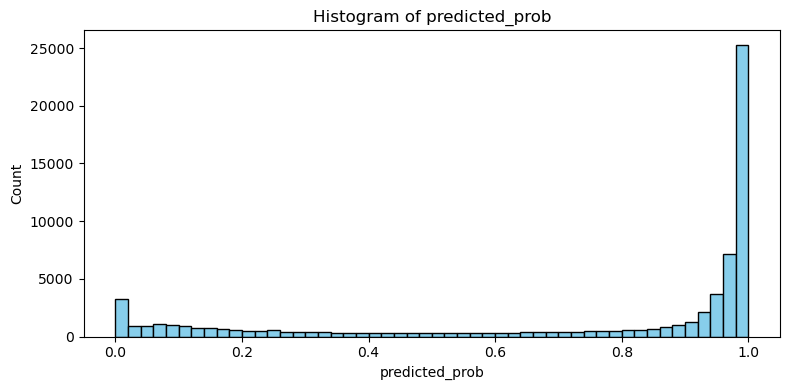

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(merged_data_for_plot['predicted_prob'].dropna(), bins=50, color='skyblue', edgecolor='k')
plt.xlabel('predicted_prob')
plt.ylabel('Count')
plt.title('Histogram of predicted_prob')
plt.tight_layout()
plt.show()

In [16]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO



us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

# 2. 读取DEM并设置CRS（如果缺失）
dem = rioxarray.open_rasterio(r'figure\draw_shp\DEM.nc', masked=True)

# 检查DEM的CRS，如果缺失则手动设置
if dem.rio.crs is None:
    # 根据DEM数据的坐标范围判断，通常全球DEM使用EPSG:4326
    print("DEM CRS缺失，设置为EPSG:4326")
    dem = dem.rio.write_crs("EPSG:4326")

# 3. 确保US nation的CRS与DEM一致
if us_nation.crs != dem.rio.crs:
    print(f"转换US nation CRS从 {us_nation.crs} 到 {dem.rio.crs}")
    us_nation = us_nation.to_crs(dem.rio.crs)



# 4. 用us_nation精确裁剪DEM
print("开始裁剪DEM（使用us_nation）...")
dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
print("DEM裁剪完成！")





DEM CRS缺失，设置为EPSG:4326
转换US nation CRS从 EPSG:4269 到 EPSG:4326
开始裁剪DEM（使用us_nation）...
DEM裁剪完成！


C:\Users\zpy10\AppData\Local\Temp\ipykernel_26972\3951804480.py:151: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(


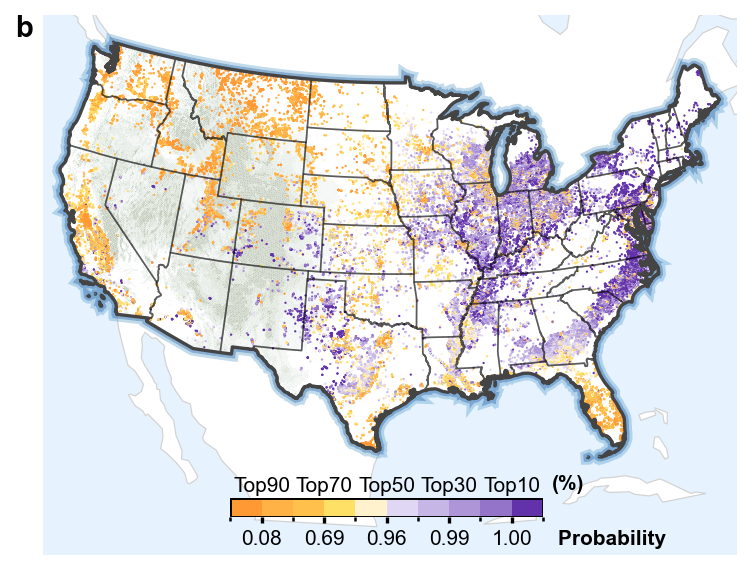

C:\Users\zpy10\AppData\Local\Temp\ipykernel_26972\3951804480.py:151: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(


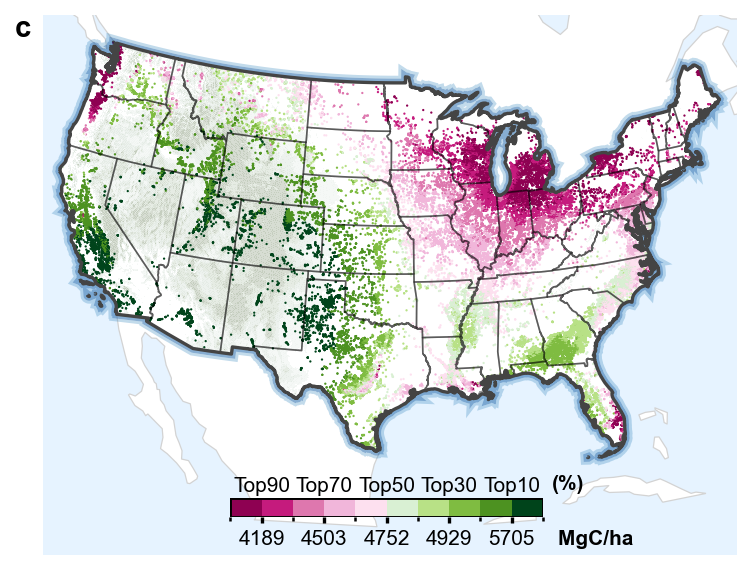

C:\Users\zpy10\AppData\Local\Temp\ipykernel_26972\3951804480.py:151: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(


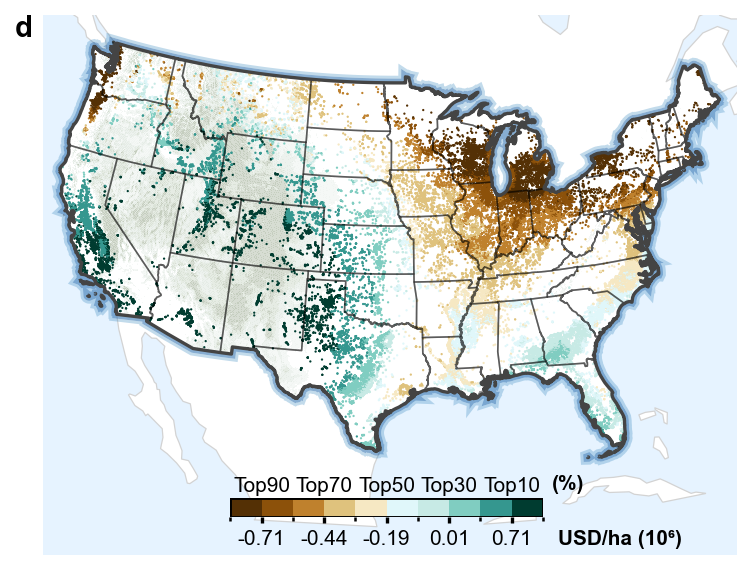

所有图片生成完成！


In [146]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.ops import unary_union
try:
    from shapely import make_valid
except Exception:
    make_valid = None
import matplotlib as mpl


def plot_single_variable_nature_style(
    merged_data_for_plot, 
    us_states_gdf, 
    dem_data, 
    variable_name,
    title=None, 
    unit=None, 
    colors=None, 
    cmap_type='sequential',
    add_north_arrow_and_scalebar=True,
    add_embedding_points=False  
):

    # Set default font, all font size 7
    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, 
        "ps.fonttype": 42,
        "axes.linewidth": 0.5, 
        "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript",
        "ps.distiller.res": 6000,
    })

    # 88mm ≈ 3.46 inches; height set for aspect ratio ~1.6:1
    fig, ax = plt.subplots(1, 1, figsize=(2.36, 2))  # 60mm ≈ 2.36 inches
    
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    ax.set_autoscale_on(False)
    ax.set_facecolor('none')


    # xmin, ymin, xmax, ymax = us_states_albers.total_bounds
    # mx, my = (xmax - xmin) * 0.08, (ymax - ymin) * 0.08
    # # 增大上下边距，观察地图变化
    # ax.set_xlim(xmin - mx, xmax + mx)
    # ax.set_ylim(ymin - my*3, ymax + my*1)



    xmin, ymin, xmax, ymax = us_states_albers.total_bounds

    # 采用6.4文件的边界计算方式
    margin_x_left = (xmax - xmin) * 0.0
    margin_x_right = (xmax - xmin) * -0.02 
    margin_y = (ymax - ymin) * 0.08

    # 调整边界
    xmin = xmin - margin_x_left
    xmax = xmax + margin_x_right
    ymin = ymin - margin_y
    ymax = ymax + margin_y - margin_y * 0.3

    # 关键：画布比例调整，确保地理数据不被拉伸
    fig_width, fig_height = fig.get_size_inches()
    aspect_ratio = fig_width / fig_height
    data_width = xmax - xmin
    data_height = ymax - ymin
    data_aspect = data_width / data_height

    if data_aspect > aspect_ratio:
        center_y = (ymin + ymax) / 2
        new_height = data_width / aspect_ratio
        ymin = (center_y - new_height / 2) * 1.1
        ymax = (center_y + new_height / 2) * 1.1
    else:
        center_x = (xmin + xmax) / 2
        new_width = data_height * aspect_ratio
        xmin = (center_x - new_width / 2 ) * 0.9
        xmax = (center_x + new_width / 2) * 0.9


    ax.set_position([0.0, 0.05, 1, 0.9])
    ax.set_xlim(xmin*1.05, xmax*1.1)
    ax.set_ylim(ymin, ymax*0.8)
    
    # 处理国界线
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')
    
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    
    # 转换坐标
    x_proj, y_proj = transformer.transform(merged_data_for_plot['lon'].values, 
                                          merged_data_for_plot['lat'].values)

    # --- Subtle terrain + hillshade ---
    qm = None
    dem_lon = dem_data.x.values
    dem_lat = dem_data.y.values
    lon_mask = (dem_lon >= usa_bounds_main['lon_min']) & (dem_lon <= usa_bounds_main['lon_max'])
    lat_mask = (dem_lat >= usa_bounds_main['lat_min']) & (dem_lat <= usa_bounds_main['lat_max'])
    if lon_mask.any() and lat_mask.any():
        lon_idx = np.where(lon_mask)[0]
        lat_idx = np.where(lat_mask)[0]
        # 抽稀栅格，避免超大数组
        step_x = max(1, len(lon_idx)//1800)
        step_y = max(1, len(lat_idx)//900)
        lon_sub = lon_idx[::step_x]
        lat_sub = lat_idx[::step_y]
        elev = dem_data.squeeze().values[np.ix_(lat_sub, lon_sub)]

        # 用 35 分位截断低海拔，以增强地形层次但不干扰散点
        mask = ~np.isnan(elev)
        if mask.any():
            lo = np.nanpercentile(elev, 35)
            elev[elev < lo] = np.nan

            # hillshade
            def hillshade(z, azimuth=315, altitude=45):
                zf = np.where(np.isnan(z), np.nanmedian(z), z)
                dy, dx = np.gradient(zf)
                slope = np.arctan(np.hypot(dx, dy))
                aspect = np.arctan2(-dx, dy)
                az, alt = np.radians(azimuth), np.radians(altitude)
                hs = (np.sin(alt)*np.sin(slope) +
                      np.cos(alt)*np.cos(slope)*np.cos(az - aspect))
                return (hs + 1)/2

            hs = hillshade(elev, 315, 45)

            # 低饱和度地形配色（明度为主）
            terrain_colors = ListedColormap(["#ffffff", "#eef3ef", "#dfe8e0",
                                             "#d2ddcf", "#c7d1c1", "#b7c2af"])
            terrain_colors.set_bad((0, 0, 0, 0))
            qs = np.nanpercentile(elev, [35, 50, 65, 78, 88, 98])
            norm = BoundaryNorm(qs, terrain_colors.N)

            lon_grid, lat_grid = np.meshgrid(dem_lon[lon_sub], dem_lat[lat_sub])
            gx, gy = transformer.transform(lon_grid, lat_grid)            
            qm = ax.pcolormesh(
                gx, gy, elev,
                cmap=terrain_colors, norm=norm,
                shading='auto', alpha=0.55,
                antialiased=False,         
                zorder=1
            )
            qm.set_clip_on(True)


    def draw_glow_outline_outside(
        ax, gdf_albers,
        line_color="#002244", line_width=1.3,
        widths_km=(20, 15, 10),                  
        alphas=(0.60, 0.35, 0.18),              
        colors=("#08306b", "#2171b5", "#6baed6"),
        join_style=2, cap_style=2,
        z_glow_base=8.2, z_line=9.6
    ):
        """
        仅在面几何外侧画渐变光晕：对 polygon 做 concentric buffer ring。
        gdf_albers: 已经在 ESRI:102003 (meters)
        """
        g = gdf_albers.copy()
        geom = unary_union(g.geometry)
        
        # 在函数内部定义make_valid
        try:
            from shapely.validation import make_valid   
        except Exception:
            try:
                from shapely import make_valid         
            except Exception:
                make_valid = lambda g: g.buffer(0)
        
        if make_valid is not None:
            geom = make_valid(geom)
        else:
            geom = geom.buffer(0)

        radii_m = [k*1000.0 for k in widths_km]
        ordered = list(zip(radii_m, alphas, colors))
        ordered.sort(key=lambda x: x[0])  # 按距离排序

        last_inner = geom.buffer(0, join_style=join_style, cap_style=cap_style)
        glow_meshes = []  # 存储发光效果mesh对象
        
        for i, (r, alpha, color) in enumerate(ordered):
            outer = geom.buffer(r, join_style=join_style, cap_style=cap_style)
            ring = outer.difference(last_inner)
            if not ring.is_empty:
                glow_series = gpd.GeoSeries([ring], crs=g.crs)
                glow_mesh = glow_series.plot(
                    ax=ax, color=color, alpha=alpha, edgecolor="none",
                    zorder=z_glow_base + i*0.01
                )

                glow_meshes.append(glow_mesh)
            last_inner = outer

        g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=z_line)
        return glow_meshes

    draw_glow_outline_outside(
        ax, us_nation_albers,
        line_color="#444444", line_width=0.8,
        widths_km=(0, 30, 50),                     
        alphas=(0.95, 0.5, 0.3),                  
         colors=("#08336e", "#105ca4", "#3888c0")    
    )

    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)
    # us_nation_albers.plot(ax=ax, color='none', edgecolor='#444444', linewidth=0.5, alpha=0.95, zorder=9)

    # 去掉坐标轴和刻度
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # 去掉数据框线
    for spine in ax.spines.values():
        spine.set_visible(False)
        # 设置背景色
    ax.set_facecolor('#e6f3ff')
    fig.patch.set_facecolor('white')

        # ---------- Base background + land ----------
    try:
        # 1) 读入并统一到经纬度，并在bbox基础上各方向扩展3度
        bbox_expanded = box(
            usa_bounds_main['lon_min'] - 3, usa_bounds_main['lat_min'] - 3,
            usa_bounds_main['lon_max'] + 3, usa_bounds_main['lat_max'] + 3
        )
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp').to_crs(4326)
        helper_gdf = helper_gdf.clip(bbox_expanded)
        if 'featurecla' in helper_gdf.columns:
            helper_gdf = helper_gdf[helper_gdf['featurecla'].str.contains('Land', na=False)]
        try:
            from shapely.validation import make_valid   
        except Exception:
            try:
                from shapely import make_valid         
            except Exception:
                make_valid = lambda g: g.buffer(0)

        helper_gdf['geometry'] = helper_gdf.geometry.map(make_valid)
        helper_gdf = helper_gdf[helper_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
        helper_gdf = helper_gdf.explode(index_parts=False, ignore_index=True)
        helper_gdf_proj = helper_gdf.to_crs('ESRI:102003')
        helper_gdf_proj['geometry'] = helper_gdf_proj.buffer(0)
        helper_gdf_proj.plot(
            ax=ax, facecolor='white', edgecolor='lightgray',
            linewidth=0.3, alpha=1, zorder=0.5
        )
    except Exception as e:
        print(f"Helper map error: {e}")
    # 获取变量数据
    var_values = np.round(np.asarray(merged_data_for_plot[variable_name].values, dtype=float), 3)
    var_bins = np.nanpercentile(var_values, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    cmap = LinearSegmentedColormap.from_list(f"{variable_name}_cmap", colors, N=11)
    norm = BoundaryNorm(var_bins, ncolors=cmap.N)
    scatter = ax.scatter(
        x_proj, y_proj, c=var_values, cmap=cmap, norm=norm,
        s=0.3, alpha=1, edgecolors='none', zorder=5
    )
    from matplotlib import transforms as mtransforms

    def add_horizontal_cbar_equiv(fig, ax, mappable, var_bins, unit_display=None):
        # 复现：width=45%, height=3.5%, 相对主轴偏移 (0.20, 0.02)
        pos = ax.get_position()  # figure 坐标的 Bbox（0-1 范围）
        left   = pos.x0 + 0.27 * pos.width
        bottom = pos.y0 + 0.07 * pos.height
        width  = 0.45 * pos.width
        height = 0.035 * pos.height

        cax = fig.add_axes([left, bottom, width, height])
        cax.set_in_layout(False)
        cax.set_zorder(50)  
        cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')

        cb.set_ticks(var_bins[1::2])

        # 生成自定义刻度文本
        tick_vals = var_bins[1::2]
        # ——按变量类型格式化：
        if variable_name == 'net_npv_usd':
            tick_labels = [f'{v/1_000_000:.2f}' for v in tick_vals]
        elif variable_name == 'predicted_prob':
            tick_labels = [f'{v:.2f}' for v in tick_vals]
        elif variable_name == 'Expectation_net_benefit':
            tick_labels = [f'{v/1_000:.2f}' for v in tick_vals]
        else:
            tick_labels = [f'{v:.0f}' for v in tick_vals]
        cb.set_ticklabels(tick_labels)

        # 轴观感
        cax.tick_params(axis='x', which='major', length=1.5, width=0.8, pad=1.5, labelsize=5)
        cax.tick_params(axis='x', which='minor', length=1, width=0.6, label1On=False)
        cb.outline.set_linewidth(0.7)

        percentile_labels = [f'Top{p}' for p in range(10, 101, 20)][::-1]
        major_tick_locs = cb.get_ticks()
        for loc, label in zip(major_tick_locs, percentile_labels):
            x_disp = cax.transData.transform((loc, 0))[0]
            x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
            cax.text(x_frac, 1.1, label, transform=cax.transAxes,
                     ha='center', va='bottom', fontsize=5,  clip_on=False)
        cax.text(1.08, 1.23, "(%)", ha='center', va='bottom', fontsize=5, 
                     fontweight='bold', transform=cax.transAxes)

        # # 右侧单位（放在轴内一点点，避免越界），并 clip
        # if unit_display:
        #     cax.text(1.02, 0.5, unit_display, transform=cax.transAxes,
        #              ha='left', va='center', fontsize=5, fontweight='bold', clip_on=True)

        for ch in cax.get_children():
            try:
                ch.set_clip_path(cax.patch)
            except Exception:
                pass

        return cax, cb





    # # 添加颜色条（位置略上移）
    # cbar_ax = inset_axes(ax, width="50%", height="3.5%",
    #                      loc='lower left',
    #                      bbox_to_anchor=(0.2, 0.02, 1, 1),  
    #                      bbox_transform=ax.transAxes, borderpad=1)
    # cbar_ax.set_in_layout(False)
    # cbar = plt.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
    # cbar.set_ticks(var_bins[1::2])
    
    # # 格式化刻度标签
    # if variable_name == 'net_npv_usd':
    #     tick_labels = [f'{v/1000000:.2f}' for v in var_bins[1::2]]
    # elif variable_name == 'predicted_prob':
    #     tick_labels = [f'{v:.2f}' for v in var_bins[1::2]]
    # elif variable_name == 'Expectation_net_benefit':
    #     tick_labels = [f'{v/1000:.2f}' for v in var_bins[1::2]]
    # else:
    #     tick_labels = [f'{v:.0f}' for v in var_bins[1::2]]

    # cbar.set_ticklabels(tick_labels)
    # cbar.ax.tick_params(axis='x', which='major', length=1.5, width=0.8, pad=1.5, labelsize=5)
    # cbar.ax.tick_params(axis='x', which='minor', length=1, width=0.6, label1On=False)
    # cbar.outline.set_linewidth(0.5)
    
    # # 添加"Priority"标签和单位标签
    # cbar_ax.text(1.1, 1.5, "(%)", ha='center', va='bottom', fontsize=5, fontweight='bold', transform=cbar_ax.transAxes)
    # # 添加百分位数标签，采用Top 10%, Top 30%, Top 50%, Top 70%, Top 90%，并逆序
    # percentile_labels = [f'Top{p}' for p in range(10, 101, 20)][::-1]
    # major_tick_locs = cbar.get_ticks()
    # for i, (loc, label) in enumerate(zip(major_tick_locs, percentile_labels)):
    #     x_pos = cbar_ax.transData.transform((loc, 0))[0]
    #     x_frac = cbar_ax.transAxes.inverted().transform((x_pos, 0))[0] 
    #     cbar_ax.text(x_frac, 2.2, label, transform=cbar_ax.transAxes, 
    #                  ha='center', va='top', fontsize=5)


    # 控制单位标签的位置 
    if variable_name == 'net_npv_usd':
        unit_display = f'{unit} (10⁶)'
    elif variable_name == 'Expectation_net_benefit':
        unit_display = f'{unit} (10³)'
    else:
        unit_display = f'{unit} '

    cbar_ax, cbar = add_horizontal_cbar_equiv(fig, ax, scatter, var_bins, unit_display)
    cbar_ax.text(1.05, -0.7, unit_display, ha='left', va='top', fontsize=5, 
                fontweight='bold', transform=cbar_ax.transAxes)


    fig.canvas.draw()          
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)

    return fig, ax

# 定义三个变量的参数
variables_config = [
    {
        'name': 'predicted_prob',
        'title': 'Environmental Potential',
        'unit': 'Probability',
        # 渐变色：紫色渐变 (11 categories)
        'colors': [
            '#ff9933','#ffb347' ,'#ffc04c', '#ffe066',  '#fff2cc',
            '#e0d7f5','#c6b6e6','#ad95d7','#9474c8','#7b53b9','#6232aa'
        ],
        'filename': 'environmental score'
    },
    {
        'name': 'Expectation_net_benefit_adjust', 
        'title': 'Carbon Mitigation Potential',
        'unit': 'MgC/ha ',
        # 渐变色：红 -> 绿色 -> 深绿色 (right: 11 categories)
        'colors': [
            '#8e0152', '#c51b7d', '#de77ae', '#f1b6da', '#fde0ef',
            '#d9f0d3', '#b8e186', '#7fbc41', '#4d9221', '#276419', '#00441b'
        ],
        'filename': 'carbon_mitigation_potential'
    },
    {
        'name': 'net_npv_usd',
        'title': 'Economic Potential', 
        'unit': 'USD/ha',
        # 经济潜力色带：11色渐变
        'colors': [
            '#543005', '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
            '#e0f7fa', '#c7eae5', '#80cdc1', '#35978f', '#01665e', '#003c30'
        ],
        'filename': 'economic_potential'
    }
]

# 生成三个单独的图
panel_labels = ['b', 'c', 'd']


for i, var_config in enumerate(variables_config):
    try:
        add_north_arrow_and_scalebar = (i == 0)
        add_embedding_points = False

        fig, ax = plot_single_variable_nature_style(
            merged_data_for_plot, 
            us_states_4326, 
            dem_us,
            var_config['name'],
            var_config['title'],
            var_config['unit'],
            var_config['colors'],
            add_north_arrow_and_scalebar=add_north_arrow_and_scalebar,
            add_embedding_points=add_embedding_points
        )

        ax.text(-0.04, 1, panel_labels[i], transform=ax.transAxes,
                ha='left', va='top', fontsize=7, fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

        # 统一先定义文件名
        filename_png = f"figure/US_figure/{var_config['filename']}_nature_style_300dpi.png"
        filename_pdf = f"figure/US_figure/{var_config['filename']}_nature_style_300dpi.pdf"
        # fig.set_size_inches(2.36, 1.9)
        fig.savefig(filename_png, dpi=300, facecolor='White')  
        fig.canvas.draw()
        fig.savefig(filename_pdf, dpi=300, facecolor='None')                       

        plt.show()
        plt.close(fig)

    except Exception as e:
        print(e)
        continue




print("所有图片生成完成！")

# 二、环境适宜性建模图（有部分在3.0 pretraining中）

#### Load data and plot

In [147]:
import geopandas as gpd
from shapely.geometry import Point
from function import *

us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')
us_argscv = gpd.read_file("figure/draw_shp/ASD_2012_5m.shp")


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')
us_argscv_4326 = us_argscv.to_crs('EPSG:4326')

def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

# ---------------------------
# 0) 基础地理范围与底图
# ---------------------------
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
# ---------------------------
# 1) 读取数据
# ---------------------------
df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)
df_abandon_filtered=df_abandon_filtered.merge(df_net_benefit[['lon', 'lat', 'area_m2']], on=['lat', 'lon'], how='left')


You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值


弃光面积统计: 最小值=0.00 ha, 最大值=160611.20 ha
分位数边界: [ 2076.59725569  5168.38676264 11699.28293452 25224.746894
 47669.65946998]
开始聚合embedding点，总数: 10152
地理区划聚合结果: 312个区划
包含embedding点的区划数: 236
Embedding点数量分布: 最小0.0, 最大1113.0
气泡分类统计:
  >1000点: 3个区划 (深绿色, 500)
  800-1000点: 0个区划 (绿色, 350)
  100-800点: 18个区划 (浅绿色, 200)
  50-100点: 13个区划 (浅蓝色, 120)
  10-50点: 63个区划 (蓝色, 60)
  <10点: 215个区划（不绘制）
Embedding点聚合完成: 原始10152个点 → 312个地理区划


C:\Users\zpy10\AppData\Local\Temp\ipykernel_55620\522205488.py:320: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


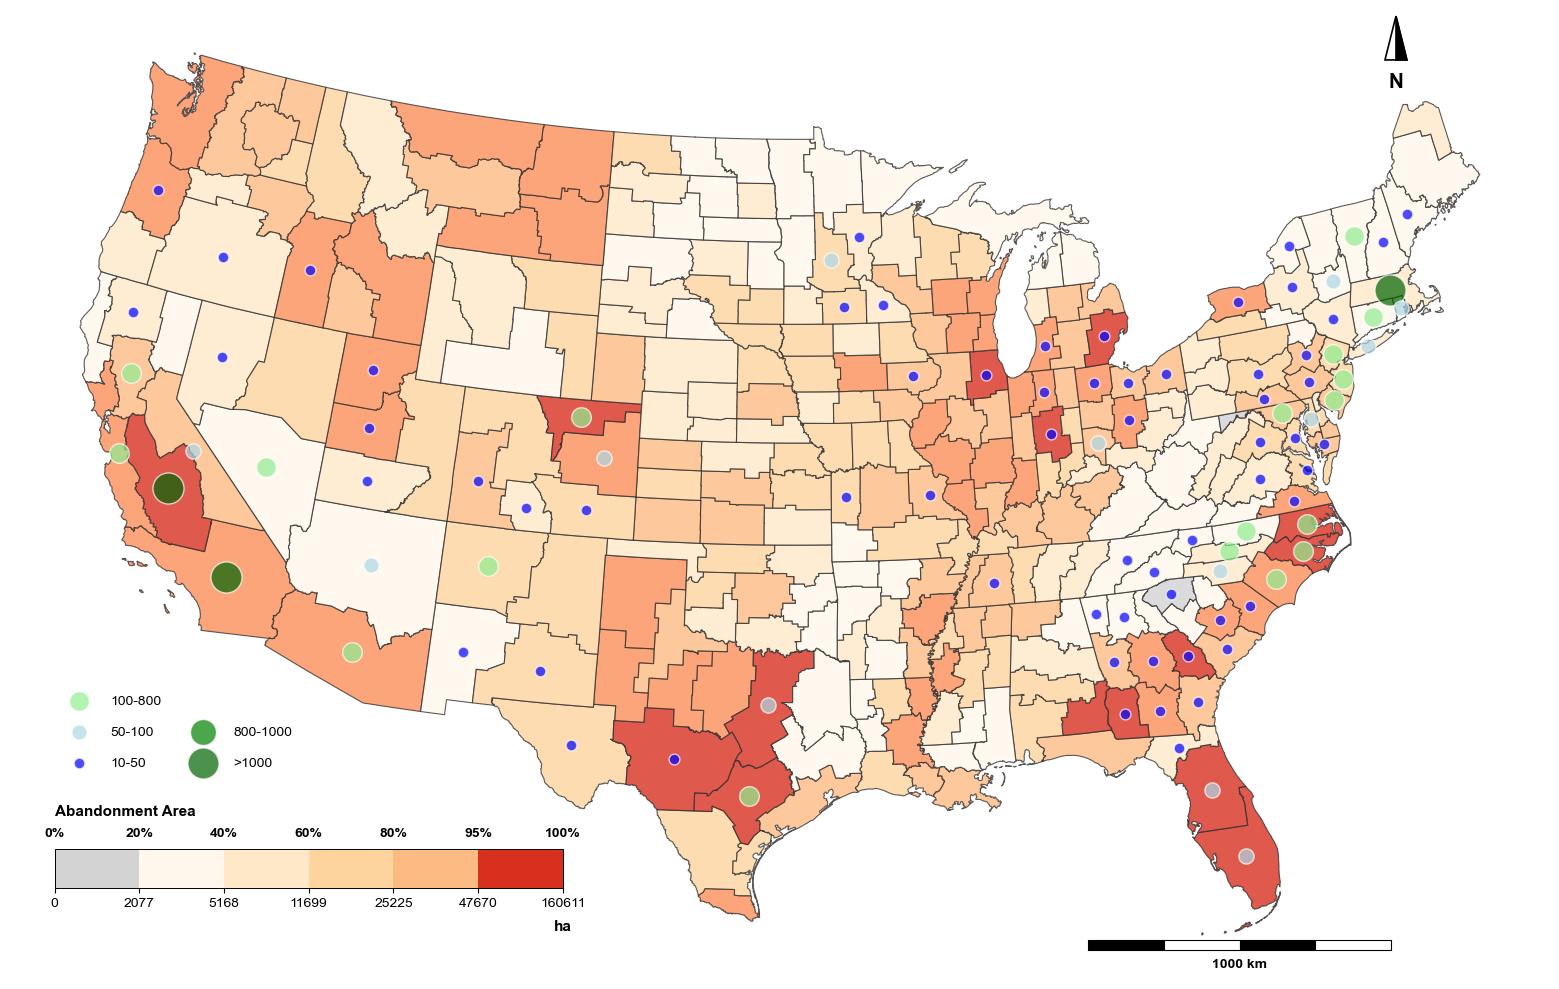

图片生成完成！


In [148]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import geopandas as gpd
from shapely.geometry import box
from pyproj import Transformer

def plot_smaplesites_nature_style(
    df_abandon_filtered, 
    us_counties_4326, 
    df_pv_embedding,
    add_north_arrow_and_scalebar=True,
    add_embedding_points=False  
):
    """
    参数:
        df_abandon_filtered: DataFrame，包含要绘制的撂荒点，必须包含'lat'、'lon'和'area_m2'列
        us_counties_4326: GeoDataFrame，美国各县边界
        df_pv_embedding: DataFrame，包含要绘制的embedding数据，必须包含'lat'和'lon'列
        add_north_arrow_and_scalebar: bool, 是否添加指北针和比例尺
        add_embedding_points: bool, 是否绘制embedding点

        按照county聚合df_abandon_filtered的面积，然后以分位数划分绘制
        以气泡聚合的形式绘制df_pv_embedding的点
    """
    plt.rcParams['font.family'] = 'Arial'
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    for spine in ax.spines.values():
        spine.set_visible(False)
        spine.set_edgecolor('none')
        spine.set_alpha(0)
    # 去掉地图外面的经纬度标注
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    us_counties_bound = us_counties_4326.to_crs(epsg=4326).clip(bbox)
    us_counties_albers = us_counties_bound.to_crs('ESRI:102003')
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)

    # 绘制df_abandon_filtered的面积在county上的聚合
    # 1. 先将弃光点转为GeoDataFrame
    gdf_abandon = gpd.GeoDataFrame(
        df_abandon_filtered,
        geometry=gpd.points_from_xy(df_abandon_filtered['lon'], df_abandon_filtered['lat']),
        crs='EPSG:4326'
    )
    # 2. 投影到Albers
    gdf_abandon = gdf_abandon.to_crs('ESRI:102003')
    # 3. 空间连接到county，统计每个county的弃光面积总和
    county_abandon_area = gpd.sjoin(
        gdf_abandon, us_counties_albers, how='left', predicate='within'
    ).groupby('index_right')['area_m2'].sum()
    # 4. 合并回county GeoDataFrame
    us_counties_albers['abandon_area_ha'] = county_abandon_area / 10000  # 转换为公顷
    us_counties_albers['abandon_area_ha'] = us_counties_albers['abandon_area_ha'].fillna(0)

    # 5. 绘制底图（county边界，弃光面积用分位数划分）
    # 计算分位数边界
    area_values = us_counties_albers['abandon_area_ha'].values
    area_quantiles = np.percentile(area_values[area_values > 0], [20, 40, 60, 80, 95])  # 排除0值计算分位数
    
    # 创建分位数分类
    def classify_area(area):
        if area == 0:
            return 0  # 无弃光
        elif area <= area_quantiles[0]:
            return 1  # 0-20%分位数
        elif area <= area_quantiles[1]:
            return 2  # 20-40%分位数
        elif area <= area_quantiles[2]:
            return 3  # 40-60%分位数
        elif area <= area_quantiles[3]:
            return 4  # 60-80%分位数
        elif area <= area_quantiles[4]:
            return 5  # 80-95%分位数
        else:
            return 6  # 95-100%分位数
    
    us_counties_albers['area_class'] = us_counties_albers['abandon_area_ha'].apply(classify_area)
    
    print(f"弃光面积统计: 最小值={area_values.min():.2f} ha, 最大值={area_values.max():.2f} ha")
    print(f"分位数边界: {area_quantiles}")
    
    # 创建自定义颜色映射：灰色到YlOrRd
    colors = ['#D3D3D3', '#fff7ec', '#fee8c8', '#fdd49e', '#fdbb84', '#fc8d59', '#d7301f']
    custom_cmap = ListedColormap(colors)
    
    # 绘制county聚合的弃光面积
    plot_result = us_counties_albers.plot(
        ax=ax,
        column='area_class',
        cmap=custom_cmap,
        linewidth=0.8,
        edgecolor='#333333',
        alpha=0.8,
        zorder=2,
        legend=False
    )

    # 6. 绘制embedding点（气泡聚合）
    # 记录气泡图例信息
    legend_bubbles = []
    if add_embedding_points and (df_pv_embedding is not None):
        print(f"开始聚合embedding点，总数: {len(df_pv_embedding)}")
        
        # 使用us_argscv_4326的地理区划进行聚合
        # 1. 先将embedding点转为GeoDataFrame
        gdf_embedding = gpd.GeoDataFrame(
            df_pv_embedding,
            geometry=gpd.points_from_xy(df_pv_embedding['lon'], df_pv_embedding['lat']),
            crs='EPSG:4326'
        )
        
        # 2. 投影到Albers
        gdf_embedding = gdf_embedding.to_crs('ESRI:102003')
        
        # 3. 空间连接到地理区划，统计每个区划内的点数
        us_argscv_albers = us_argscv_4326.to_crs('ESRI:102003')
        district_embedding_count = gpd.sjoin(
            gdf_embedding, us_argscv_albers, how='left', predicate='within'
        ).groupby('index_right').size()
        us_argscv_albers['embedding_count'] = district_embedding_count
        us_argscv_albers['embedding_count'] = us_argscv_albers['embedding_count'].fillna(0)
        
        print(f"地理区划聚合结果: {len(us_argscv_albers)}个区划")
        print(f"包含embedding点的区划数: {(us_argscv_albers['embedding_count'] > 0).sum()}")
        print(f"Embedding点数量分布: 最小{us_argscv_albers['embedding_count'].min()}, 最大{us_argscv_albers['embedding_count'].max()}")
        
        # 5. 根据区划内点数分类并设置气泡大小和颜色
        def classify_district_size(count):
            if count > 1000:
                return 500, 'darkgreen', '>1000'
            elif count > 800:
                return 350, 'green', '800-1000'
            elif count > 100:
                return 200, 'lightgreen', '100-800'
            elif count > 50:
                return 120, 'lightblue', '50-100'
            elif count > 10:
                return 60, 'blue', '10-50'
            else:
                return 0, 'none', None
        
        # 6. 绘制气泡
        for idx, row in us_argscv_albers.iterrows():
            count = row['embedding_count']
            if count > 10:
                center = row.geometry.centroid
                center_x, center_y = center.x, center.y
                bubble_size, bubble_color, bubble_label = classify_district_size(count)
                if bubble_label and bubble_label not in [b[2] for b in legend_bubbles]:
                    legend_bubbles.append((bubble_size, bubble_color, bubble_label))
                    ax.scatter(
                        center_x, center_y,
                        s=bubble_size,
                        c=bubble_color,
                        marker='o',
                        alpha=0.7,
                        edgecolors='white',
                        linewidth=1.0,
                        zorder=6,
                        label=bubble_label
                    )
                else:
                    ax.scatter(
                        center_x, center_y,
                        s=bubble_size,
                        c=bubble_color,
                        marker='o',
                        alpha=0.7,
                        edgecolors='white',
                        linewidth=1.0,
                        zorder=6
                    )
        
        # 统计各类气泡的数量
        district_sizes = us_argscv_albers['embedding_count'].values
        large_districts = np.sum(district_sizes > 1000)
        medium_large_districts = np.sum((district_sizes > 800) & (district_sizes <= 1000))
        medium_districts = np.sum((district_sizes > 100) & (district_sizes <= 800))
        medium_small_districts = np.sum((district_sizes > 50) & (district_sizes <= 100))
        small_districts = np.sum((district_sizes > 10) & (district_sizes <= 50))
        
        print(f"气泡分类统计:")
        print(f"  >1000点: {large_districts}个区划 (深绿色, 500)")
        print(f"  800-1000点: {medium_large_districts}个区划 (绿色, 350)")
        print(f"  100-800点: {medium_districts}个区划 (浅绿色, 200)")
        print(f"  50-100点: {medium_small_districts}个区划 (浅蓝色, 120)")
        print(f"  10-50点: {small_districts}个区划 (蓝色, 60)")
        print(f"  <10点: {np.sum(district_sizes <= 10)}个区划（不绘制）")
        
        print(f"Embedding点聚合完成: 原始{len(df_pv_embedding)}个点 → {len(us_argscv_albers)}个地理区划")

        # 7. 手动添加df_abandon的colorbar（分位数分类）
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    # 创建colorbar轴
    cbar_ax = inset_axes(ax, width="33%", height="4%",
                       loc='lower left',
                       bbox_to_anchor=(0.02, 0.08, 1, 1),
                       bbox_transform=ax.transAxes, borderpad=1)
    
    # 创建colorbar
    from matplotlib.cm import ScalarMappable
    norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6], custom_cmap.N)
    sm = ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_ticks([0, 1, 2, 3, 4, 5, 6])
    
    area_labels = []
    area_labels.append('0')
    area_labels.append(f'{area_quantiles[0]:.0f}')
    area_labels.append(f'{area_quantiles[1]:.0f}')
    area_labels.append(f'{area_quantiles[2]:.0f}')
    area_labels.append(f'{area_quantiles[3]:.0f}')
    area_labels.append(f'{area_quantiles[4]:.0f}')
    area_labels.append(f'{area_values.max():.0f}')
    cbar.set_ticklabels(area_labels)
    cbar.ax.tick_params(labelsize=10)
    cbar.outline.set_linewidth(0.7)
    cbar_ax.text(0, 1.8, "Abandonment Area", ha='left', va='bottom', fontsize=11, 
                fontweight='bold', transform=cbar_ax.transAxes)
    percentile_labels = ['0%', '20%', '40%', '60%', '80%', '95%', '100%']
    for i, tick_pos in enumerate([0, 1, 2, 3, 4, 5, 6]):
        cbar_ax.text(tick_pos, 1.25, percentile_labels[i],
                     transform=cbar_ax.transData, ha='center', va='bottom',
                     fontsize=10, fontweight='bold')
    cbar_ax.text(6, -0.8, "ha", ha='center', va='top', fontsize=11, 
                fontweight='bold', transform=cbar_ax.transData)

    # 8. 在colorbar上方添加embedding点的图例（2列，>1000和800-1000在右下，50-100和10-50左对齐，100-800居中，底部对齐）
    if add_embedding_points and (df_pv_embedding is not None):
        legend_ax = inset_axes(ax, width="20%", height="32%",
                              loc='lower left',
                              bbox_to_anchor=(0.02, 0.16, 1, 1),
                              bbox_transform=ax.transAxes, borderpad=1)
        legend_ax.set_xticks([])
        legend_ax.set_yticks([])
        for spine in legend_ax.spines.values():
            spine.set_visible(False)
        legend_ax.set_facecolor('none')
        # 图例项参数
        # 2列布局，左列：100-800, 50-100, 10-50；右列：>1000, 800-1000
        # 让>1000和800-1000在右下，且与50-100/10-50底部对齐
        # y坐标从上到下，左列：100-800, 50-100, 10-50；右列：>1000, 800-1000
        # 右列的y与左列的50-100和10-50对齐
        # 100-800居中
        # 具体坐标如下
        # 左列x=0.08，右列x=0.48
        # y_100_800 = 0.85
        # y_50_100 = 0.55
        # y_10_50 = 0.32
        # y_800_1000 = 0.55
        # y_>1000 = 0.32
        # 这样>1000和800-1000与50-100和10-50底部对齐
        # 100-800居中
        legend_items = [
            # (size, color, label, x, y)
            (200, 'lightgreen', '100-800', 0.08, 0.35),
            (120, 'lightblue', '50-100', 0.08, 0.25),
            (60, 'blue', '10-50', 0.08, 0.15),
            (350, 'green', '800-1000', 0.48, 0.25),
            (500, 'darkgreen', '>1000', 0.48, 0.15),
        ]
        for size, color, label, x, y in legend_items:
            legend_ax.scatter(x, y, s=size, c=color, marker='o', alpha=0.7,
                             edgecolors='white', linewidth=1.0, zorder=10, transform=legend_ax.transAxes)
            legend_ax.text(x+0.10, y, label, ha='left', va='center', fontsize=10, color='black',
                          fontweight='normal', transform=legend_ax.transAxes)

    # 指北针和比例尺
    def add_nature_north_arrow(ax, size=0.04):
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        dx, dy = x1 - x0, y1 - y0
        desired_size = 0.045
        h = desired_size * dy
        w = h * 0.5
        cx = x0 + 0.9 * dx
        cy = y0 + 0.97 * dy
        coords = [[cx, cy + h / 2], [cx - w / 2, cy - h / 2], [cx + w / 2, cy - h / 2]]
        ax.add_patch(mpatches.Polygon(coords, closed=True, facecolor="white", 
                                     edgecolor="black", lw=1.2, zorder=20))
        ax.add_patch(mpatches.Polygon([[cx, cy + h / 2], [cx, cy - h / 2], [cx + w / 2, cy - h / 2]],
                                     closed=True, facecolor="black", edgecolor="black", lw=1.2, zorder=21))
        ax.text(cx, cy - h * 1.0, 'N', ha='center', va='center',
               fontsize=15, fontweight='bold', color='black', zorder=22)

    def add_nature_scalebar(ax, length_km=1000):
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        dx, dy = x1 - x0, y1 - y0
        bar_x = x0 + 0.70*dx
        bar_y = y0 + 0.03*dy
        bar_height = 0.01*dy
        bar_length = length_km * 1000
        n_segments = 4
        seg_len = bar_length / n_segments
        for i in range(n_segments):
            color = "black" if i % 2 == 0 else "white"
            ax.add_patch(mpatches.Rectangle((bar_x + i*seg_len, bar_y),
                                          seg_len, bar_height,
                                          facecolor=color, edgecolor="black", lw=0.8, zorder=30))
        ax.text(bar_x + bar_length/2, bar_y - 0.008*dy,
               f"{length_km} km", ha="center", va="top",
               fontsize=10, fontweight='bold', color='black', zorder=31)

    if add_north_arrow_and_scalebar:
        add_nature_north_arrow(ax, size=0.08)
        add_nature_scalebar(ax, length_km=1000)

    plt.tight_layout()
    return fig, ax

# 只生成一个图，并重命名文件
try:
    fig, ax = plot_smaplesites_nature_style(
        df_abandon_filtered, 
        us_argscv_4326, 
        df_embedding_fill,
        add_north_arrow_and_scalebar=True,
        add_embedding_points=True  # 改为True，显示embedding点
    )
    filename = "figure/US_figure/machinelearning_map_300dpi.png"
    fig.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    plt.close(fig)
except Exception as e:
    print(e)

print("图片生成完成！")

In [149]:
df_embedding_fill

time        lat        lon  abandonment_year  unique_id  \
207   2018-01-01  25.787500 -80.387500            1996.0      34469   
208   2018-01-01  25.795834 -80.387500               NaN      34519   
211   2018-01-01  26.112500 -98.020836               NaN      33917   
212   2018-01-01  26.145834 -97.837500               NaN      34012   
213   2018-01-01  26.145834 -97.829170            2000.0      33985   
...          ...        ...        ...               ...        ...   
24771 2020-01-01  44.620834 -73.120834               NaN      21145   
24795 2020-01-01  44.670834 -74.945830               NaN      20157   
24840 2020-01-01  44.804165 -69.837500               NaN      11877   
24973 2020-01-01  45.462500 -69.312500               NaN      20684   
25162 2020-01-01  46.920834 -67.837500               NaN      20534   

             p_area  capacity_m country  year  abandonment_duration  ...  \
207     3413.769589    0.331533     USA  2018                  28.0  ...   
208     1783.635896    0.173283     USA  2018                   NaN  ...   
211    11585.736350    1.048494     USA  2018                   NaN  ...   
212     3746.567969    0.366137     USA  2018                   NaN  ...   
213     3880.401559    0.379216     USA  2018                  24.0  ...   
...             ...         ...     ...   ...                   ...  ...   
24771   1866.428118    0.000000     USA  2020                   NaN  ...   
24795  50378.901500    3.255628     USA  2020                   NaN  ...   
24840  82831.923240    4.949656     USA  2020                   NaN  ...   
24973    135.812527    0.000000     USA  2020                   NaN  ...   
25162  11087.417570    0.909390     USA  2020                   NaN  ...   

        Population  Powerdist  PrimaryRoad  SecondaryRoad     Slope  \
207       0.288029  622580.56   239.976668     124.925079  0.188917   
208       0.288029  622580.56   239.976668     124.925079  0.415473   
211       5.687756  622574.70    20.141565       9.576520  0.192031   
212     192.709230  622574.70    17.949732      21.429836  0.165108   
213    1551.475000  622574.70    17.949732      21.429836  0.259286   
...            ...        ...          ...            ...       ...   
24771   354.416080  622565.06    44.401291      13.377765  0.318075   
24795    21.342867  622564.44    21.127753      11.209821  0.435633   
24840    48.138603  622565.94    14.078793      17.696589  2.629778   
24973    48.138603  622565.50    14.078793      17.696589  2.185234   
25162    19.535080  622564.56    11.680075      13.916544  1.223846   

       TertiaryRoad       gdmp       rsds          tas      wind  
207     1819.419167  34.016399  17.709135  2979.915296  2.362765  
208     1819.419167  28.652000  17.692776  2979.836073  2.547076  
211      312.681172  77.752000  17.591680  2970.665273  4.070180  
212      203.554745  23.081331  17.417795  2970.248631  4.393748  
213      203.554745  29.595555  17.413290  2970.168037  4.142279  
...             ...        ...        ...          ...       ...  
24771    152.815046  52.505314  13.261620  2803.995797  3.378157  
24795    143.998544  93.881752  13.112454  2800.741708  3.405168  
24840    112.898732  87.605934  13.552799  2793.727888  2.632521  
24973     12.537485  85.419006  12.888320  2775.382529  2.217898  
25162    101.830606  63.442669  12.615384  2769.831798  4.303956  

[10152 rows x 26 columns]

## 2.1 图1回归图

画这张图

In [ ]:
merged_data_for_plot

lat         lon  predicted_prob   gmm_density      sample_type  \
0      25.295834  -80.287500        0.000000  3.874315e+16  negative_sample   
1      25.437500  -80.537500        0.002796  2.054387e+18       prediction   
2      25.437500  -80.495834        0.000000  4.247702e+15  negative_sample   
3      25.445833  -80.454170        0.000000  1.117299e+13  negative_sample   
4      25.445833  -80.404170        0.001190  4.463459e+17       prediction   
...          ...         ...             ...           ...              ...   
64977  48.995834 -111.970830        0.005805  1.493778e+17       prediction   
64978  48.995834 -110.345830        0.009486  4.120084e+17       prediction   
64979  48.995834 -106.020836        0.006799  3.232082e+17       prediction   
64980  48.995834 -104.087500        0.013564  6.627032e+21       prediction   
64981  48.995834 -104.079170        0.019500  6.469832e+18       prediction   

       Expectation_net_benefit    net_npv_usd  
0                  6382.303639  407275.912577  
1                  5690.624063  283953.326746  
2                  6055.300591  275019.106094  
3                  6048.645138  269947.631894  
4                  6081.010322  291620.314126  
...                        ...            ...  
64977              6210.923349 -220868.055076  
64978              6206.053157 -219393.096487  
64979              6204.952188 -205704.827949  
64980              6077.421747 -300314.323514  
64981              6083.031871 -294315.333974  

[64982 rows x 7 columns]

原始数据量: 64982
过滤后数据量: 62444
有效数据点: 62444
GMM density 原始范围: 6.91e-32 - 1.37e+28
Log(GMM density) 范围: -71.75 - 64.79


C:\Users\zpy10\AppData\Local\Temp\ipykernel_46856\2112259918.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


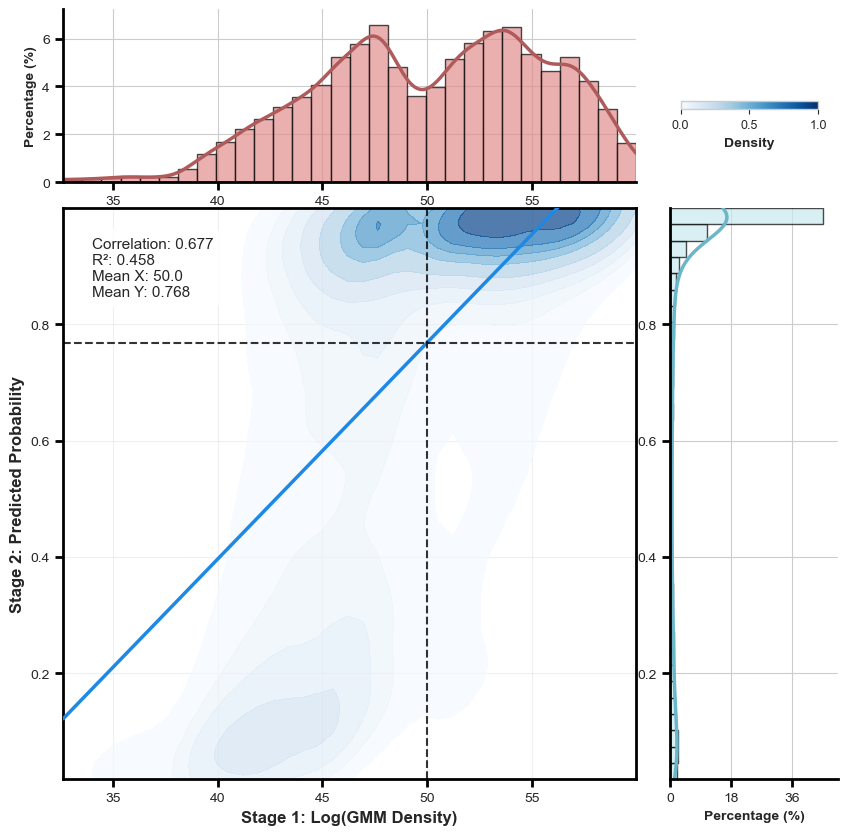

最终优化的联合分布图生成完成！


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def create_joint_distribution_plot_final(merged_data_for_plot):
    """
    创建最终优化的双变量联合分布图
    新增功能：
    1. 增加边际分布和联合分布之间的空隙
    2. 优化右侧边际分布的刻度标签显示
    """
    
    # 设置字体和风格
    plt.rcParams['font.family'] = 'Arial'
    sns.set_style("whitegrid")
    
    # 数据预处理：剔除negative_sample
    filtered_data = merged_data_for_plot[merged_data_for_plot['sample_type'] != 'negative_sample'].copy()
    
    print(f"原始数据量: {len(merged_data_for_plot)}")
    print(f"过滤后数据量: {len(filtered_data)}")
    
    # 创建图形布局 - 增加空隙
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 4, figure=fig, hspace=0.15, wspace=0.20)  
    
    # 主要的联合分布图
    ax_joint = fig.add_subplot(gs[1:4, 0:3])
    
    # 顶部边际分布（x轴）
    ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_joint)
    
    # 右侧边际分布（y轴）
    ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_joint)
    
    # 隐藏子图的标签
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    
    # 获取原始数据
    original_x_data = filtered_data['gmm_density'].values
    y_data = filtered_data['predicted_prob'].values
    
    # 移除NaN值和非正值（对于对数变换）
    mask = ~(np.isnan(original_x_data) | np.isnan(y_data)) & (original_x_data > 0)
    original_x_data = original_x_data[mask]
    y_data = y_data[mask]
    
    # 对GMM density进行对数变换
    x_data = np.log(original_x_data)  
    
    print(f"有效数据点: {len(x_data)}")
    print(f"GMM density 原始范围: {original_x_data.min():.2e} - {original_x_data.max():.2e}")
    print(f"Log(GMM density) 范围: {x_data.min():.2f} - {x_data.max():.2f}")
    
    # 计算均值和统计信息
    x_mean = np.mean(x_data)
    y_mean = np.mean(y_data)
    correlation = np.corrcoef(x_data, y_data)[0, 1]
    
    # 设置数据范围
    x_range = (np.percentile(x_data, 1), np.percentile(x_data, 99))
    y_range = (np.percentile(y_data, 1), np.percentile(y_data, 99))
    
    # 创建包含对数变换数据的临时DataFrame用于seaborn
    temp_df = pd.DataFrame({
        'log_gmm_density': x_data,
        'predicted_prob': y_data
    })
    
    # 1. 绘制联合分布（只保留KDE密度图，移除散点）
    kde_plot = None
    try:
        kde_plot = sns.kdeplot(data=temp_df, x="log_gmm_density", y="predicted_prob", 
                              cmap="Blues", fill=True, ax=ax_joint, alpha=0.7, zorder=2)
    except Exception as e:
        print(f"KDE绘制警告: {e}")
    
    # 添加颜色条到右上角
    try:
        norm1 = plt.Normalize(vmin=0, vmax=1)
        sm1 = plt.cm.ScalarMappable(cmap="Blues", norm=norm1)
        sm1.set_array([])
        
        # 创建颜色条的插入轴，bbox_to_anchor的第一个参数从0.98改为0.88
        axins1 = inset_axes(ax_joint, width="60%", height="15%",
                           bbox_to_anchor=(0.93, 1.1, 0.4, 0.1), 
                           bbox_transform=ax_joint.transAxes)
        
        cbar = plt.colorbar(sm1, cax=axins1, orientation='horizontal')
        cbar.set_label('Density', fontsize=10, fontweight='bold')
        cbar.ax.tick_params(labelsize=9)
        cbar.outline.set_linewidth(1)
        
    except Exception as e:
        print(f"颜色条绘制警告: {e}")
    
    # 添加回归线（使用指定颜色 #1E88E5）
    r_squared = None
    try:
        from sklearn.linear_model import LinearRegression
        
        # 重塑数据用于回归
        X = x_data.reshape(-1, 1)
        y = y_data
        
        # 线性回归
        reg = LinearRegression()
        reg.fit(X, y)
        r_squared = reg.score(X, y)
        
        # 生成回归线数据
        x_line = np.linspace(x_range[0], x_range[1], 100)
        y_line = reg.predict(x_line.reshape(-1, 1))
        
        ax_joint.plot(x_line, y_line, color='#1E88E5', linewidth=2.5, zorder=3)
        
    except Exception as e:
        print(f"回归线绘制警告: {e}")
    
    # 添加均值线（黑色细虚线）
    ax_joint.axvline(x=x_mean, color='black', linestyle='--', linewidth=1.5, 
                    alpha=0.8, zorder=4)
    ax_joint.axhline(y=y_mean, color='black', linestyle='--', linewidth=1.5, 
                    alpha=0.8, zorder=4)
    
    # 2. 绘制顶部边际分布（使用#E28D8D，bin外框线用黑色细线）
    n_bins_x = 30
    x_bins = np.linspace(x_range[0], x_range[1], n_bins_x + 1)
    
    # 绘制直方图（百分比）
    counts_x, bins_x, patches_x = ax_histx.hist(x_data, bins=x_bins, 
                                               color='#E28D8D', edgecolor='black', 
                                               alpha=0.7, density=False, linewidth=1)
    
    # 转换为百分比
    total_samples = len(x_data)
    percentages_x = (counts_x / total_samples) * 100
    
    # 清除原直方图，重新绘制百分比直方图
    ax_histx.clear()
    bars_x = ax_histx.bar(bins_x[:-1], percentages_x, width=np.diff(bins_x), 
                color='#E28D8D', edgecolor='black', alpha=0.7, align='edge', linewidth=1)
    
    # 添加拟合的分布曲线（#E28D8D深色）
    try:
        from scipy.stats import gaussian_kde
        kde_x = gaussian_kde(x_data)
        x_plot = np.linspace(x_range[0], x_range[1], 200)
        density_x = kde_x(x_plot)
        
        # 将密度转换为百分比尺度
        bin_width = np.diff(bins_x)[0]
        density_x_percent = density_x * bin_width * 100
        
        ax_histx.plot(x_plot, density_x_percent, color='#B05B5B', linewidth=2.5)
    except Exception as e:
        print(f"X轴密度曲线警告: {e}")
    
    # 3. 绘制右侧边际分布（使用#C8E9EF，bin外框线用黑色细线）
    n_bins_y = 35
    y_bins = np.linspace(y_range[0], y_range[1], n_bins_y + 1)
    
    # 绘制直方图（百分比）
    counts_y, bins_y, patches_y = ax_histy.hist(y_data, bins=y_bins,
                                               orientation='horizontal',
                                               color='#C8E9EF', edgecolor='black', 
                                               alpha=0.7, density=False, linewidth=1)
    
    # 转换为百分比
    percentages_y = (counts_y / total_samples) * 100
    
    # 清除原直方图，重新绘制百分比直方图
    ax_histy.clear()
    bars_y = ax_histy.barh(bins_y[:-1], percentages_y, height=np.diff(bins_y), 
                 color='#C8E9EF', edgecolor='black', alpha=0.7, align='edge', linewidth=1)
    
    # 添加拟合的分布曲线（#C8E9EF深色）
    try:
        kde_y = gaussian_kde(y_data)
        y_plot = np.linspace(y_range[0], y_range[1], 200)
        density_y = kde_y(y_plot)
        
        # 将密度转换为百分比尺度
        bin_height = np.diff(bins_y)[0]
        density_y_percent = density_y * bin_height * 100
        
        ax_histy.plot(density_y_percent, y_plot, color='#6CB6C9', linewidth=2.5)
    except Exception as e:
        print(f"Y轴密度曲线警告: {e}")
    
    # 4. 设置坐标轴范围和标签
    ax_joint.set_xlim(x_range)
    ax_joint.set_ylim(y_range)
    
    # 确保边际分布与主图对齐
    ax_histx.set_xlim(ax_joint.get_xlim())
    ax_histy.set_ylim(ax_joint.get_ylim())
    
    # 设置标签
    ax_joint.set_xlabel('Stage 1: Log(GMM Density)', fontsize=12, fontweight='bold')
    ax_joint.set_ylabel('Stage 2: Predicted Probability', fontsize=12, fontweight='bold')
    
    # 设置边际分布标签（现在显示）
    ax_histx.set_ylabel('Percentage (%)', fontsize=10, fontweight='bold')
    ax_histy.set_xlabel('Percentage (%)', fontsize=10, fontweight='bold')
    
    # 重新显示边际分布的刻度标签
    ax_histx.tick_params(axis="y", labelleft=True)
    ax_histy.tick_params(axis="x", labelbottom=True)
    
    # 添加网格
    ax_joint.grid(True, alpha=0.3)
    
    # 设置专业的坐标轴样式
    # 设置刻度线位置
    ax_joint.xaxis.set_ticks_position('bottom')
    ax_joint.yaxis.set_ticks_position('left')
    ax_histx.xaxis.set_ticks_position('bottom')
    ax_histx.yaxis.set_ticks_position('left')
    ax_histy.xaxis.set_ticks_position('bottom')
    ax_histy.yaxis.set_ticks_position('left')

    # 设置刻度线的粗细和颜色（黑色）
    ax_joint.tick_params(axis='both', which='major', width=2, size=6, labelsize=10, color='black')
    ax_histx.tick_params(axis='both', which='major', width=2, size=6, labelsize=10, color='black')
    ax_histy.tick_params(axis='both', which='major', width=2, size=6, labelsize=10, color='black')

    # 设置坐标轴线的颜色和粗细（黑色）
    for spine in ax_joint.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
    for spine in ax_histx.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
    for spine in ax_histy.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')

    # 移除边际图上侧和右侧的坐标轴
    ax_histx.spines['top'].set_visible(False)
    ax_histx.spines['right'].set_visible(False)
    ax_histy.spines['top'].set_visible(False)
    ax_histy.spines['right'].set_visible(False)

    # 设置顶部边际分布（X轴）的Y轴刻度
    import matplotlib.ticker as mticker
    max_percent_x = percentages_x.max()
    if max_percent_x <= 10:
        x_tick_step = 2  # 0, 2, 4, 6, 8, 10
    else:
        x_tick_step = max(2, int(max_percent_x // 5) * 2)  # 保持偶数步长
    
    x_ticks = list(range(0, int(max_percent_x) + x_tick_step, x_tick_step))
    ax_histx.set_yticks(x_ticks)
    ax_histx.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))

    # 设置右侧边际分布（Y轴）的X轴刻度 - 类似顶端显示：0, 2, 4, 6, 8
    max_percent_y = percentages_y.max()
    if max_percent_y <= 10:
        y_tick_step = 2  # 0, 2, 4, 6, 8, 10
    else:
        y_tick_step = max(2, int(max_percent_y // 5) * 2)  # 保持偶数步长
    
    y_ticks = list(range(0, int(max_percent_y) + y_tick_step, y_tick_step))
    ax_histy.set_xticks(y_ticks)
    ax_histy.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    
    # 调整边际分布的Y轴范围，给标签留出空间
    ax_histx.set_ylim(0, max_percent_x * 1.1)  # 增加10%的空间
    ax_histy.set_xlim(0, max_percent_y * 1.1)  # 增加10%的空间

    # 整合统计信息到一个框中
    stats_text = f'Correlation: {correlation:.3f}'
    if r_squared is not None:
        stats_text += f'\nR²: {r_squared:.3f}'
    stats_text += f'\nMean X: {x_mean:.1f}'
    stats_text += f'\nMean Y: {y_mean:.3f}'

    ax_joint.text(0.05, 0.95, stats_text, 
                 transform=ax_joint.transAxes, fontsize=11, 
                 verticalalignment='top',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor="white", 
                          alpha=0.9, edgecolor='none', linewidth=0))
    
    plt.tight_layout()
    return fig, (ax_joint, ax_histx, ax_histy)

# 使用最终优化的函数
try:
    fig, axes = create_joint_distribution_plot_final(merged_data_for_plot)
    
    # 保存图片
    fig.savefig("figure/US_figure/joint_distribution_final.png", 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("最终优化的联合分布图生成完成！")
    
except Exception as e:
    print(f"绘图过程中出现错误: {e}")
    import traceback
    traceback.print_exc()

# 三、碳汇结论图

逻辑：

裁剪保护区的shp、绘制高碳汇潜力碳汇区

预处理模式，对于栅格类数据，应该重点参照DEM

计算逻辑：
（1）对于protected_area_us，标记merged_data_for_plot的net_npv_usd，if pixel by 'lat'lon' in merged_data_for_plot == 'protected_area_us==1' 
（2）对于carbon_potential_us，标记计算merged_data_for_plot的net_npv_usd, if each pixel 'lat''lon' in merged_data_for_plot == 'carbon_potential_us >= '50%分位数'）

参与数据：
1、四类碳整合的Potential的.nc数据
2、保护区的shp

### Load data

In [74]:
import xarray as xr
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy as np

protected_area_ds = xr.open_dataset(r'figure\draw_shp\protected_areas.nc')
carbon_potential_ds = xr.open_dataset(r'figure\draw_shp\Base_Pot_AGB_BGB_SOC_MgCha_500m.nc')
dem = rioxarray.open_rasterio(r'figure\draw_shp\DEM.nc', masked=True)
protected_area = protected_area_ds['protected_area']
carbon_potential = carbon_potential_ds['Base_Pot_AGB_BGB_SOC_MgCha_500m']



# load administrative boundaries and transform to 4326
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')
us_argscv = gpd.read_file("figure/draw_shp/ASD_2012_5m.shp")


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')
us_argscv_4326 = us_argscv.to_crs('EPSG:4326')



# CRS（如果缺失）
dem = dem.rio.write_crs("EPSG:4326")
protected_area = protected_area.rio.write_crs("EPSG:4326")
carbon_potential = carbon_potential.rio.write_crs("EPSG:4326")
protected_area = protected_area.rename({'lon': 'x', 'lat': 'y'})
carbon_potential = carbon_potential.rename({'lon': 'x', 'lat': 'y'})

protected_area = protected_area.rio.set_spatial_dims(x_dim='x', y_dim='y')
carbon_potential = carbon_potential.rio.set_spatial_dims(x_dim='x', y_dim='y')


# 将布尔数据转换为整数类型，避免裁剪产生的填充问题
protected_area_int = protected_area.astype('int8')

# check CRS 
if us_nation.crs != dem.rio.crs:
    print(f"转换US nation CRS从 {us_nation.crs} 到 {dem.rio.crs}")
    us_nation = us_nation.to_crs(dem.rio.crs)

# 4. 用us_nation精确裁剪DEM
dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
protected_area_us = protected_area_int.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)  
carbon_potential_us = carbon_potential.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)





转换US nation CRS从 EPSG:4269 到 EPSG:4326


c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:230: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [2]:
# carbon_potential_us.to_netcdf(r'figure\draw_shp\carbon_potential_us1.nc')
# protected_area_us.to_netcdf(r'figure\draw_shp\protected_area_us1.nc')
# dem_us.to_netcdf(r'figure\draw_shp\dem_us1.nc')

In [3]:
from matplotlib import pyplot as plt
from function import *
from function.global_varibles import *
import glob
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np



df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_weight = pd.read_csv('data/US_data/df_weight.csv')
df_strategies = pd.read_csv('data/US_data/df_strategies.csv')
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')
df_pv_npv = pd.read_csv('data/US_data/df_pv_npv.csv')
df_agricultural_npv = pd.read_csv('data/US_data/df_agricultural_npv.csv')
df_afforestation_npv = pd.read_csv('data/US_data/df_afforestation_npv.csv')
df_natural_npv = pd.read_csv('data/US_data/df_natural_npv.csv')
df_gmm_scores = pd.read_csv('data/US_data/df_gmm_scores.csv')
df_pixel_optimized_data = pd.read_csv('data/US_data/df_pixel_optimized_data.csv')



# 环境维度的变量
env_data = df_weight[['lat', 'lon', 'predicted_prob','gmm_density','sample_type']].copy()

# 碳减排维度的变量
emission_data = df_weight[['lat', 'lon', 'Expectation_net_benefit']].copy()

# 经济维度的变量
economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
avg_npv = economic_2050.groupby(['lat', 'lon'])['net_npv_usd'].mean().reset_index()

# 合并所有变量
merged_data_for_plot = env_data.merge(emission_data, on=['lat', 'lon'], how='outer') \
                      .merge(avg_npv, on=['lat', 'lon'], how='outer')










gogogo


In [4]:
dem_us_us=xr.open_dataset(r'figure\draw_shp\dem_us1.nc')
protected_area_us=xr.open_dataset(r'figure\draw_shp\protected_area_us1.nc')
carbon_potential_us=xr.open_dataset(r'figure\draw_shp\carbon_potential_us1.nc')   

In [5]:
protected_area_us

<xarray.Dataset> Size: 444MB
Dimensions:         (y: 10308, x: 43071)
Coordinates:
  * y               (y) float64 82kB 71.35 71.34 71.33 ... -14.53 -14.54 -14.55
  * x               (x) float64 345kB -179.1 -179.1 -179.1 ... 179.8 179.8 179.8
    spatial_ref     int32 4B ...
Data variables:
    protected_area  (y, x) int8 444MB ...

In [6]:
# 标记protected_area和high_carbon
protected_mask = protected_area_us['protected_area'].values
protected_lats = protected_area_us['y'].values
protected_lons = protected_area_us['x'].values

carbon_data = carbon_potential_us['Base_Pot_AGB_BGB_SOC_MgCha_500m'].values
carbon_lats = carbon_potential_us['y'].values
carbon_lons = carbon_potential_us['x'].values
carbon_median = np.nanmedian(carbon_data)

def is_protected(lat, lon):
    lat_idx = (np.abs(protected_lats - lat)).argmin()
    lon_idx = (np.abs(protected_lons - lon)).argmin()
    return protected_mask[lat_idx, lon_idx] == 1

def is_high_carbon(lat, lon):
    lat_idx = (np.abs(carbon_lats - lat)).argmin()
    lon_idx = (np.abs(carbon_lons - lon)).argmin()
    return carbon_data[lat_idx, lon_idx] >= carbon_median

# 满足任一条件的点
mask = merged_data_for_plot.apply(
    lambda row: is_protected(row['lat'], row['lon']) or is_high_carbon(row['lat'], row['lon']),
    axis=1
)

# 输出去重后的点（并集）
points_union = merged_data_for_plot.loc[mask, ['lat', 'lon', 'net_npv_usd']].drop_duplicates()
print(points_union)

             lat         lon   net_npv_usd
0      25.295834  -80.287500  4.072759e+05
1      25.437500  -80.537500  2.839533e+05
2      25.437500  -80.495834  2.750191e+05
3      25.445833  -80.454170  2.699476e+05
4      25.445833  -80.404170  2.916203e+05
...          ...         ...           ...
64972  48.987500 -104.087500 -3.062816e+05
64975  48.995834 -122.279170 -1.161218e+06
64976  48.995834 -122.254166 -1.186675e+06
64980  48.995834 -104.087500 -3.003143e+05
64981  48.995834 -104.079170 -2.943153e+05

[33441 rows x 3 columns]


## 3.1 图1：碳汇重合图

In [47]:

import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
from shapely import make_valid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
try:
    from shapely import make_valid
except Exception:
    make_valid = None

def plot_carbon_sink_overlap(
    merged_data_for_plot, 
    us_states_gdf, 
    dem_data, 
    protected_area_data,
    carbon_potential_data,
    variable_name,
    us_nation,  # 移到前面
    title=None, 
    unit=None
):
    """
    绘制碳减排潜力图，叠加保护区域和碳潜力底图
    """
    
    # Set default font
    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, 
        "ps.fonttype": 42,
        "axes.linewidth": 0.5, 
        "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript",
        "ps.distiller.res": 6000,
    })

    fig, ax = plt.subplots(1, 1, figsize=(4.72, 3.8))  # 120mm宽，2.36:1.9比例

    ax.text(
        -0.02, 1, "a", transform=ax.transAxes,
        ha="left", va="top", fontsize=7, fontweight="bold",
        bbox=dict(facecolor="white", alpha=0.7, pad=0.2, lw=0),
        zorder=100, clip_on=False
    )

    # 去除地图框线
    for spine in ax.spines.values():
        spine.set_visible(False)
        spine.set_edgecolor('none')
        spine.set_alpha(0)

    # 美国边界设置
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # 处理州界和国界线
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')
    
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    
    # 设置背景色
    ax.set_facecolor('#e6f3ff')
    fig.patch.set_facecolor('white')

        # ---------- Base background + land ----------
    try:
        # 1) 读入并统一到经纬度，并在bbox基础上各方向扩展3度
        bbox_expanded = box(
            usa_bounds_main['lon_min'] - 3, usa_bounds_main['lat_min'] - 3,
            usa_bounds_main['lon_max'] + 3, usa_bounds_main['lat_max'] + 3
        )
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp').to_crs(4326)
        helper_gdf = helper_gdf.clip(bbox_expanded)
        if 'featurecla' in helper_gdf.columns:
            helper_gdf = helper_gdf[helper_gdf['featurecla'].str.contains('Land', na=False)]
        try:
            from shapely.validation import make_valid   
        except Exception:
            try:
                from shapely import make_valid         
            except Exception:
                make_valid = lambda g: g.buffer(0)

        helper_gdf['geometry'] = helper_gdf.geometry.map(make_valid)
        helper_gdf = helper_gdf[helper_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
        helper_gdf = helper_gdf.explode(index_parts=False, ignore_index=True)
        helper_gdf_proj = helper_gdf.to_crs('ESRI:102003')
        helper_gdf_proj['geometry'] = helper_gdf_proj.buffer(0)
        helper_gdf_proj.plot(
            ax=ax, facecolor='white', edgecolor='lightgray',
            linewidth=0.3, alpha=1.0, zorder=1
        )
    except Exception as e:
        print(f"Helper map error: {e}")
    
    def add_protected_areas(ax, protected_area_data, usa_bounds_main, transformer, shadow=True):
        """全量绘制保护区域底图（深绿色，可选阴影），用 pcolormesh，保留投影后的弯曲网格，非保护区透明"""
        print("全量绘制保护区域底图...")

        x_coords = protected_area_data.x.values
        y_coords = protected_area_data.y.values

        x_mask = (x_coords >= usa_bounds_main['lon_min']) & (x_coords <= usa_bounds_main['lon_max'])
        y_mask = (y_coords >= usa_bounds_main['lat_min']) & (y_coords <= usa_bounds_main['lat_max'])

        if not (np.any(x_mask) and np.any(y_mask)):
            return

        x_indices = np.where(x_mask)[0]
        y_indices = np.where(y_mask)[0]

        # 子集（注意很多栅格 y 是从北到南递减）
        sub = protected_area_data.squeeze().values[np.ix_(y_indices, x_indices)]
        y_sub = y_coords[y_indices]
        x_sub = x_coords[x_indices]

        # 若 y 递减，则翻转到递增，避免上下颠倒
        if y_sub[0] > y_sub[-1]:
            sub = sub[::-1, :]
            y_sub = y_sub[::-1]

        # 只有保护区=1 的位置需要画；其他设为 NaN 以便透明
        Z = np.where(sub == 1, 1.0, np.nan)

        # 网格中心投影
        Xc, Yc = np.meshgrid(x_sub, y_sub)
        Xp, Yp = transformer.transform(Xc.flatten(), Yc.flatten())
        Xp = Xp.reshape(Xc.shape)
        Yp = Yp.reshape(Yc.shape)

        # 橙黄色填充，阴影可选灰色或橙色
        prot_cmap = ListedColormap(['#ffb300'])  # 橙黄色
        protected_mesh = ax.pcolormesh(Xp, Yp, Z, cmap=prot_cmap, shading='nearest', alpha=0.85, zorder=4)
        
        # 栅格化保护区域
        protected_mesh.set_rasterized(True)
        
        if shadow:
            # 阴影色可切换，默认灰色，可改为'#ff9800'橙色
            shadow_color = '#bdbdbd'  # 灰色
            shadow_mesh = ax.pcolormesh(Xp + 5000, Yp - 5000, Z, cmap=ListedColormap([shadow_color]),
                        shading='nearest', alpha=0.5, zorder=3)
            # 栅格化阴影
            shadow_mesh.set_rasterized(True)
            
        print(f"保护区域全量绘制完成，像素数: {np.sum(np.isfinite(Z))}")
        return protected_mesh

    def add_carbon_potential(ax, carbon_potential_data, usa_bounds_main, transformer):
        """全量绘制碳潜力底图，分为10段分位数渐变，分位数越高颜色越深，并返回分位数和pcolormesh对象"""
        print("全量绘制碳潜力底图（10段分位数渐变）...")

        x_coords = carbon_potential_data.x.values
        y_coords = carbon_potential_data.y.values

        x_mask = (x_coords >= usa_bounds_main['lon_min']) & (x_coords <= usa_bounds_main['lon_max'])
        y_mask = (y_coords >= usa_bounds_main['lat_min']) & (y_coords <= usa_bounds_main['lat_max'])

        mesh = None
        carbon_percentiles = []
        if np.any(x_mask) and np.any(y_mask):
            x_indices = np.where(x_mask)[0]
            y_indices = np.where(y_mask)[0]

            carbon_subset = carbon_potential_data.squeeze().values[np.ix_(y_indices, x_indices)]
            valid_carbon = carbon_subset[~np.isnan(carbon_subset)]
            if valid_carbon.size > 0:
                # 计算10段分位数：0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100
                try:
                    valid_carbon = np.asarray(valid_carbon)
                    carbon_percentiles = np.percentile(valid_carbon, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
                except Exception as e:
                    print(f"分位数计算失败: {e}")
                    # fallback: 使用等间隔分位数
                    minv = np.nanmin(valid_carbon)
                    maxv = np.nanmax(valid_carbon)
                    carbon_percentiles = np.linspace(minv, maxv, 11)
                
                # 创建10段分位数区间：0=nan, 1=Q0-10, 2=Q10-20, ..., 10=Q90-100
                carbon_bins = np.full(carbon_subset.shape, np.nan)
                for i in range(len(carbon_percentiles) - 1):
                    if i == 0:  # 第一段：Q0-10
                        mask = (carbon_subset >= carbon_percentiles[i]) & (carbon_subset <= carbon_percentiles[i+1])
                    else:  # 其他段：Q10-20, Q20-30, ...
                        mask = (carbon_subset > carbon_percentiles[i]) & (carbon_subset <= carbon_percentiles[i+1])
                    carbon_bins[mask] = i + 1

                x_grid, y_grid = np.meshgrid(x_coords[x_indices], y_coords[y_indices])
                x_proj, y_proj = transformer.transform(x_grid.flatten(), y_grid.flatten())
                x_proj = x_proj.reshape(x_grid.shape)
                y_proj = y_proj.reshape(y_grid.shape)

                # 使用LinearSegmentedColormap创建10段渐变色
                carbon_colors = ['#f7f7f7', '#e0e0e0', '#cccccc', '#bdbdbd', '#a3d1a4',
                                 '#8bc34a', '#4caf50', '#388e3c', '#2e7d32', '#1b5e20', '#0d4b1e']
                carbon_cmap = LinearSegmentedColormap.from_list("carbon_potential", carbon_colors, N=11)
                
                boundaries = np.arange(0.5, 11.5, 1)
                norm = BoundaryNorm(boundaries, carbon_cmap.N)

                mesh = ax.pcolormesh(
                    x_proj, y_proj, carbon_bins,
                    cmap=carbon_cmap, norm=norm, alpha=1, zorder=2
                )
                print(f"碳潜力底图10段分位数绘制完成，像素数: {np.sum(~np.isnan(carbon_bins))}")
        return mesh, carbon_percentiles




    # 添加底图
    add_protected_areas(ax, protected_area_data, usa_bounds_main, transformer)
    mesh, carbon_percentiles = add_carbon_potential(ax, carbon_potential_data, usa_bounds_main, transformer)


    # ---------- Colorbar: 等宽分段 + 顶部百分比 + 底部数值 ----------
    cbar_ax = inset_axes(ax, width="35%", height="4%",
                        loc='lower left',
                        bbox_to_anchor=(0.01, 0.02, 1, 1),
                        bbox_transform=ax.transAxes, borderpad=1)

    boundaries = np.arange(0.5, 11.5, 1)                 # 0.5..10.5

    # 直接用 mesh 生成色条（段宽恒等）
    cbar = plt.colorbar(mesh, cax=cbar_ax, orientation='horizontal',
                        boundaries=boundaries)
    
    # 设置主要刻度：对应0%, 20%, 40%, 60%, 80%, 100%
    major_ticks = np.array([0.5, 2.5, 4.5, 6.5, 8.5, 10.5]) 
    cbar.set_ticks(major_ticks)
    
    # 设置主要刻度标签：显示实际分位数值
    if len(carbon_percentiles) == 11:
        # 取 [0,20,40,60,80,100]% 的边界值
        major_values = [carbon_percentiles[i] for i in [0, 2, 4, 6, 8, 10]]
        cbar.set_ticklabels([f"{v:.1f}" for v in major_values])
    else:
        cbar.set_ticklabels(["0.0", "20.0", "40.0", "60.0", "80.0", "100.0"])
    
    # 设置minor刻度：对应10%, 30%, 50%, 70%, 90%
    minor_ticks = np.array([1.5, 3.5, 5.5, 7.5, 9.5])

    
    # 设置刻度样式
    cbar.ax.tick_params(axis='x', which='major', length=2.0, width=0.8, pad=1.5, labelsize=7)
    cbar.ax.tick_params(axis='x', which='minor', length=1.0, width=0.6, pad=1.5, labelsize=5)
    cbar.outline.set_linewidth(0.7)

    # 顶部百分比标签：0%, 20%, 40%, 60%, 80%, 100%
    pct_labels = ["0%", "20%", "40%", "60%", "80%", "100%"]
    for i, lab in enumerate(pct_labels):
        x = i / (len(pct_labels) - 1)                 
        cbar_ax.text(x, 1.25, lab, transform=cbar_ax.transAxes,
                    ha='center', va='bottom', fontsize=7)

    # cbar_ax.annotate 用于在色条上绘制箭头

    cbar_ax.annotate(
        "",
        xy=(0.98, 2.4), xytext=(0, 2.4),
        arrowprops=dict(arrowstyle="->", lw=0.8, color='black'),
        xycoords=cbar_ax.transAxes
    )
 
    # 左侧"Percentile"与右侧单位
    cbar_ax.text(0, 2.6, "Percentile", ha='left', va='bottom', fontsize=7,
                fontweight='bold', transform=cbar_ax.transAxes)
    cbar_ax.text(1.83, -0.43, "Carbon Storage(MgC/ha)", ha='right', va='top',
                fontsize=7, fontweight='bold', transform=cbar_ax.transAxes)

    # 标记保护区域内的点
    protected_mask = protected_area_data.values
    protected_lats = protected_area_data.y.values
    protected_lons = protected_area_data.x.values

    def is_protected(lat, lon):
        lat_idx = (np.abs(protected_lats - lat)).argmin()
        lon_idx = (np.abs(protected_lons - lon)).argmin()
        return protected_mask[lat_idx, lon_idx]

    merged_data_for_plot['protected_area'] = merged_data_for_plot.apply(
        lambda row: is_protected(row['lat'], row['lon']), axis=1
    )

    carbon_data = carbon_potential_data.values
    carbon_lats = carbon_potential_data.y.values
    carbon_lons = carbon_potential_data.x.values
    
    # 直接使用已计算的90%分位数，避免重复计算
    if len(carbon_percentiles) == 11:
        carbon_90 = carbon_percentiles[9]  # 90%分位数是第10个元素（索引9）
        print(f"使用已计算的90%分位数: {carbon_90:.2f}")
    else:
        # 如果分位数计算失败，使用固定阈值
        print("使用固定阈值替代...")
        carbon_90 = 50.0
    
    def is_high_carbon(lat, lon):
        try:
            lat_idx = (np.abs(carbon_lats - lat)).argmin()
            lon_idx = (np.abs(carbon_lons - lon)).argmin()
            carbon_value = carbon_data[lat_idx, lon_idx]
            return not np.isnan(carbon_value) and carbon_value > carbon_90
        except Exception:
            return False
    batch_size = 10000  # 每批处理1万个点
    high_carbon_mask = np.zeros(len(merged_data_for_plot), dtype=bool)
    
    for i in range(0, len(merged_data_for_plot), batch_size):
        end_idx = min(i + batch_size, len(merged_data_for_plot))
        batch_data = merged_data_for_plot.iloc[i:end_idx]
        
        for j, (_, row) in enumerate(batch_data.iterrows()):
            if is_high_carbon(row['lat'], row['lon']):
                high_carbon_mask[i + j] = True
    
    merged_data_for_plot['high_carbon'] = high_carbon_mask

    print(f"保护区内点: {merged_data_for_plot['protected_area'].sum()} / {len(merged_data_for_plot)}")
    print(f"高碳潜力点(>90%分位): {merged_data_for_plot['high_carbon'].sum()} / {len(merged_data_for_plot)}")

    # 仅保留保护区内点和高碳潜力点，分色绘制
    mask = (merged_data_for_plot['protected_area'] > 0) | (merged_data_for_plot['high_carbon'])
    selected = merged_data_for_plot[mask].copy()
    
    # 优先保护区蓝色，重叠时用#0000FF（蓝色），否则高碳潜力#CE667A（红色）
    color = np.where(selected['protected_area'] > 0, '#0000FF', '#AE3019')
    x_proj_list = []
    y_proj_list = []
    
    for i in range(0, len(selected), batch_size):
        end_idx = min(i + batch_size, len(selected))
        batch_selected = selected.iloc[i:end_idx]
        
        batch_x_proj, batch_y_proj = transformer.transform(
            batch_selected['lon'].values,
            batch_selected['lat'].values
        )
        x_proj_list.append(batch_x_proj)
        y_proj_list.append(batch_y_proj)
    
    # 合并所有批次的结果
    x_proj = np.concatenate(x_proj_list)
    y_proj = np.concatenate(y_proj_list)
    
    # 绘制散点图
    scatter = ax.scatter(x_proj, y_proj, c=color, s=1.8, alpha=1, edgecolors='none', zorder=5)
    scatter.set_rasterized(True)

    # 设置地图边界
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds
    mx, my = (xmax - xmin) * 0.08, (ymax - ymin) * 0.08
    ax.set_xlim(xmin - mx, xmax + mx)
    ax.set_ylim(ymin - my, ymax + my)

    def draw_glow_outline_outside(
        ax, gdf_albers,
        line_color="#002244", line_width=1.3,
        widths_km=(20, 15, 10),                  
        alphas=(0.60, 0.35, 0.18),              
        colors=("#08306b", "#2171b5", "#6baed6"),
        join_style=2, cap_style=2,
        z_glow_base=8.2, z_line=9.6
    ):
        """
        仅在面几何外侧画渐变光晕：对 polygon 做 concentric buffer ring。
        gdf_albers: 已经在 ESRI:102003 (meters)
        """
        g = gdf_albers.copy()
        geom = unary_union(g.geometry)
        if make_valid is not None:
            geom = make_valid(geom)
        else:
            geom = geom.buffer(0)

        radii_m = [k*1000.0 for k in widths_km]
        ordered = list(zip(radii_m, alphas, colors))
        ordered.sort(key=lambda x: x[0])  # 按距离排序

        # 修复：初始化last_inner变量
        last_inner = geom.buffer(0, join_style=join_style, cap_style=cap_style)
        glow_meshes = []  # 存储发光效果mesh对象
        
        for i, (r, alpha, color) in enumerate(ordered):
            outer = geom.buffer(r, join_style=join_style, cap_style=cap_style)
            ring = outer.difference(last_inner)
            if not ring.is_empty:
                glow_series = gpd.GeoSeries([ring], crs=g.crs)
                glow_mesh = glow_series.plot(
                    ax=ax, color=color, alpha=alpha, edgecolor="none",
                    zorder=z_glow_base + i*0.01
                )
                # 栅格化发光效果
                if hasattr(glow_mesh, 'set_rasterized'):
                    glow_mesh.set_rasterized(True)
                glow_meshes.append(glow_mesh)
            last_inner = outer

        g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=z_line)
        return glow_meshes

    draw_glow_outline_outside(
        ax, us_nation_albers,
        line_color="#444444", line_width=1,
        widths_km=(0, 30, 50),                     # 明确内10km、中20km、外30km
        alphas=(0.95, 0.5, 0.3),                  # 内层更不透明
         colors=("#08336e", "#105ca4", "#3888c0")    # 内深 -> 外浅
    )
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, alpha=0.4, zorder=9)
    # us_nation_albers.plot(ax=ax, color='none', edgecolor='#444444', linewidth=1, alpha=0.95, zorder=9)

        # --- North arrow & Scale bar---
    def add_north_arrow(ax, size=0.048):
        x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
        dx, dy = x1-x0, y1-y0
        h = size*dy; w = 0.52*h
        cx = x0 + 0.86*dx; cy = y0 + 0.12*dy
        pts = np.array([[cx, cy+h/2],[cx-w/2, cy-h/2],[cx+w/2, cy-h/2]])
        ax.add_patch(mpatches.Polygon(pts, closed=True, facecolor="white",
                                      edgecolor="black", lw=1.0, zorder=10))
        ax.add_patch(mpatches.Polygon([[cx, cy+h/2],[cx, cy-h/2],[cx+w/2, cy-h/2]],
                                      closed=True, facecolor="black", edgecolor="black", lw=1.0, zorder=11))
        ax.text(cx, cy-h, 'N', ha='center', va='center', fontsize=7, fontweight='bold')

    def add_scalebar(ax, length_km=1000):
        x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
        dx, dy = x1-x0, y1-y0
        bar_x = x0 + 0.77*dx; bar_y = y0 + 0.04*dy
        bar_h = 0.010*dy; bar_L = length_km*1000.0  # ESRI:102003 meters
        nseg = 4; segL = bar_L/nseg
        for i in range(nseg):
            ax.add_patch(mpatches.Rectangle((bar_x+i*segL, bar_y),
                                            segL, bar_h,
                                            facecolor=("black" if i%2==0 else "white"),
                                            edgecolor="black", lw=0.8, zorder=12))
        ax.text(bar_x+bar_L/2, bar_y-0.008*dy, f"{length_km} km",
                ha="center", va="top", fontsize=7)

    add_north_arrow(ax)
    add_scalebar(ax, 1000)

    # 移除坐标轴
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    fig.canvas.draw()
    if mesh is not None:
        mesh.set_rasterized(True) 

    ax.set_position([0.03, 0.05, 0.97, 0.9])
    return fig, ax



try:
    fig, ax = plot_carbon_sink_overlap(
        merged_data_for_plot, 
        us_states_4326, 
        dem_us,
        protected_area_us['protected_area'],  # 保护区域底图
        carbon_potential_us['Base_Pot_AGB_BGB_SOC_MgCha_500m'],  # 碳潜力底图
        'Expectation_net_benefit',  # 变量名
        us_nation,  
        'Carbon Mitigation Potential', 
        'MgC/ha' 
    )
    
    filename = "figure/US_figure/carbon_mitigation_potential_final_300dpi.png"
    fig.savefig(filename, dpi=300, facecolor='white')
    fig.savefig("figure/US_figure/carbon_mitigation_potential_final.pdf", dpi=300)
    
    plt.show()
    plt.close(fig)
    
except Exception as e:
    print(f"绘图错误: {e}")
    import traceback
    traceback.print_exc()

全量绘制保护区域底图...


C:\Users\zpy10\AppData\Local\Temp\ipykernel_26972\2149663323.py:146: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  protected_mesh = ax.pcolormesh(Xp, Yp, Z, cmap=prot_cmap, shading='nearest', alpha=0.85, zorder=4)
C:\Users\zpy10\AppData\Local\Temp\ipykernel_26972\2149663323.py:154: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shadow_mesh = ax.pcolormesh(Xp + 5000, Yp - 5000, Z, cmap=ListedColormap([shadow_color]),


保护区域全量绘制完成，像素数: 1337043
全量绘制碳潜力底图（10段分位数渐变）...


C:\Users\zpy10\AppData\Local\Temp\ipykernel_26972\2149663323.py:214: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax.pcolormesh(


碳潜力底图10段分位数绘制完成，像素数: 11529543
使用已计算的90%分位数: 367.00
保护区内点: 6327 / 64982
高碳潜力点(>90%分位): 9649 / 64982


In [8]:
df_weight

lat         lon        time  acc_forest  cap_forest  \
0      25.295834  -80.287500  2020-01-01   809.56850       859.4   
1      25.437500  -80.537500  2020-01-01  1389.71330      1436.6   
2      25.437500  -80.495834  2020-01-01  1026.14620      1072.6   
3      25.445833  -80.454170  2020-01-01  1026.14620      1073.7   
4      25.445833  -80.404170  2020-01-01  1051.13070      1093.3   
...          ...         ...         ...         ...         ...   
64977  48.995834 -111.970830  2020-01-01   201.90521       182.2   
64978  48.995834 -110.345830  2020-01-01   221.94190       198.1   
64979  48.995834 -106.020836  2020-01-01   232.56694       207.1   
64980  48.995834 -104.087500  2020-01-01   249.97507       225.2   
64981  48.995834 -104.079170  2020-01-01   250.36005       225.2   

       final_forest  weighted_density_Forest  weighted_density_Agricultural  \
0          809.5685                 0.998714                       0.000367   
1         1389.7133                 0.829869                       0.007830   
2         1026.1462                 0.771417                       0.022229   
3         1026.1462                 0.770923                       0.007369   
4         1051.1307                 0.714253                       0.099801   
...             ...                      ...                            ...   
64977      182.2000                 0.952007                       0.017433   
64978      198.1000                 0.626705                       0.332696   
64979      207.1000                 0.889626                       0.003256   
64980      225.2000                 0.456741                       0.057912   
64981      225.2000                 0.545928                       0.057969   

       weighted_density_Vegetation     acc_agro  ...   final_veg  env_scores  \
0                         0.000918   772.493469  ...   821.04486    0.272397   
1                         0.162302  1102.152466  ...  1126.51390    0.279062   
2                         0.206354   750.145691  ...   778.08900    0.272678   
3                         0.221708   756.315613  ...   777.34060    0.309372   
4                         0.185946   728.004333  ...   758.56060    0.307317   
...                            ...          ...  ...         ...         ...   
64977                     0.030560   170.484009  ...   174.20488    0.251081   
64978                     0.040599   175.665878  ...   177.52232    0.296190   
64979                     0.107118   209.715591  ...   207.00000    0.177785   
64980                     0.485347   204.508926  ...   207.61511    0.284555   
64981                     0.396103   204.543274  ...   208.25998    0.278915   

       pv_potential_dens  Expectation_net_benefit  Revenue_ratio  gmm_score  \
0            7191.865919              6382.303639       8.883647   0.051633   
1            7035.368191              5690.624063       5.231752   0.107510   
2            7024.124059              6055.300591       7.250159   0.033807   
3            7017.640780              6048.645138       7.242180   0.010552   
4            7045.490473              6081.010322       7.304962   0.081528   
...                  ...                      ...            ...        ...   
64977        6392.674772              6210.923349      35.172626   0.066566   
64978        6395.853979              6206.053157      33.697715   0.080337   
64979        6412.037900              6204.952188      30.963208   0.076823   
64980        6292.888713              6077.421747      29.205817   0.377389   
64981        6300.324426              6083.031871      28.994663   0.131587   

        gmm_density  predicted_label  predicted_prob      sample_type  
0      3.874315e+16                0        0.000000  negative_sample  
1      2.054387e+18                0        0.046746       prediction  
2      4.247702e+15                0        0.000000  negative_sample  
3      1.117299e+13                0        0.000

## 3.2 图2：概率密度图

处理 Forest 类型...


绘制Forest: 100%|██████████| 303/303 [00:00<00:00, 1175.67it/s]


处理 Agriculture 类型...


绘制Agriculture: 100%|██████████| 303/303 [00:00<00:00, 1080.90it/s]


处理 Grass 类型...


绘制Grass: 100%|██████████| 303/303 [00:00<00:00, 775.27it/s]


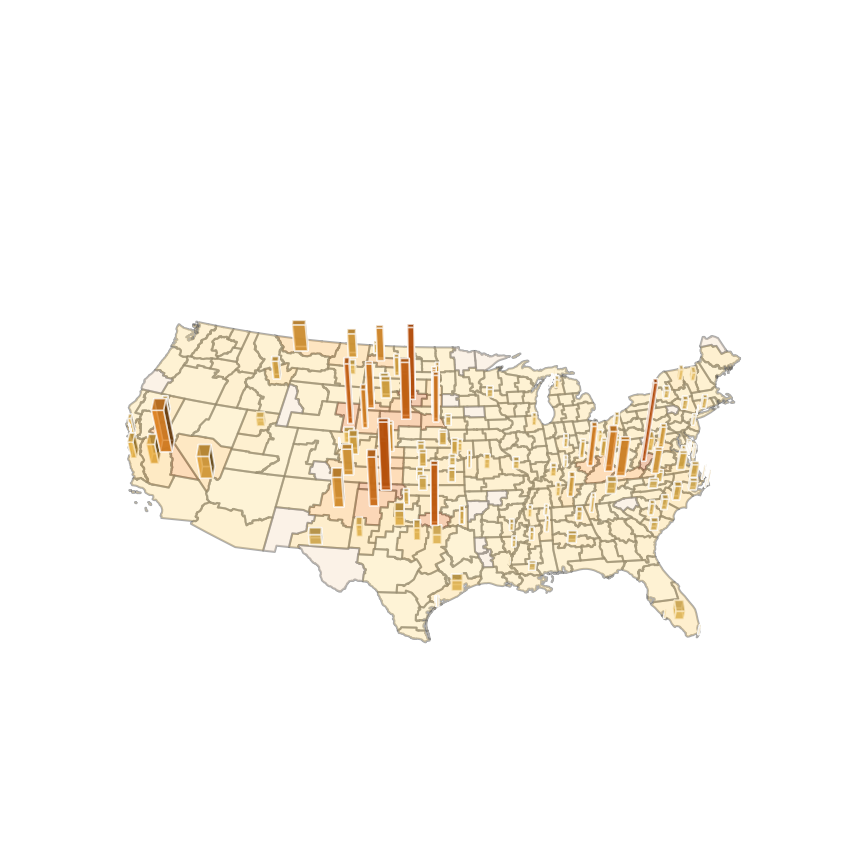

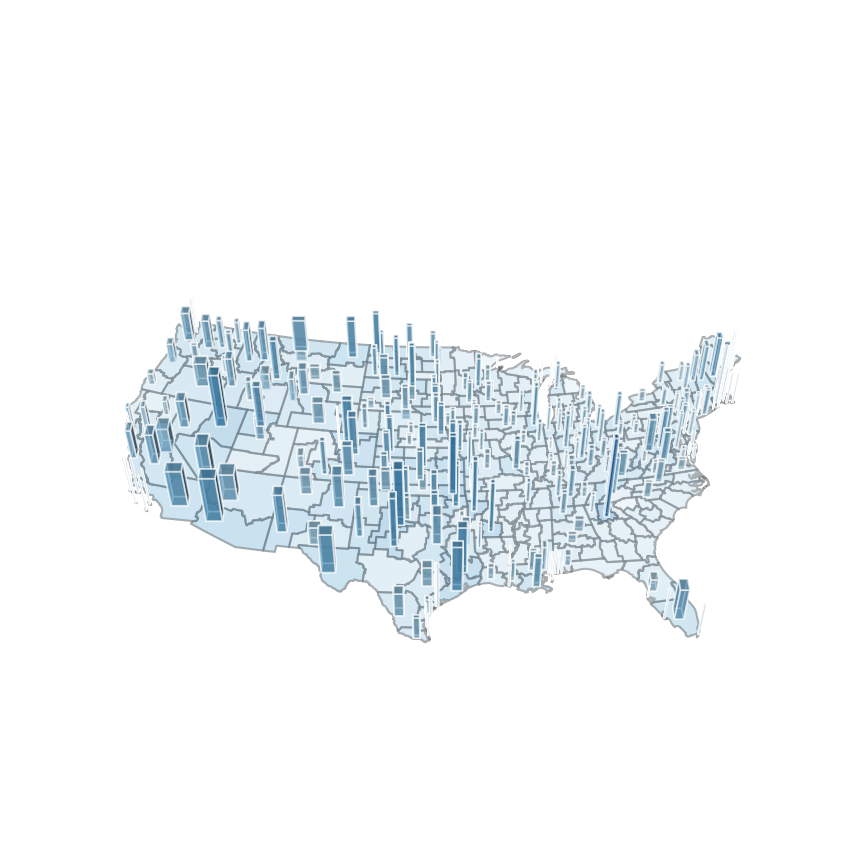

In [11]:

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import colors
from shapely.geometry import box
import shapely
from tqdm import tqdm

# ========= 统一配色：浅底 + 柔和色带（限制在较亮区间） =========
SCHEMES = {
    "Forest": {
        "floor":  "#CFEAD1",                 # 浅绿底
        "cmap":   plt.colormaps["Greens"],   # 同系色带
        "cmin":   0.30,                      # 只用 0.30~0.75 的较浅区域
        "cmax":   0.75,
        "bar_alpha": 0.70                    # 柱体透明度
    },
    "Agriculture": {
        "floor":  "#F3D7B7",
        "cmap":   plt.colormaps["YlOrBr"],
        "cmin":   0.28,
        "cmax":   0.72,
        "bar_alpha": 0.80
    },
    "Grass": {
        "floor":  "#CFE6F7",
        "cmap":   plt.colormaps["Blues"],
        "cmin":   0.30,
        "cmax":   0.75,
        "bar_alpha": 0.70
    },
}
LINE_COLOR  = (0.40, 0.40, 0.40, 0.55)      # 边界浅灰
BAR_EDGECOL = (1.00, 1.00, 1.00, 0.60)      # 柱体白色描边
FLOOR_ALPHA = 0.32                           # 底面透明度（0.28~0.38 建议）

def color_from_value(val, vmin, vmax, scheme):
    """把数值映射到指定色带的较浅区间，返回 RGBA"""
    if vmax <= vmin:
        t = 0.5
    else:
        t = np.clip((val - vmin) / (vmax - vmin), 0, 1)
    t = scheme["cmin"] + t * (scheme["cmax"] - scheme["cmin"])
    r, g, b, _ = scheme["cmap"](t)
    return (r, g, b, scheme["bar_alpha"])


def plot_3d_density(
    us_polys_4326, us_states_4326, df_weight,
    type_map = {
        "Forest": "weighted_density_Forest",
        "Agriculture": "weighted_density_Agricultural", 
        "Grass": "weighted_density_Vegetation"
    },
    top_pct = 20, z_scale = 1.2, z_transform = "sqrt", z_cap_q = 0.95,
    spike_km = 50, base_alpha = 0.35, figsize = (12, 3), title_prefix = "",
    mainbound = None
):
    """3D 密度尖峰图（统一配色、浅底 + 柔和同系色尖峰）。"""
    
    plt.rcParams.update({
        "font.family": "Arial", "font.size": 8, "axes.linewidth": 0.5,
        "savefig.bbox": "tight", "savefig.pad_inches": 0.05, "figure.dpi": 300
    })
    
    # 统一使用 ESRI:102003 投影（米）
    TARGET_CRS = "ESRI:102003"
    if mainbound is None:
        mainbound = {'lon_min': -125, 'lon_max': -65, 'lat_min': 25, 'lat_max': 49}
    bbox = box(mainbound['lon_min'], mainbound['lat_min'],
               mainbound['lon_max'], mainbound['lat_max'])
    
    # 数据转换 - 先裁剪再投影
    polys = us_polys_4326.clip(bbox).to_crs(TARGET_CRS).copy()
    states = us_states_4326.clip(bbox).to_crs(TARGET_CRS).copy()
    gpts = gpd.GeoDataFrame(
        df_weight.copy(),
        geometry=gpd.points_from_xy(df_weight["lon"], df_weight["lat"]),
        crs="EPSG:4326"
    ).clip(bbox).to_crs(TARGET_CRS)

    type_names = list(type_map.keys())
    figs = []

    for idx, (name, weight_col) in enumerate(type_map.items()):
        scheme = SCHEMES[name]
        print(f"处理 {name} 类型...")

        # 空间连接与每面均值
        joined = gpd.sjoin(gpts[["geometry", weight_col]], polys[["geometry"]], 
                           predicate="within", how="inner")
        means = joined.groupby(joined.index_right)[weight_col].mean()
        polys_plot = polys.copy()
        polys_plot["val"] = polys_plot.index.map(means).fillna(0.0)

        # 阈值
        percentile = top_pct
        density_threshold = np.percentile(polys_plot["val"].values, 100 - percentile) if np.any(polys_plot["val"] > 0) else 0

        # 不同类型的高度/阈值（保持你原先的风格）
        if name == "Forest":
            display_threshold = density_threshold * 0.9
            height_scale = 4000
            min_bar_size = 1000
        elif name == "Agriculture":
            display_threshold = density_threshold * 0.2
            height_scale = 25000
            min_bar_size = 1200
        else:  # Grass
            display_threshold = density_threshold * 0.2
            height_scale = 25000
            min_bar_size = 1200

        # 数值范围（仅正值）
        if np.any(polys_plot["val"] > 0):
            vmin = polys_plot.loc[polys_plot["val"] > 0, "val"].min()
            vmax = polys_plot["val"].max()
        else:
            vmin, vmax = 0.0, 1.0

        # 图与坐标轴
        fig = plt.figure(figsize=figsize)
        ax = plt.subplot(111, projection='3d')

        # 画县界（浅灰）
        for _, poly in polys.iterrows():
            geom = poly.geometry
            if geom.geom_type == 'Polygon':
                x, y = geom.exterior.xy
                ax.plot(x, y, [0]*len(x), color=LINE_COLOR, linewidth=0.5, zorder=1)
            else:
                for g in geom.geoms:
                    x, y = g.exterior.xy
                    ax.plot(x, y, [0]*len(x), color=LINE_COLOR, linewidth=0.5, zorder=1)

        # 便利函数：画一个 polygon（底面 + 山峰）
        def draw_one_polygon(polygon, val):
            x, y = polygon.exterior.xy
            x = np.asarray(x); y = np.asarray(y)

            # 底面：根据密度值着色，而不是统一淡色
            if val > 0:  # 有数据的区域
                # 使用与柱体相同的颜色映射，但透明度更高
                floor_rgba = color_from_value(val, vmin, vmax, scheme)
                # 调整透明度，让底图颜色更明显
                floor_rgba = (floor_rgba[0], floor_rgba[1], floor_rgba[2], 0.4)
            else:
                # 无数据的区域使用统一的淡色
                floor_rgba = scheme["floor"]
            
            # 使用Poly3DCollection绘制底面
            verts_bottom = [list(zip(x, y, np.zeros_like(x)))]
            poly_bottom = Poly3DCollection(verts_bottom,
                                           facecolor=floor_rgba,
                                           alpha=FLOOR_ALPHA,
                                           linewidths=0)
            ax.add_collection3d(poly_bottom)

            # 山峰：超过显示阈值才画；参照你的函数创建山峰效果
            if val > display_threshold:
                center_x, center_y = np.mean(x), np.mean(y)
                peak_height = val * height_scale
                sigma = 0.05  # 控制山峰的宽度，值越小山峰越陡峭
                
                # 创建山峰效果（参照你的函数）
                z = np.zeros_like(x)
                for i in range(len(x)):
                    dist = np.sqrt((x[i] - center_x)**2 + (y[i] - center_y)**2)
                    z[i] = peak_height * np.exp(-(dist**2)/(2*sigma**2))
                
                # 创建顶部山峰
                verts_top = [list(zip(x, y, z))]
                bar_rgba = color_from_value(val, vmin, vmax, scheme)
                poly_top = Poly3DCollection(verts_top, 
                                           alpha=scheme["bar_alpha"], 
                                           facecolor=bar_rgba)
                ax.add_collection3d(poly_top)

        # 遍历多边形绘制
        for _, row in tqdm(polys_plot.iterrows(), total=len(polys_plot), desc=f"绘制{name}"):
            geom = row.geometry
            val = float(row["val"])
            if geom is None or geom.is_empty: 
                continue
            if geom.geom_type == 'Polygon':
                draw_one_polygon(geom, val)
            else:
                for g in geom.geoms:
                    draw_one_polygon(g, val)

        # 视角与范围
        ax.set_proj_type('persp', focal_length=0.3)
        ax.view_init(elev=45, azim=270)

        # 坐标范围
        xmin, ymin, xmax, ymax = polys_plot.total_bounds
        if np.all(np.isfinite([xmin, ymin, xmax, ymax])):
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
        else:
            ax.set_xlim(-2_000_000, 2_000_000)
            ax.set_ylim(-1_500_000, 1_500_000)

        # Z 轴范围
        if np.any(polys_plot["val"] > 0):
            max_z = float(polys_plot["val"].max() * height_scale)
            ax.set_zlim(0, max(1.2*max_z, 1000))
        else:
            ax.set_zlim(0, 1000)

        ax.set_box_aspect([1.5, 1, 0.3])
        ax.set_axis_off()
        plt.tight_layout()
        figs.append(fig)

    return figs


# -------------------
# 执行示例（变量需已存在）
# -------------------
figs = plot_3d_density(
    us_polys_4326 = us_argscv_4326,   # 你的多边形面（如 ASD/County）
    us_states_4326 = us_nation_4326,  # 州/国界（用于裁剪/参考）
    df_weight = df_weight,            # 含 lon/lat 与三类权重
    type_map = {
        "Forest": "weighted_density_Forest",
        "Agriculture": "weighted_density_Agricultural",
        "Grass": "weighted_density_Vegetation"
    },
    top_pct = 5,
    z_scale = 1.0,
    z_transform = "sqrt",
    z_cap_q = 0.95,
    spike_km = 50,
    base_alpha = 0.8,
    figsize = (12, 3),
    title_prefix = "",
    mainbound = {'lon_min': -125, 'lon_max': -65, 'lat_min': 25, 'lat_max': 49}
)

# 保存或展示
for i, fig in enumerate(figs):
    fig.savefig(f"figure/US_figure/3d_density_{i}_300dpi.png", dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    plt.close(fig)


## 3.3 图3：碳汇统计图

=== Carbon Mitigation 积分计算（含标准误） ===
  Net Benefit排序: 4.512109e+01 ± 9.639248e-01
  Total Sinks排序: 6.148845e+01 ± 1.612792e-06
  Net Benefit对total_sinks积分: 4.495885e+01 ± 1.744141e-06
  Net Benefit vs Total Sinks排序: -26.62% ± 0.57%
  95%置信区间: [-27.73%, -25.50%]
  Net Benefit排序对total_sinks vs Total Sinks排序: -26.88% ± 0.00%
  95%置信区间: [-26.88%, -26.88%]
Carbon Mitigation - Net Benefit最高点: X=100.00%, Y=100.0%
Carbon Mitigation - Total Sinks排序最高点: X=100.00%, Y=100.0%
Carbon Mitigation - Net Benefit对total_sinks最高点: X=100.00%, Y=100.0%


C:\Users\zpy10\AppData\Local\Temp\ipykernel_247004\957103709.py:404: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


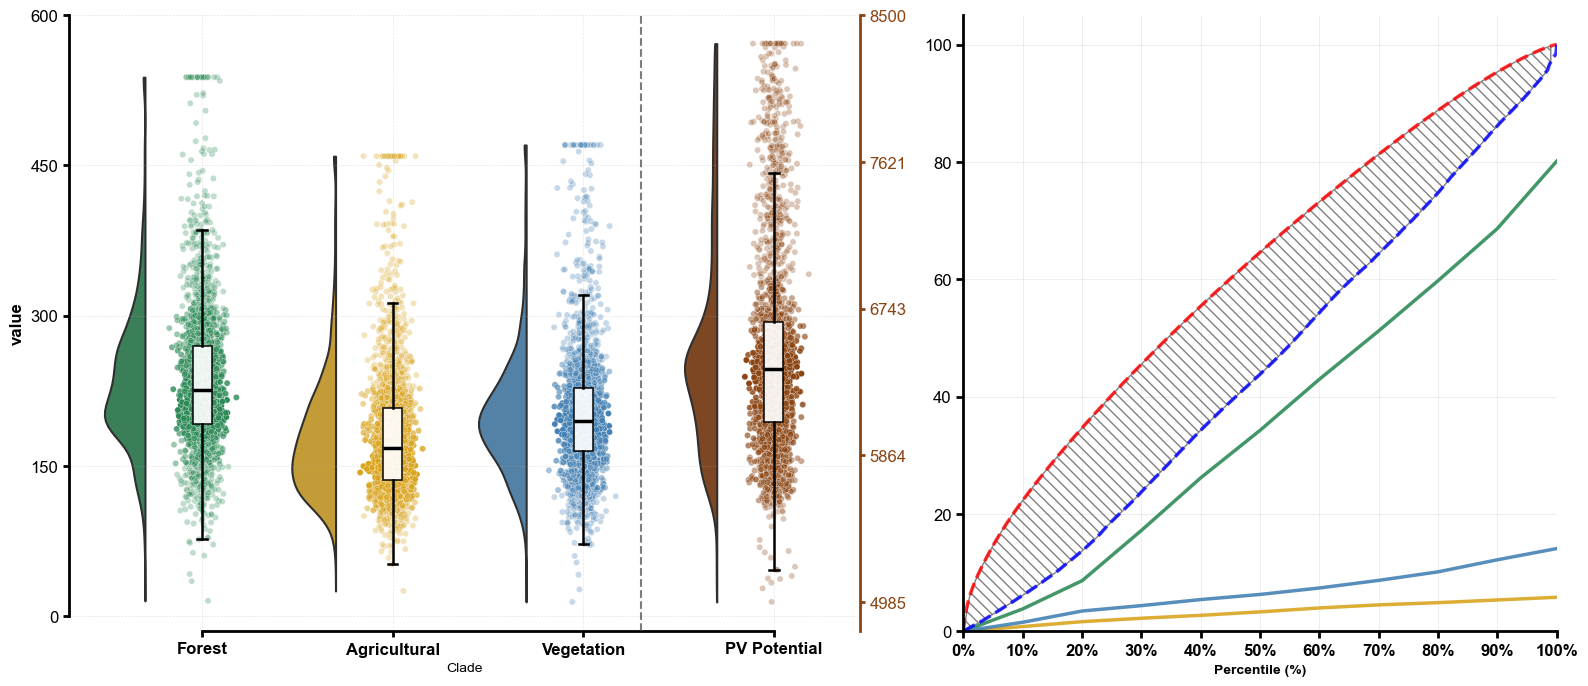

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt
from scipy.stats import ttest_ind
from scipy.stats import gaussian_kde
import matplotlib.ticker as ticker
import geopandas as gpd
from shapely.geometry import box


def integrated_cloudrain_carbon_analysis(pixel_optimized_data, df_net_benefit, df_weight, us_counties_4326,
                                       percentiles=np.arange(3,101,3),
                                       targets=('Expectation_net_benefit','Carbon Mitigation')):
    """
    整合云雨图和Carbon Mitigation折线图的分析图
    以云雨图为基准，右侧添加Carbon Mitigation累积曲线
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import ptitprince as pt
    from scipy.stats import gaussian_kde
    import matplotlib.ticker as ticker
    import geopandas as gpd
    from shapely.geometry import box

    # ---------- 数据预处理 ----------
    m = (pixel_optimized_data
         .merge(df_net_benefit[['lat','lon','area_m2']], on=['lat','lon'], how='inner')
         .merge(df_weight[['lat','lon',
                           'final_forest','weighted_density_Forest',
                           'final_agro','weighted_density_Agricultural',
                           'final_veg','weighted_density_Vegetation',
                           'pv_potential_dens']], on=['lat','lon'], how='inner'))

    # 碳汇计算（按面积）
    ha = (m['area_m2'].values/10000.0)
    forest = m['final_forest'].values * m['weighted_density_Forest'].values * ha
    agro   = m['final_agro'].values   * m['weighted_density_Agricultural'].values * ha
    veg    = m['final_veg'].values    * m['weighted_density_Vegetation'].values * ha

    # ---------- 空间聚合（修复变量名与索引） ----------
    df_weight_gdf = gpd.GeoDataFrame(
        df_weight[['lat', 'lon', 'final_forest', 'final_agro', 'final_veg', 'pv_potential_dens']],
        geometry=gpd.points_from_xy(df_weight['lon'], df_weight['lat']),
        crs='EPSG:4326'
    )

    usa_box = box(-125, 25, -65, 51)
    box_gdf = gpd.GeoDataFrame(geometry=[usa_box], crs='EPSG:4326')

    # 用传入的 us_counties_4326（而不是未定义的 us_argscv_4326）
    regions = us_counties_4326.to_crs(4326)
    regions_clipped = regions.clip(box_gdf)
    points_clipped  = df_weight_gdf.clip(box_gdf)

    # 空间连接；保留右表索引列用于聚合
    joined = gpd.sjoin(points_clipped, regions_clipped[['geometry']], predicate='within', how='inner')
    # 以 index_right（多边形索引）聚合求均值
    aggregated_data = (joined
                       .groupby('index_right')[['final_forest','final_agro','final_veg','pv_potential_dens']]
                       .mean()
                       .reset_index(drop=True))

    # ---------- 配色 ----------
    palette = {
        'final_forest': '#2E8B57',
        'final_agro': '#DAA520',
        'final_veg': '#4682B4',
        'pv_potential_dens': '#8B4513'
    }
    carbon_colors = {'Forest': '#2E8B57', 'Agriculture': '#DAA520', 'Vegetation': '#4682B4', 'Total': '#6CB6C9'}

    # ---------- 画布 ----------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8),
                                   gridspec_kw={'width_ratios': [2, 1.5], 'wspace': 0.15})  # 减少空隙

    # ---------- 左图：统一类别定位（修复位置错乱的关键） ----------
    order = ['final_forest', 'final_agro', 'final_veg', 'pv_potential_dens']  # PV 作为第4类
    agg_clip = aggregated_data.copy()
    # 对每列做 99% 分位数截断，避免极端值挤压
    for col in order:
        q99 = agg_clip[col].quantile(0.99)
        agg_clip[col] = agg_clip[col].clip(upper=q99)

    df_long = agg_clip[order].melt(var_name="Clade", value_name="value")

    offset = 0.15
    box_width = 0.1
    violin_width = 0.5
    jitter_width = 0.05


    # ---- 计算两种量纲的线性映射(把PV映射到生物量的刻度上来画) ----
    carbon_data = df_long[df_long['Clade'] != 'pv_potential_dens']['value']
    carbon_min = carbon_data.min()
    carbon_max = carbon_data.max()
    # 优化主y轴显示范围，允许最大到600或550
    y_upper = 600 if carbon_max > 550 else 600
    ax1.set_ylim(carbon_min - 0.05 * (y_upper - carbon_min), y_upper)

    # 获取PV数据
    pv_data = df_long[df_long['Clade'] == 'pv_potential_dens']['value']

    if len(pv_data) > 0:
        pv_min = pv_data.min()
        pv_max = pv_data.max()
        pv_max_display = max(8500, pv_max)
        scale = (y_upper - carbon_min) / (pv_max_display - pv_min)

        def pv_to_carbon(y_pv):
            return carbon_min + (y_pv - pv_min) * scale
        def carbon_to_pv(y_carbon):
            return pv_min + (y_carbon - carbon_min) / scale

        # 把df_long里PV的值替换为"映射后的值"，这样它能在ax1上显示
        df_long.loc[df_long['Clade'] == 'pv_potential_dens', 'value'] = \
            pv_to_carbon(df_long.loc[df_long['Clade'] == 'pv_potential_dens', 'value'].values)

        # 右侧刻度显示真实 PV 单位，最大允许到8500
        secax = ax1.secondary_yaxis('right', functions=(carbon_to_pv, pv_to_carbon))
        secax.tick_params(axis='y', colors='#8B4513', labelsize=12, width=2)
        secax.spines['right'].set_color('#8B4513')
        secax.spines['right'].set_linewidth(2)

        # 只显示合适的PV刻度，避免小数
        pv_ticks = np.linspace(pv_min, pv_max_display, 5)
        pv_ticks = np.round(pv_ticks).astype(int)
        secax.set_yticks(pv_ticks)
        secax.set_yticklabels([str(v) for v in pv_ticks], fontsize=12)

        secax.set_ylim(pv_min, pv_max_display)

    # 半小提琴图（一次性画四类，位置自然是 0,1,2,3；偏移统一为 offset+0.1）
    pt.half_violinplot(
        x='Clade', y='value', data=df_long,
        order=order,
        palette=[palette[v] for v in order],
        bw=.2, cut=0, scale="area",
        width=violin_width,
        inner=None, orient="v", ax=ax1,
        offset=offset
    )

    # 在前三个变量与第四个变量之间加一条深灰色虚线
    ax1.axvline(2.3 + offset, color='#444444', linestyle='--', linewidth=1.5, alpha=0.7, zorder=10)

    # 箱线图（与半小提琴位置完全一致）
    data_list = [df_long[df_long['Clade'] == v]['value'].values for v in order]
    positions = np.arange(len(order)) + offset
    bp = ax1.boxplot(
        data_list, positions=positions, widths=box_width,
        patch_artist=True, showfliers=False,
        medianprops={'linewidth': 2.5, 'color': 'black'},
        whiskerprops={'linewidth': 1.8, 'color': 'black'},
        capprops={'linewidth': 1.8, 'color': 'black'},
        boxprops={'linewidth': 1.2}, zorder=5
    )
    for patch in bp['boxes']:
        patch.set(facecolor='white', alpha=0.9, edgecolor='black')

    # 抖点（与半小提琴/箱线同位置）
    def get_density_colors(data, base_color, n_levels=5):
        from matplotlib.colors import to_rgba
        if len(data) < 2:
            return [to_rgba(base_color)] * len(data)
        kde = gaussian_kde(data)
        density = kde(data)
        qs = np.percentile(density, np.linspace(0,100,n_levels+1))
        base = to_rgba(base_color)
        out = []
        for d in density:
            lvl = np.clip(np.digitize(d, qs)-1, 0, n_levels-1)
            a = 0.3 + 0.7 * (lvl/max(1,n_levels-1))
            out.append((base[0], base[1], base[2], float(a)))
        return out

    for i, v in enumerate(order):
        vals = df_long[df_long['Clade'] == v]['value'].values
        if len(vals) == 0:
            continue
        colors = get_density_colors(vals, palette[v])
        xj = np.random.normal(i + offset, jitter_width, size=len(vals))
        ax1.scatter(xj, vals, c=colors, s=20, edgecolors='white', linewidth=0.2, zorder=3)

    # 轴与标签（保证标签与位置完全匹配）
    ax1.set_xticks(positions)
    ax1.set_xticklabels(['Forest', 'Agricultural', 'Vegetation', 'PV Potential'],
                        fontsize=12, fontweight='bold')
    ax1.set_xlim(-0.55, len(order)-0.4)
    ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    sns.despine(ax=ax1, trim=True)
    ax1.yaxis.set_major_locator(plt.MaxNLocator(nbins=6))
    ax1.tick_params(axis='y', labelsize=12, length=4, width=2, colors='black', labelcolor='black')
    ax1.tick_params(axis='x', labelsize=12, length=4, width=2)
    ax1.yaxis.label.set_fontweight('bold')
    ax1.yaxis.label.set_color('black')
    ax1.yaxis.label.set_size(12)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['left'].set_color('black')
    # === 使左图x轴轴线样式与右图一致 ===
    for sp in ['top','right']: ax1.spines[sp].set_visible(False)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.spines['bottom'].set_color('black')

    # ---------- 右图：Carbon Mitigation 累积曲线 ----------
    # ax2.set_facecolor('#F8F8FF')
    for sp in ['top','right']: ax2.spines[sp].set_visible(False)
    ax2.spines['bottom'].set_linewidth(2); ax2.spines['left'].set_linewidth(2)
    ax2.spines['bottom'].set_color('black'); ax2.spines['left'].set_color('black')

    tcol, _ = targets
    order_by_net_benefit = np.argsort(m[tcol].values)[::-1]
    total_sinks = forest + agro + veg
    total_max = np.sum(total_sinks)
    n = len(order_by_net_benefit)

    def cum_pct(arr):
        y = np.concatenate([[0], np.cumsum(arr[order_by_net_benefit])]) / total_max * 100
        return y

    yF = cum_pct(forest); yA = cum_pct(agro); yV = cum_pct(veg); yT = cum_pct(total_sinks)
    keyp = np.array([0,10,20,30,40,50,60,70,80,90,100])
    idxs = (keyp/100.0*n).astype(int)
    forest_y, agro_y, veg_y, total_y = yF[idxs], yA[idxs], yV[idxs], yT[idxs]

    # === 按total_sinks和net_benefit排序的累积曲线与积分 ===

    # 按total_sinks降序排序
    idx_total_sinks = np.argsort(total_sinks)[::-1]
    total_sinks_sorted = total_sinks[idx_total_sinks]
    total_sinks_cumsum = np.cumsum(total_sinks_sorted)
    total_sinks_cumsum_pct = np.concatenate([[0], total_sinks_cumsum]) / total_max * 100
    total_sinks_percentile = np.concatenate([[0], np.arange(1, len(total_sinks_cumsum)+1) / len(total_sinks_cumsum) * 100])

    # 按net_benefit降序排序
    idx_net_benefit = np.argsort(m[tcol].values)[::-1]
    total_sinks_by_net_benefit = total_sinks[idx_net_benefit]
    total_sinks_cumsum_by_net_benefit = np.cumsum(total_sinks_by_net_benefit)
    total_sinks_cumsum_pct_by_net_benefit = np.concatenate([[0], total_sinks_cumsum_by_net_benefit]) / total_max * 100
    net_benefit_percentile = np.concatenate([[0], np.arange(1, len(total_sinks_cumsum_by_net_benefit)+1) / len(total_sinks_cumsum_by_net_benefit) * 100])

    def calculate_integral(x, y):
        """使用梯形法则计算积分"""
        if len(x) < 2:
            return 0.0
        # 确保x是单调递增的
        if x[0] > x[-1]:
            x = x[::-1]
            y = y[::-1]
        # 梯形法则：∫f(x)dx ≈ Σ[(f(xi) + f(xi+1))/2 * (xi+1 - xi)]
        integral = 0.0
        for i in range(len(x) - 1):
            dx = x[i+1] - x[i]
            avg_y = (y[i+1] + y[i]) / 2.0
            integral += avg_y * dx
        return integral

    def calculate_integral_with_contribution_std_error(cumulative_benefits, cumulative_percentage):
        """基于样本贡献计算积分及其标准误"""
        x_01 = cumulative_percentage / 100.0
        integral = calculate_integral(x_01, cumulative_benefits)
        
        # 计算每个小段的贡献
        n_segments = len(cumulative_benefits) - 1
        if n_segments > 1:
            segment_contributions = []
            for i in range(n_segments):
                dx = x_01[i+1] - x_01[i]
                avg_y = (cumulative_benefits[i+1] + cumulative_benefits[i]) / 2.0
                contribution = avg_y * dx
                segment_contributions.append(contribution)
            
            # 基于贡献计算标准误
            contribution_std = np.std(segment_contributions, ddof=1)
            contribution_std_error = contribution_std / np.sqrt(n_segments)
        else:
            contribution_std_error = 0
        
        return integral, contribution_std_error

    def pct_to_01(arr): 
        return arr / 100.0

    # 计算积分及其标准误
    x_01_keyp = pct_to_01(keyp)
    x_01_total_sinks = pct_to_01(total_sinks_percentile)
    x_01_net_benefit = pct_to_01(net_benefit_percentile)

    # 使用增强的积分计算函数
    integral_net_benefit, std_error_net_benefit = calculate_integral_with_contribution_std_error(total_y, keyp)
    integral_total_sinks, std_error_total_sinks = calculate_integral_with_contribution_std_error(total_sinks_cumsum_pct, total_sinks_percentile)
    integral_net_benefit_sort, std_error_net_benefit_sort = calculate_integral_with_contribution_std_error(total_sinks_cumsum_pct_by_net_benefit, net_benefit_percentile)

    print(f"=== Carbon Mitigation 积分计算（含标准误） ===")
    print(f"  Net Benefit排序: {integral_net_benefit:.6e} ± {std_error_net_benefit:.6e}")
    print(f"  Total Sinks排序: {integral_total_sinks:.6e} ± {std_error_total_sinks:.6e}")
    print(f"  Net Benefit对total_sinks积分: {integral_net_benefit_sort:.6e} ± {std_error_net_benefit_sort:.6e}")

    # 计算性能提升及其标准误
    if integral_total_sinks != 0:
        improvement = (integral_net_benefit - integral_total_sinks) / abs(integral_total_sinks) * 100
        
        # 计算性能提升的标准误（使用误差传播公式）
        # 相对误差 = sqrt((std_error_net_benefit/integral_net_benefit)^2 + (std_error_total_sinks/integral_total_sinks)^2)
        if integral_net_benefit != 0:
            relative_error_net_benefit = std_error_net_benefit / abs(integral_net_benefit)
            relative_error_total_sinks = std_error_total_sinks / abs(integral_total_sinks)
            improvement_std_error = abs(improvement) * np.sqrt(relative_error_net_benefit**2 + relative_error_total_sinks**2)
            
            print(f"  Net Benefit vs Total Sinks排序: {improvement:+.2f}% ± {improvement_std_error:.2f}%")
            print(f"  95%置信区间: [{improvement - 1.96*improvement_std_error:.2f}%, {improvement + 1.96*improvement_std_error:.2f}%]")
        else:
            print(f"  Net Benefit vs Total Sinks排序: {improvement:+.2f}%")
    else:
        print(f"  Net Benefit vs Total Sinks排序: 无法计算（分母为0）")

    # 计算Net Benefit排序对total_sinks的性能提升
    if integral_net_benefit_sort != 0:
        improvement_sort = (integral_net_benefit_sort - integral_total_sinks) / abs(integral_total_sinks) * 100
        
        if integral_total_sinks != 0:
            relative_error_sort = std_error_net_benefit_sort / abs(integral_net_benefit_sort)
            relative_error_total_sinks = std_error_total_sinks / abs(integral_total_sinks)
            improvement_sort_std_error = abs(improvement_sort) * np.sqrt(relative_error_sort**2 + relative_error_total_sinks**2)
            
            print(f"  Net Benefit排序对total_sinks vs Total Sinks排序: {improvement_sort:+.2f}% ± {improvement_sort_std_error:.2f}%")
            print(f"  95%置信区间: [{improvement_sort - 1.96*improvement_sort_std_error:.2f}%, {improvement_sort + 1.96*improvement_sort_std_error:.2f}%]")
        else:
            print(f"  Net Benefit排序对total_sinks vs Total Sinks排序: {improvement_sort:+.2f}%")
    else:
        print(f"  Net Benefit排序对total_sinks vs Total Sinks排序: 无法计算（分母为0）")

    # 绘制原有曲线
    ax2.plot(keyp, forest_y, lw=2.5, alpha=0.9, color=carbon_colors['Forest'], label=f'Forest (max: {forest_y[-1]:.1f}%)')
    ax2.plot(keyp, agro_y,   lw=2.5, alpha=0.9, color=carbon_colors['Agriculture'], label=f'Agriculture (max: {agro_y[-1]:.1f}%)')
    ax2.plot(keyp, veg_y,    lw=2.5, alpha=0.9, color=carbon_colors['Vegetation'], label=f'Vegetation (max: {veg_y[-1]:.1f}%)')
    # ax2.plot(keyp, total_y,  lw=3.0, alpha=0.9, color=carbon_colors['Total'], label=f'Total (max: {total_y[-1]:.1f}%)')

    # 添加total_sinks排序的红色虚线
    ax2.plot(total_sinks_percentile, total_sinks_cumsum_pct, 
             color='red', linestyle='--', linewidth=2.5, alpha=0.8, 
             label=f'By Total Sinks (max: {total_sinks_cumsum_pct[-1]:.1f}%)')

    # 添加net_benefit排序的蓝色虚线
    ax2.plot(net_benefit_percentile, total_sinks_cumsum_pct_by_net_benefit,
             color='blue', linestyle='--', linewidth=2.5, alpha=0.8,
             label=f'By Net Benefit (max: {total_sinks_cumsum_pct_by_net_benefit[-1]:.1f}%)')

    # 最高点
    net_benefit_max_idx = np.argmax(total_y)
    total_sinks_max_idx = np.argmax(total_sinks_cumsum_pct)
    net_benefit_sort_max_idx = np.argmax(total_sinks_cumsum_pct_by_net_benefit)

    print(f"Carbon Mitigation - Net Benefit最高点: X={keyp[net_benefit_max_idx]:.2f}%, Y={total_y[net_benefit_max_idx]:.1f}%")
    print(f"Carbon Mitigation - Total Sinks排序最高点: X={total_sinks_percentile[total_sinks_max_idx]:.2f}%, Y={total_sinks_cumsum_pct[total_sinks_max_idx]:.1f}%")
    print(f"Carbon Mitigation - Net Benefit对total_sinks最高点: X={net_benefit_percentile[net_benefit_sort_max_idx]:.2f}%, Y={total_sinks_cumsum_pct_by_net_benefit[net_benefit_sort_max_idx]:.1f}%")


    from scipy.interpolate import interp1d
    
    # 创建统一的x轴点（0-100%）
    unified_x = np.linspace(0, 100, 101)
    
    # 对两条曲线进行插值，确保x轴对齐
    if len(total_sinks_percentile) > 1 and len(net_benefit_percentile) > 1:
        # 创建插值函数
        f_total_sinks = interp1d(total_sinks_percentile, total_sinks_cumsum_pct, 
                                kind='linear', bounds_error=False, fill_value='extrapolate')
        f_net_benefit = interp1d(net_benefit_percentile, total_sinks_cumsum_pct_by_net_benefit, 
                                kind='linear', bounds_error=False, fill_value='extrapolate')
        
        # 在统一x轴上计算y值
        y_total_sinks = f_total_sinks(unified_x)
        y_net_benefit = f_net_benefit(unified_x)
        


        ax2.fill_between(
            unified_x, y_total_sinks, y_net_benefit,
            where=(y_total_sinks >= y_net_benefit),
            alpha=1, color='none', hatch='\\\\\\', edgecolor='gray', linewidth=1, zorder=1
        )

    # 设置X轴刻度
    ax2.set_xticks(keyp); ax2.set_xlim(0,100)
    ax2.set_xticklabels([f'{p}%' for p in keyp], ha='center', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Percentile (%)', fontsize=10, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
    ax2.set_axisbelow(True)
    ax2.tick_params(axis='both', which='major', width=2, size=5, labelsize=12, color='black', labelcolor='black')

    # y轴从0开始
    ax2.set_ylim(bottom=0)

    # 图幅加宽
    fig = ax2.get_figure()
    w, h = fig.get_size_inches()
    fig.set_size_inches(w*1.2, h, forward=True)

    plt.tight_layout()
    return fig

fig = integrated_cloudrain_carbon_analysis(df_pixel_optimized_data, df_net_benefit, df_weight, us_counties_4326)
fig.savefig("figure/US_figure/integrated_cloudrain_carbon.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.close(fig)


# 四、经济内容图

### Load data

In [1]:
from matplotlib import pyplot as plt
from function import *
from function.global_varibles import *
import glob
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np



df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_weight = pd.read_csv('data/US_data/df_weight.csv')
df_strategies = pd.read_csv('data/US_data/df_strategies.csv')
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')
df_pv_npv = pd.read_csv('data/US_data/df_pv_npv.csv')
df_agricultural_npv = pd.read_csv('data/US_data/df_agricultural_npv.csv')
df_afforestation_npv = pd.read_csv('data/US_data/df_afforestation_npv.csv')
df_natural_npv = pd.read_csv('data/US_data/df_natural_npv.csv')
df_gmm_scores = pd.read_csv('data/US_data/df_gmm_scores.csv')
df_pixel_optimized_data = pd.read_csv('data/US_data/df_pixel_optimized_data.csv')

us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')
us_argscv = gpd.read_file("figure/draw_shp/ASD_2012_5m.shp")


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')
us_argscv_4326 = us_argscv.to_crs('EPSG:4326')
df_climate_zone=pd.read_csv(r'data\US_data\df_zones.csv')

gogogo


In [2]:
df_economic

lat         lon pv_category      pv_model  \
0         31.320833 -105.929170          C1    REMIND 2.1   
1         31.329166 -105.929170          C1    REMIND 2.1   
2         31.337500 -105.937500          C1    REMIND 2.1   
3         31.337500 -105.929170          C1    REMIND 2.1   
4         31.345833 -105.937500          C1    REMIND 2.1   
...             ...         ...         ...           ...   
68880915  46.937500  -67.920830          C7  TIAM-ECN 1.1   
68880916  47.145832  -67.962500          C7  TIAM-ECN 1.1   
68880917  47.237500  -68.620834          C7  TIAM-ECN 1.1   
68880918  47.254166  -68.354164          C7  TIAM-ECN 1.1   
68880919  47.262500  -68.379166          C7  TIAM-ECN 1.1   

                   pv_scenario policy_category rcp_category   net_npv_usd  \
0         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364320e+06   
1         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364268e+06   
2         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364232e+06   
3         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364223e+06   
4         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364196e+06   
...                        ...             ...          ...           ...   
68880915        EN_NPi2100_COV             P1b       RCP8.5  4.447125e+06   
68880916        EN_NPi2100_COV             P1b       RCP8.5  4.148731e+06   
68880917        EN_NPi2100_COV             P1b       RCP8.5  4.294753e+06   
68880918        EN_NPi2100_COV             P1b       RCP8.5  4.331141e+06   
68880919        EN_NPi2100_COV             P1b       RCP8.5  4.147186e+06   

          net_cost_usd  analysis_year  
0         2.364320e+06           2020  
1         2.364268e+06           2020  
2         2.364232e+06           2020  
3         2.364223e+06           2020  
4         2.364196e+06           2020  
...                ...            ...  
68880915  4.654054e+06           2050  
68880916  4.654008e+06           2050  
68880917  4.654032e+06           2050  
68880918  4.654020e+06           2050  
68880919  4.654010e+06           2050  

[68880920 rows x 10 columns]

In [3]:
len(df_economic['policy_category'].unique())

11

### 4.1 图1：经济折线图

Logic: 

总共有三张图：

第一是机会成本：机会成本按照C1-C7进行划分；
第二是政策收益：政策收益按照P1-P3进行归类；
第三是累积路线：全生命周期的累积路线；

政策收益：

修改一下，对于坐标轴line和xticks统一为黑色、width==2。 数据标签为12号字体，黑色bold。其次，我需要按照P1,P2,P3进行Group绘制曲线（三张折线图，横版放置）。以P1 Group为例，首先：绘制每个pixel对应的analysis_year	==2020, 2030, 2040, 2050的'net_npv_usd'。用#CCCCCC配色进行绘制。其次，对于所有的pixel各个年份计算对应analysis_year的mean，并且形成曲线。利用#4E4EFF配色，其置信区间使用#CCCCFF。P2, P3group按照类似的逻辑，但是对于mean曲线分别采用P2：#359A35（mean主线），#CCE6CC(置信区间)，具体曲线#CCCCCC。P3：#FFBA3D(mean主线)，#FFEDCC（置信区间）。一般pixel级别曲线都使用用#CCCCCC配色

以上3个group置信区间用95% CI 计算，不要用SD或者SE。


机会收益：

对于坐标轴line和xticks统一为黑色、width==2，字体为Arial。数据标签为12号字体，黑色bold。其次，我需要你绘制一张机会成本的柱状堆积图（带误差棒，图幅fig大概是（6，5）），去观察P1,P2,P3三大类政策中，df_agricultural_npv，df_afforestation_npv，df_natural_npv机会收益是占比如何（只需要到analysis_year==2050）。变量名称都是['cumulative_npv_usd']。

在执行之前，你需要创建双重映射，第一重映射是提取df_economic['policy_category']到'rcp_category'的unique group，然后将df_agricultural_npv，df_afforestation_npv，df_natural_npv中的'rcp_category'（每个变量都有RCP2.6, 4.5, 6.0, 6.5, df_agricultural_npv列名叫做RCP_Category，可以都对列名小写后查询）与df_economic['policy_category']进行匹配。这样就实现了每个row有对应的三类成本数据。这个映射大致应该如下执行：（1）按照rcpmapping的逻辑，先匹配df_economic['pv_category']。（2）获取df_economic['policy_category']与df_economic['pv_category']的unique组合，进而建立df_economic['pv_category']，df_economic['policy_category']，各个变量rcp_category的联系。
rcp_mapping = {
        'C1': 'RCP2.6', 'C2': 'RCP2.6', 'C3': 'RCP2.6',
        'C4': 'RCP4.5',
        'C5': 'RCP6.0', 
        'C6': 'RCP8.5', 'C7': 'RCP8.5', 'C8': 'RCP8.5'
    }



第二重映射是为了聚类，本质上是要把unique group中按照policy_category各个小类合并成大类的P1,P2,P3，类似于match_policy，但是可以用考虑字符串匹配，（用mean聚合）
    def match_policy(val):
        s = str(val)
        if 'P1' in s: return 'P1'
        if 'P2' in s: return 'P2'
        if 'P3' in s: return 'P3'
        return 'Other'
    

累积路线：




In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch
from matplotlib.collections import LineCollection
from scipy import stats
from tqdm.auto import tqdm

def create_policy_scenarios_analysis(df_economic):
    """
    修复版本：
    - Y轴标题标注10^3单位
    - 图例在各图左上角，向下移动
    - 均值线在图例中显示
    - 修复红线范围，只到2050
    - 优化P1的Y轴，压缩-500,000到0区间
    - 优化：使用已有的py变量计算30年平均值，避免重复计算
    """
    def match_policy(val):
        s = str(val)
        if 'P1' in s: return 'P1'
        if 'P2' in s: return 'P2'
        if 'P3' in s: return 'P3'
        return 'Other'

    df = df_economic.copy()
    df['policy_group'] = df['policy_category'].astype(str).apply(match_policy)
    df = df[df['policy_group'].isin(['P1','P2','P3'])]

    years = np.sort(df['analysis_year'].unique())
    policy_groups = ['P1','P2','P3']

    # 设置字体为Arial
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.sans-serif'] = ['Arial']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    # 使用当前颜色方案（P2 mean为洋红，P3 mean为紫色系）
    colors = {
        'P1': dict(mean='#4E4EFF', ci='#6B6BFF', pixel='#BBBBBB', 
                   band_75='#E6E6FF'),
        'P2': dict(mean='#E6007A', ci='#FF4FA3', pixel='#BBBBBB', 
                   band_75='#F9D1E6'),  # mean洋红，ci亮洋红，带淡粉
        'P3': dict(mean='#8B3EFF', ci='#B266FF', pixel='#BBBBBB', 
                   band_75='#E6D6FF')   # mean紫色，ci淡紫，带淡紫
    }

    # ==================== 新增：计算各政策情景30年平均NPV和标准误 ====================
    print("="*80)
    print("各政策情景30年期间平均NPV统计分析")
    print("="*80)
    
    policy_npv_stats = {}
    
    for ax, policy in zip(axes, policy_groups):
        g = df[df['policy_group'] == policy]
        if g.empty:
            ax.text(0.5,0.5,f'No data for {policy}', ha='center', va='center', transform=ax.transAxes)
            continue

        # —— 统一到"像素-年份"样本 —— #
        py = (g.groupby(['lat','lon','analysis_year'], as_index=False)['net_npv_usd']
              .mean())

        # ==================== 使用py变量计算30年平均值 ====================
        # 第一步：按年份计算均值
        year_means = (py.groupby('analysis_year')['net_npv_usd']
                     .mean()
                     .reindex(years))
        
        # 第二步：计算30年期间的平均值
        overall_mean = year_means.mean()
        
        # 第三步：计算30年期间的标准差（年份间的变异）
        overall_std = year_means.std(ddof=1)
        
        # 第四步：计算标准误（年份间标准差除以年份数量的平方根）
        n_years = len(years)
        standard_error = overall_std / np.sqrt(n_years)
        
        # 计算95%置信区间
        confidence_interval_95 = 1.96 * standard_error
        
        # 存储统计结果
        policy_npv_stats[policy] = {
            'n_years': n_years,
            'overall_mean': overall_mean,
            'overall_std': overall_std,
            'standard_error': standard_error,
            'ci_95_lower': overall_mean - confidence_interval_95,
            'ci_95_upper': overall_mean + confidence_interval_95,
            'year_means': year_means  # 保存年份均值用于绘图
        }
        
        # 打印结果
        print(f"\n{policy} 政策情景:")
        print(f"  年份数量: {n_years}")
        print(f"  30年平均NPV: {overall_mean:,.2f} USD/ha")
        print(f"  年份间标准差: {overall_std:,.2f} USD/ha")
        print(f"  标准误: {standard_error:,.2f} USD/ha")
        print(f"  95%置信区间: [{overall_mean - confidence_interval_95:,.2f}, {overall_mean + confidence_interval_95:,.2f}] USD/ha")
        
        # 打印各年份的均值
        print(f"  各年份均值:")
        for year, mean_val in year_means.items():
            print(f"    {year}: {mean_val:,.2f} USD/ha")
        
        # 转换为更易读的单位
        if abs(overall_mean) >= 1e6:
            print(f"  30年平均NPV: {overall_mean/1e6:.3f} M USD/ha")
        elif abs(overall_mean) >= 1e3:
            print(f"  30年平均NPV: {overall_mean/1e3:.3f} K USD/ha")
        
        if abs(standard_error) >= 1e6:
            print(f"  标准误: {standard_error/1e6:.3f} M USD/ha")
        elif abs(standard_error) >= 1e3:
            print(f"  标准误: {standard_error/1e3:.3f} K USD/ha")

        # —— 像素曲线（极低透明度） —— #
        pivot = (py.pivot_table(index=['lat','lon'], columns='analysis_year',
                                values='net_npv_usd', aggfunc='mean')
                 .reset_index())

        segs = []
        for _, row in pivot.iterrows():
            xs, ys = [], []
            for y in years:
                v = row.get(y, np.nan)
                if pd.notna(v):
                    xs.append(float(y)); ys.append(float(v))
            if len(xs) > 1:
                segs.append(np.column_stack([xs, ys]))
        if segs:
            lc = LineCollection(segs, colors=colors[policy]['pixel'],
                                linewidths=0.25, alpha=0.04, zorder=1)
            lc.set_rasterized(True)
            ax.add_collection(lc)

        # —— 只显示25-75%分位数带 —— #
        q = (py.groupby('analysis_year')['net_npv_usd']
               .quantile([0.25,0.75]).unstack())
        q = q.reindex(years)
        x  = q.index.to_numpy(dtype=float)
        q25, q75 = [q[c].to_numpy(dtype=float) for c in [0.25,0.75]]

        # 25-75%分位数带
        ax.fill_between(x, q25, q75, color=colors[policy]['band_75'], 
                        alpha=1, zorder=3, linewidth=0)

        # —— 均值线 —— #
        # 直接使用已计算的年份均值
        x_ci = years
        mu = year_means.values
        
        # 均值线
        mean_line, = ax.plot(x_ci, mu, color=colors[policy]['mean'], linewidth=3,
                marker='o', markersize=7, label=f'{policy} Mean', zorder=12)

        # —— 轴样式 —— #
        ax.set_title(policy, fontsize=14, fontweight='bold', color='black', pad=10)
        ax.grid(True, alpha=0.25, linewidth=0.5, zorder=0)
        ax.set_axisbelow(True)
        ax.tick_params(axis='both', labelsize=12, width=1.5, colors='black')
        ax.set_xticks(years)
        ax.set_xticklabels(years, fontweight='bold')

        # 0 线 - 只到2050年
        ax.axhline(0, color='#FF1744', linestyle='--', linewidth=2, alpha=0.8, zorder=20, 
                   xmin=0, xmax=1)  # 确保只到x轴范围

        # y轴单位格式：以千为单位显示，千分位分隔
        def yfmt(v, pos):
            return f'{v/1000:,.0f}'
        ax.yaxis.set_major_formatter(FuncFormatter(yfmt))

        # 智能y轴范围：结合单位缩放，自动对齐主刻度
        vals = py['net_npv_usd'].to_numpy()
        data_min, data_max = np.nanmin(vals), np.nanmax(vals)
        q01, q99 = np.nanpercentile(vals, [1, 99])

        # 以千为单位，主刻度间隔自动适配
        def nice_ticks(lo, hi, step=500_000):
            ticks = np.arange(np.floor(lo/step)*step, np.ceil(hi/step)*step+1, step)
            return ticks[(ticks >= lo) & (ticks <= hi)]

        if policy == 'P1':
            # P1: 负值主导，压缩-500,000到0区间，主刻度每50万
            lo = min(q01, data_min) - 0.1e6
            hi = max(q99, 0.1e6) + 0.5e6
            ax.set_ylim(lo, hi)
            ax.set_yticks(nice_ticks(lo, hi, 500_000))
            
        elif policy == 'P2':
            # P2从负值到正值，确保完整显示
            lo = min(q01, data_min) - 0.2e6
            hi = max(data_min, data_max) + 0.2e6
            ax.set_ylim(lo, hi)
            
        elif policy == 'P3':
            # P3主要是正值，确保完整显示
            lo = min(data_min, -0.5e6)- 0.3e6
            hi = max(q99, data_max) + 0.3e6
            ax.set_ylim(lo, hi)

        # 合并图例：均值线 + 分位数带颜色块，确保所有均值线都显示
        legend_handles = [
            mean_line,  # 均值线
            Patch(facecolor=colors[policy]['band_75'], alpha=0.8, label='25–75% quantile')
        ]
        # 设置bbox_to_anchor时无需再指定loc，直接用bbox_to_anchor精确定位图例
        ax.legend(
            handles=legend_handles,
            loc='upper left',
            bbox_to_anchor=(0.02, 1),
            fontsize=11,
            frameon=True,
            framealpha=0.9,
            borderaxespad=0.
        )

    # 计算政策情景间的比较
    print("\n" + "="*80)
    print("政策情景间比较分析")
    print("="*80)
    
    valid_policies = {k: v for k, v in policy_npv_stats.items() if v is not None}
    
    if len(valid_policies) > 1:
        # 计算均值排序
        sorted_policies = sorted(valid_policies.items(), 
                               key=lambda x: x[1]['overall_mean'], 
                               reverse=True)
        
        print("\n按30年平均NPV排序:")
        for i, (policy, stats) in enumerate(sorted_policies, 1):
            print(f"  {i}. {policy}: {stats['overall_mean']:,.2f} ± {stats['standard_error']:,.2f} USD/ha")
        
        # 计算政策间的差异显著性
        print("\n政策间差异分析:")
        policy_names = list(valid_policies.keys())
        for i in range(len(policy_names)):
            for j in range(i+1, len(policy_names)):
                policy1, policy2 = policy_names[i], policy_names[j]
                stats1, stats2 = valid_policies[policy1], valid_policies[policy2]
                
                mean_diff = stats1['overall_mean'] - stats2['overall_mean']
                se_diff = np.sqrt(stats1['standard_error']**2 + stats2['standard_error']**2)
                
                # 计算t统计量和p值（简化版本）
                t_stat = mean_diff / se_diff
                # 使用正态分布近似计算p值
                # # 修正：scipy.stats.norm.cdf
                # p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))  # <-- 错误行

                # 修正如下：
                # p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
                # stats 是 dict, 不是 scipy.stats
                # 应该用 scipy.stats.norm.cdf
                from scipy.stats import norm
                p_value = 2 * (1 - norm.cdf(abs(t_stat)))
                
                print(f"  {policy1} vs {policy2}: {mean_diff:+,.2f} ± {se_diff:,.2f} USD/ha")
                print(f"    t-stat: {t_stat:.3f}, p-value: {p_value:.4f}")
                
                # 判断显著性
                if p_value < 0.001:
                    significance = "***"
                elif p_value < 0.01:
                    significance = "**"
                elif p_value < 0.05:
                    significance = "*"
                else:
                    significance = "ns"
                print(f"    显著性: {significance}")
    
    print("\n" + "="*80)

    # 公共标签与布局 - Y轴标题标注10^3单位
    axes[0].set_ylabel('Net NPV (USD/ha) × 10³', fontsize=12, fontweight='bold', color='black')
    
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        for side in ['left','bottom']:
            ax.spines[side].set_linewidth(1.8)
            ax.spines[side].set_color('black')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88, wspace=0.2)
    
    # 返回统计结果和图形
    return fig, axes, policy_npv_stats

# 使用优化版本
fig_policy, axes_policy, npv_stats = create_policy_scenarios_analysis(df_economic)

# 保存图片
fig_policy.savefig('figure/US_figure/Figure_policy_scenarios_analysis.eps', 
                   bbox_inches='tight', dpi=300, format='eps')
fig_policy.savefig('figure/US_figure/Figure_policy_scenarios_analysis.png', 
                   bbox_inches='tight', dpi=300, format='png')

plt.show()

print("优化版本政策情景分析图创建完成！")

各政策情景30年期间平均NPV统计分析

P1 政策情景:
  年份数量: 4
  30年平均NPV: -1,995,805.12 USD/ha
  年份间标准差: 283,213.68 USD/ha
  标准误: 141,606.84 USD/ha
  95%置信区间: [-2,273,354.52, -1,718,255.71] USD/ha
  各年份均值:
    2020: -2,257,879.91 USD/ha
    2030: -2,198,755.93 USD/ha
    2040: -1,869,672.14 USD/ha
    2050: -1,656,912.50 USD/ha
  30年平均NPV: -1.996 M USD/ha
  标准误: 141.607 K USD/ha

P2 政策情景:
  年份数量: 4
  30年平均NPV: -1,206,625.48 USD/ha
  年份间标准差: 769,225.07 USD/ha
  标准误: 384,612.53 USD/ha
  95%置信区间: [-1,960,466.05, -452,784.92] USD/ha
  各年份均值:
    2020: -2,133,221.85 USD/ha
    2030: -1,503,959.57 USD/ha
    2040: -793,570.25 USD/ha
    2050: -395,750.27 USD/ha
  30年平均NPV: -1.207 M USD/ha
  标准误: 384.613 K USD/ha

P3 政策情景:
  年份数量: 4
  30年平均NPV: 110,692.00 USD/ha
  年份间标准差: 1,717,830.03 USD/ha
  标准误: 858,915.01 USD/ha
  95%置信区间: [-1,572,781.42, 1,794,165.43] USD/ha
  各年份均值:
    2020: -2,063,747.26 USD/ha
    2030: -394,190.70 USD/ha
    2040: 1,075,957.30 USD/ha
    2050: 1,824,748.67 USD/ha
  30年平均NPV: 110.692 K US

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


优化版本政策情景分析图创建完成！


### 4.2 图2：机会成本柱状图


其实这个值主要变动的就是Agricultural值，其余两个值forset、natural实际上都不会变动（而且都为负数）。

因此我思考了下，改变一下这个图的组织形式，变成：散点图（在每个政策Group中，根据state再计算mean，并且用state所属于的不同'A Climate Zone'分配对应数据标签）+ 柱状堆积图（注意orset、natural是负数的逆向堆积，用来展示主要的成本结构） 

根据每个pixel在P2,P2,P3 group 计算出来的 mean cost > 0 进行散点标注。标注他们来自于哪个state并且用颜色表示（标记这个state对应的散点）


需要根据按照P1,P2,P3聚合后生成的df，根据'lat','lon'与us_states_4326执行gpd.sjoin。然后挂上对应地理范围的us_states_4326['STUSPS'].unique()和df_climate_zone['A Climate Zone'].unique()。其中，us_states_4326['STUSPS'].unique()需要先匹配上df_climate_zone['State'].unique()值，才能挂上A Climate Zone字段（其中，请你把'Hot-Dry'与'Mixed-Dry'合并成'Dry'； 'Cold'和'Very Cold'合并成'cold'；'Hot-Humid'和'Mixed-Humid'合并成'Humid'，这样总共就有5种数据标签）。请你执行的时候，打印一下匹配情况。



all_climate_zones = sorted(df_zone['BA Climate Zone'].unique())
all_climate_zones = [z for z in all_climate_zones if pd.notna(z)]
climate_colors = {
    'Hot-Dry': '#FF6B6B',
    'Mixed-Dry': '#FF8E8E', 
    'Cold': '#6C5CE7',
    'Very Cold': '#8A7FE8',
    'Hot-Humid': '#F9CA24',
    'Mixed-Humid': '#45B7D1',
    'Marine': '#4ECDC4',
    'Subarctic': '#A8E6CF'
}

In [79]:
df_economic

lat         lon pv_category      pv_model  \
0         31.320833 -105.929170          C1    REMIND 2.1   
1         31.329166 -105.929170          C1    REMIND 2.1   
2         31.337500 -105.937500          C1    REMIND 2.1   
3         31.337500 -105.929170          C1    REMIND 2.1   
4         31.345833 -105.937500          C1    REMIND 2.1   
...             ...         ...         ...           ...   
68880915  46.937500  -67.920830          C7  TIAM-ECN 1.1   
68880916  47.145832  -67.962500          C7  TIAM-ECN 1.1   
68880917  47.237500  -68.620834          C7  TIAM-ECN 1.1   
68880918  47.254166  -68.354164          C7  TIAM-ECN 1.1   
68880919  47.262500  -68.379166          C7  TIAM-ECN 1.1   

                   pv_scenario policy_category rcp_category   net_npv_usd  \
0         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364320e+06   
1         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364268e+06   
2         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364232e+06   
3         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364223e+06   
4         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364196e+06   
...                        ...             ...          ...           ...   
68880915        EN_NPi2100_COV             P1b       RCP8.5  4.447125e+06   
68880916        EN_NPi2100_COV             P1b       RCP8.5  4.148731e+06   
68880917        EN_NPi2100_COV             P1b       RCP8.5  4.294753e+06   
68880918        EN_NPi2100_COV             P1b       RCP8.5  4.331141e+06   
68880919        EN_NPi2100_COV             P1b       RCP8.5  4.147186e+06   

          net_cost_usd  analysis_year  
0         2.364320e+06           2020  
1         2.364268e+06           2020  
2         2.364232e+06           2020  
3         2.364223e+06           2020  
4         2.364196e+06           2020  
...                ...            ...  
68880915  4.654054e+06           2050  
68880916  4.654008e+06           2050  
68880917  4.654032e+06           2050  
68880918  4.654020e+06           2050  
68880919  4.654010e+06           2050  

[68880920 rows x 10 columns]

In [80]:
df_climate_zone['State'].unique()

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UM', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI',
       'WV', 'WY'], dtype=object)

开始执行统一坐标系分析...
开始优化版机会成本分析...
1. 数据预处理...
2. 处理经济数据...
3. 数据聚合...
聚合后数据: 1234658 行
4. 处理机会成本数据...


处理机会成本数据:   0%|          | 0/3 [00:00<?, ?it/s]

5. 合并机会成本数据...


合并机会成本数据:   0%|          | 0/2 [00:00<?, ?it/s]

合并后的机会成本数据: 259928 行
6. 最终数据合并...
最终数据: 1234658 行
7. 地理信息匹配...
8. 气候区域匹配...
气候区域匹配情况:
climate_zone_merged
Cold      615372
Humid     513228
Dry        89186
Marine     16872
Name: count, dtype: int64
9. 计算州级别统计量...
州级别统计结果:
  STUSPS policy_group climate_zone_merged     agri_npv    affor_npv  \
0     AL           P1               Humid  1531.947740  -647.929161   
1     AL           P2               Humid  1498.352836  -647.929161   
2     AL           P3               Humid  1498.352836  -647.929161   
3     AR           P1               Humid  1844.702610 -1132.292081   
4     AR           P2               Humid  1911.392590 -1132.292081   
5     AR           P3               Humid  1911.392590 -1132.292081   
6     AZ           P1                 Dry  2098.672179 -1929.136267   
7     AZ           P2                 Dry  2200.409620 -1929.136267   
8     AZ           P3                 Dry  2200.409620 -1929.136267   
9     CA           P1                 Dry  4135.290716 -1698.63877

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


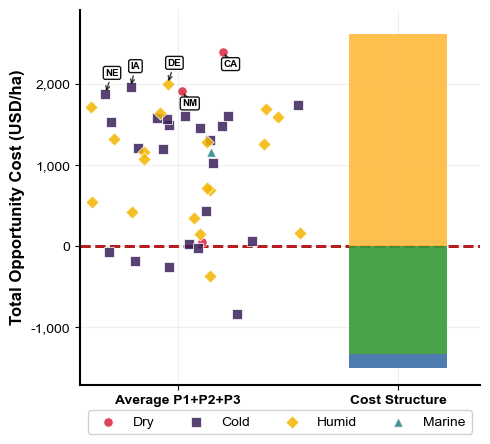

统一坐标系机会成本分析图创建完成！


In [82]:
def create_opportunity_cost_unified(df_economic, df_agricultural_npv, df_afforestation_npv, df_natural_npv, 
                                    us_states_4326, df_climate_zone):
    """
    优化版机会成本分析图：散点图+柱状堆积图
    重点优化计算效率
    去掉双Y轴，所有内容绘制在同一主坐标轴上
    """
    
    # 设置字体
    plt.rcParams['font.family'] = 'Arial'
    
    print("开始优化版机会成本分析...")
    
    # 1. 数据预处理 - 向量化操作
    print("1. 数据预处理...")
    
    # RCP映射 - 使用字典映射替代apply
    rcp_mapping = {
        'C1': 'RCP2.6', 'C2': 'RCP2.6', 'C3': 'RCP2.6',
        'C4': 'RCP4.5', 'C5': 'RCP6.0', 
        'C6': 'RCP8.5', 'C7': 'RCP8.5', 'C8': 'RCP8.5'
    }
    
    # 2. 高效处理df_economic
    print("2. 处理经济数据...")
    
    # 使用向量化操作替代apply
    df_economic_2050 = df_economic[df_economic['analysis_year'] == 2050].copy()
    
    # 向量化RCP映射
    df_economic_2050['mapped_rcp'] = df_economic_2050['pv_category'].map(rcp_mapping)
    
    # 向量化政策分组
    df_economic_2050['policy_group'] = df_economic_2050['policy_category'].str.extract(r'(P[123])')[0]
    
    # 过滤有效数据
    valid_mask = df_economic_2050['policy_group'].isin(['P1', 'P2', 'P3'])
    df_economic_2050 = df_economic_2050[valid_mask]
    
    # 3. 高效聚合 - 使用groupby.agg一次性计算
    print("3. 数据聚合...")
    
    agg_cols = ['lat', 'lon', 'policy_category', 'policy_group', 'mapped_rcp']
    df_economic_agg = df_economic_2050.groupby(agg_cols).agg({
        'net_npv_usd': 'mean',
        'net_cost_usd': 'mean'
    }).reset_index()
    
    print(f"聚合后数据: {len(df_economic_agg)} 行")
    
    # 4. 处理机会成本数据 - 先统一列名再处理
    print("4. 处理机会成本数据...")
    
    # 先统一列名为小写，避免大小写问题
    opp_data = {}
    # tqdm用于显示进度条
    for name, df in tqdm([('agri', df_agricultural_npv), ('affor', df_afforestation_npv), ('nat', df_natural_npv)], desc="处理机会成本数据"):
        df_temp = df.copy()
        # 统一列名为小写
        df_temp.columns = df_temp.columns.str.lower()
        
        # 现在可以安全地访问小写列名
        df_temp = df_temp[df_temp['analysis_year'] == 2050][['lat', 'lon', 'rcp_category', 'cumulative_npv_usd']].copy()
        df_temp.columns = ['lat', 'lon', 'rcp_category', f'{name}_npv']
        opp_data[name] = df_temp
    
    # 5. 高效合并机会成本数据
    print("5. 合并机会成本数据...")
    
    # 使用reduce进行多表合并
    from functools import reduce
    # tqdm用于显示合并进度
    opp_data_list = list(opp_data.values())
    df_opp_merged = opp_data_list[0]
    for right in tqdm(opp_data_list[1:], desc="合并机会成本数据"):
        df_opp_merged = pd.merge(df_opp_merged, right, on=['lat', 'lon', 'rcp_category'], how='inner')
    
    print(f"合并后的机会成本数据: {len(df_opp_merged)} 行")
    
    # 6. 最终合并 - 使用merge_asof优化大数据集合并
    print("6. 最终数据合并...")
    
    # 先排序以提高merge效率
    df_economic_agg = df_economic_agg.sort_values(['lat', 'lon', 'mapped_rcp'])
    df_opp_merged = df_opp_merged.sort_values(['lat', 'lon', 'rcp_category'])
    
    df_final = pd.merge(df_economic_agg, df_opp_merged, 
                        left_on=['lat', 'lon', 'mapped_rcp'], 
                        right_on=['lat', 'lon', 'rcp_category'], 
                        how='inner')
    
    print(f"最终数据: {len(df_final)} 行")
    
    # 7. 地理信息匹配 - 优化空间连接
    print("7. 地理信息匹配...")
    
    # 创建Point几何对象 - 向量化
    geometry = gpd.points_from_xy(df_final['lon'], df_final['lat'])
    gdf_final = gpd.GeoDataFrame(df_final, geometry=geometry, crs='EPSG:4326')
    
    # 优化空间连接 - 只保留必要的列
    states_simple = us_states_4326[['STUSPS', 'geometry']].copy()
    
    # 执行空间连接
    gdf_with_states = gpd.sjoin(gdf_final, states_simple, how='left', predicate='within')
    
    # 8. 气候区域匹配 - 优化匹配逻辑
    print("8. 气候区域匹配...")
    
    # 创建州名映射字典
    state_climate_map = dict(zip(df_climate_zone['State'], df_climate_zone['BA Climate Zone']))
    
    # 气候区域合并映射
    climate_merge_map = {
        'Hot-Dry': 'Dry', 'Mixed-Dry': 'Dry',
        'Cold': 'Cold', 'Very Cold': 'Cold',
        'Hot-Humid': 'Humid', 'Mixed-Humid': 'Humid',
        'Marine': 'Marine', 'Subarctic': 'Subarctic'
    }
    
    # 向量化气候区域匹配
    gdf_with_states['climate_zone'] = gdf_with_states['STUSPS'].map(state_climate_map)
    gdf_with_states['climate_zone_merged'] = gdf_with_states['climate_zone'].map(climate_merge_map)
    
    # 打印匹配情况
    print("气候区域匹配情况:")
    print(gdf_with_states['climate_zone_merged'].value_counts())
    
    # 9. 计算州级别的统计量
    print("9. 计算州级别统计量...")
    
    # 按州和政策组聚合，计算每个州的平均机会成本
    state_policy_stats = gdf_with_states.groupby(['STUSPS', 'policy_group', 'climate_zone_merged']).agg({
        'agri_npv': 'mean',
        'affor_npv': 'mean',
        'nat_npv': 'mean'
    }).reset_index()
    
    # 计算每个州在每个政策组下的总机会成本
    state_policy_stats['total_opportunity_cost'] = (
        state_policy_stats['agri_npv'] + 
        state_policy_stats['affor_npv'] + 
        state_policy_stats['nat_npv']
    )
    
    print("州级别统计结果:")
    print(state_policy_stats.head(10))
    
    # 10. 绘图数据准备 - 进一步聚合三个政策组
    print("10. 准备绘图数据...")
    
    # 为散点图准备数据 - 按州和气候区域聚合，计算三个政策组的均值和标准差
    scatter_data_aggregated = state_policy_stats.groupby(['STUSPS', 'climate_zone_merged']).agg({
        'total_opportunity_cost': ['mean', 'std', 'count']
    }).reset_index()
    
    # 扁平化列名
    scatter_data_aggregated.columns = ['STUSPS', 'climate_zone_merged', 'mean_cost', 'std_cost', 'count']
    
    # 计算堆积图数据 - 计算三个政策组的整体均值和标准差
    stats_overall = gdf_with_states.groupby('policy_group').agg({
        'agri_npv': ['count', 'mean', 'std'],
        'affor_npv': ['count', 'mean', 'std'],
        'nat_npv': ['count', 'mean', 'std']
    }).round(2)
    
    # 扁平化列名
    stats_overall.columns = [f"{col[1]}_{col[0]}" if col[1] != '' else col[0] for col in stats_overall.columns]
    
    # 计算整体均值（三个政策组的平均）
    overall_means = stats_overall.mean()
    
    # 计算整体标准差（三个政策组的标准差）
    overall_stds = stats_overall.std()
    
    print("整体统计结果:")
    print(f"Agricultural NPV: {overall_means['mean_agri_npv']:.2f} ± {overall_stds['mean_agri_npv']:.2f}")
    print(f"Afforestation NPV: {overall_means['mean_affor_npv']:.2f} ± {overall_stds['mean_affor_npv']:.2f}")
    print(f"Natural NPV: {overall_means['mean_nat_npv']:.2f} ± {overall_stds['mean_nat_npv']:.2f}")
    
    # 分离正值和负值（使用整体均值）
    positive_data = np.array([
        [max(0, overall_means['mean_agri_npv']),
         max(0, overall_means['mean_affor_npv']),
         max(0, overall_means['mean_nat_npv'])]
    ])
    
    negative_data = np.array([
        [min(0, overall_means['mean_agri_npv']),
         min(0, overall_means['mean_affor_npv']),
         min(0, overall_means['mean_nat_npv'])]
    ])
    
    # 计算误差棒数据
    error_data = np.array([
        [overall_stds['mean_agri_npv'],
         overall_stds['mean_affor_npv'],
         overall_stds['mean_nat_npv']]
    ])
    

    
    # 11. 创建统一坐标系图形
    print("11. 创建统一坐标系图形...")
    
    # 调整图幅为更窄的比例，例如4x4
    fig, ax = plt.subplots(figsize=(5, 4.5))
    
    # 绘制散点图（单个组合）
    print("绘制散点图...")
    plot_aggregated_scatter(ax, scatter_data_aggregated)
    
    # 绘制堆叠图（直接在主坐标轴ax上，去掉双Y轴）
    print("绘制堆叠图...")
    plot_overall_stacked_bars(ax, positive_data, negative_data, error_data)
    
    plt.tight_layout()
    return fig, ax



def plot_aggregated_scatter(ax, scatter_data_aggregated):
    """聚合散点 + 稳定的 Top5 标签（可复现、避免飞出与重叠）"""
    climate_styles = {
        'Dry':       {'color': '#D7263D', 'marker': 'o'},
        'Cold':      {'color': '#3B1F5A', 'marker': 's'},
        'Humid':     {'color': '#F4B400', 'marker': 'D'},
        'Marine':    {'color': '#218380', 'marker': '^'},
        'Subarctic': {'color': '#1B9AAA', 'marker': 'P'},
    }

    # —— 1) 更紧凑的抖动（点与标签共享），加右移 x_offset —— 
    rng = np.random.default_rng(7)  # 固定种子，保证每次一致
    x_offset = 0.25  # 向右移动，让散点图更靠右
    x_center = x_offset
    jitter_w = 0.11  # 抖动范围缩小，更紧凑
    state_xy = {}  # STUSPS -> (x, y)
    legend_handles = []
    legend_labels = []
    all_xs = []

    for cz, style in climate_styles.items():
        sub = scatter_data_aggregated[scatter_data_aggregated['climate_zone_merged'] == cz]
        if sub.empty:
            continue
        
        xs, ys = [], []
        for _, r in sub.iterrows():
            x = x_center + rng.normal(0, jitter_w)
            y = float(r['mean_cost'])
            state_xy[r['STUSPS']] = (x, y)
            xs.append(x); ys.append(y)
        all_xs.extend(xs)
        scatter = ax.scatter(
            xs, ys,
            c=style['color'], marker=style['marker'], s=45, alpha=0.85,
            edgecolors='white', linewidth=0.6,
            zorder=3
        )
        legend_handles.append(scatter)
        legend_labels.append(cz)

    # —— 2) y 轴范围（给标签留头部空隙）——
    if state_xy:
        ymax = max(y for _, y in state_xy.values())
    else:
        ymax = 1.0
    ymin = 0.0
    pad = max(120.0, 0.12 * (ymax - ymin))
    ax.set_ylim(ymin, ymax + pad)

    # x 轴设置：确保标签在散点图中心
    if all_xs:
        scatter_center = float(np.mean(all_xs))  # 散点图的真实中心
    else:
        scatter_center = x_offset
    
    # 设置X轴刻度，确保"Average P1+P2+P3"标签在散点图中心
    ax.set_xticks([scatter_center])
    ax.set_xticklabels(['Average P1+P2+P3'], fontsize=12, fontweight='bold')
    
    # 设置X轴范围，确保散点图居中显示，给右侧留出足够空间
    # x_range = 0.25  # 散点图的总宽度，稍微缩小
    # ax.set_xlim(scatter_center - x_range/2, scatter_center + x_range/2)
    
    ax.set_ylabel('Total Opportunity Cost (USD/ha)', fontsize=10, fontweight='bold')
    ax.axhline(0, color='#B20000', linestyle='--', alpha=1, linewidth=2.0, zorder=1)
    ax.grid(True, alpha=0.2, zorder=0)

    # —— 3) Top5 标签：就近择优 + 防重叠 + 保持在轴域内 —— #
    if state_xy:
        top5 = sorted(state_xy.items(), key=lambda kv: kv[1][1], reverse=True)[:5]
        candidates = [(10,10), (14,0), (10,-10),
                      (-10,10), (-14,0), (-10,-10),
                      (0,12), (0,-12)]
        lab_w_pt, lab_h_pt = 22, 14
        dpi = ax.figure.dpi
        pt2px = dpi / 72.0
        placed = []
        ax_bbox_px = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
        ax_bbox_px = [ax_bbox_px.x0*dpi, ax_bbox_px.y0*dpi, ax_bbox_px.x1*dpi, ax_bbox_px.y1*dpi]

        def rect_of(xd, yd, dx_pt, dy_pt):
            x_px, y_px = ax.transData.transform((xd, yd))
            dx_px, dy_px = dx_pt*pt2px, dy_pt*pt2px
            w_px, h_px = lab_w_pt*pt2px, lab_h_pt*pt2px
            return [x_px+dx_px, y_px+dy_px, x_px+dx_px+w_px, y_px+dy_px+h_px]

        def iou_with_placed(R):
            x0,y0,x1,y1 = R
            area = 0.0
            for A in placed:
                ax0,ay0,ax1,ay1 = A
                ix0, iy0 = max(x0,ax0), max(y0,ay0)
                ix1, iy1 = min(x1,ax1), min(y1,ay1)
                if ix1>ix0 and iy1>iy0:
                    area += (ix1-ix0)*(iy1-iy0)
            return area

        def inside_axes(R):
            pad = 2*pt2px
            x0,y0,x1,y1 = R
            ax0,ay0,ax1,ay1 = ax_bbox_px
            return (x0>=ax0+pad) and (y0>=ay0+pad) and (x1<=ax1-pad) and (y1<=ay1-pad)

        for st,(x,y) in top5:
            best = None
            best_score = (1e18, 1e18)
            for dx,dy in candidates:
                R = rect_of(x,y,dx,dy)
                overlap = iou_with_placed(R)
                dist = abs(dx)+abs(dy)
                if not inside_axes(R):
                    overlap += 1e12
                score = (overlap, dist)
                if score < best_score:
                    best_score, best = score, (dx,dy,R)

            dx,dy,R = best
            placed.append(R)
            ax.annotate(
                st, xy=(x,y),
                xytext=(dx,dy), textcoords='offset points',
                fontsize=7, fontweight='bold',
                ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.92),
                arrowprops=dict(arrowstyle='->', lw=1.0, color='black', alpha=0.75),
                zorder=4, clip_on=False
            )

    ax.legend(
        legend_handles, legend_labels,
        fontsize=10,
        loc='lower center', bbox_to_anchor=(0.5, -0.15),
        framealpha=0.9, ncol=5, markerscale=1.0
    )

    # 只保留左侧和底部的边框线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')



def plot_overall_stacked_bars(ax, positive_data, negative_data, error_data):
    """绘制整体堆叠图，显示原值和误差棒（直接在主坐标轴ax上）"""
    colors = ['#FFBA3D', '#359A35', '#3A6EA5']  
    categories = ['Agricultural', 'Afforestation', 'Natural']
    x_center = 0.55  # 调整位置，让两个图更近
    width = 0.15  # 调整柱宽

    # 正值堆叠
    bottom_positive = 0
    for i, category in enumerate(categories):
        value = positive_data[0, i]
        error = error_data[0, i]
        color = colors[i]
        if value > 0:
            ax.bar(x_center, value, width, bottom=bottom_positive, 
                   color=color, alpha=0.9, label=f'{category} (+)', zorder=2)
            bottom_positive += value

    # 负值堆叠
    bottom_negative = 0
    for i, category in enumerate(categories):
        value = negative_data[0, i]
        error = error_data[0, i]
        color = colors[i]
        if value < 0:
            ax.bar(x_center, value, width, bottom=bottom_negative, 
                   color=color, alpha=0.9, label=f'{category} (-)', zorder=2)
            bottom_negative += value

    # 计算总和
    pos_total = positive_data[0, :].sum()
    neg_total = negative_data[0, :].sum()

    # 设置X轴标签
    scatter_center = ax.get_xticks()[0]  # 从散点图获取中心位置
    xticks = [scatter_center, x_center]
    xticklabels = ['Average P1+P2+P3', 'Cost Structure']
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=10, fontweight='bold')

    # 现在统一设置X轴范围，确保两个图都能正确显示
    x_min = min(scatter_center - 0.15, x_center - width/2 - 0.05)
    x_max = max(scatter_center + 0.15, x_center + width/2 + 0.05)
    ax.set_xlim(x_min, x_max)

    # Y轴标签
    ax.set_ylabel('Total Opportunity Cost (USD/ha)', fontsize=12, fontweight='bold')

    # Y轴范围和格式
    y_min, y_max = ax.get_ylim()
    y_min = min(y_min, neg_total - 200)
    y_max = max(y_max, pos_total + 300)
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_formatter(lambda x, _: f'{int(x):,}')

    # 只保留左侧和底部的边框线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')


print("开始执行统一坐标系分析...")
fig_unified, ax_unified = create_opportunity_cost_unified(
    df_economic, df_agricultural_npv, df_afforestation_npv, df_natural_npv,
    us_states_4326, df_climate_zone
)

# 保存图片
fig_unified.savefig('figure/US_figure/Figure_opportunity_cost_unified.eps', 
                    bbox_inches='tight', dpi=300, format='eps')
fig_unified.savefig('figure/US_figure/Figure_opportunity_cost_unified.png', 
                    bbox_inches='tight', dpi=300, format='png')

plt.show()
print("统一坐标系机会成本分析图创建完成！")

In [83]:
df_economic

lat         lon pv_category      pv_model  \
0         31.320833 -105.929170          C1    REMIND 2.1   
1         31.329166 -105.929170          C1    REMIND 2.1   
2         31.337500 -105.937500          C1    REMIND 2.1   
3         31.337500 -105.929170          C1    REMIND 2.1   
4         31.345833 -105.937500          C1    REMIND 2.1   
...             ...         ...         ...           ...   
68880915  46.937500  -67.920830          C7  TIAM-ECN 1.1   
68880916  47.145832  -67.962500          C7  TIAM-ECN 1.1   
68880917  47.237500  -68.620834          C7  TIAM-ECN 1.1   
68880918  47.254166  -68.354164          C7  TIAM-ECN 1.1   
68880919  47.262500  -68.379166          C7  TIAM-ECN 1.1   

                   pv_scenario policy_category rcp_category   net_npv_usd  \
0         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364320e+06   
1         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364268e+06   
2         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364232e+06   
3         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364223e+06   
4         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364196e+06   
...                        ...             ...          ...           ...   
68880915        EN_NPi2100_COV             P1b       RCP8.5  4.447125e+06   
68880916        EN_NPi2100_COV             P1b       RCP8.5  4.148731e+06   
68880917        EN_NPi2100_COV             P1b       RCP8.5  4.294753e+06   
68880918        EN_NPi2100_COV             P1b       RCP8.5  4.331141e+06   
68880919        EN_NPi2100_COV             P1b       RCP8.5  4.147186e+06   

          net_cost_usd  analysis_year  
0         2.364320e+06           2020  
1         2.364268e+06           2020  
2         2.364232e+06           2020  
3         2.364223e+06           2020  
4         2.364196e+06           2020  
...                ...            ...  
68880915  4.654054e+06           2050  
68880916  4.654008e+06           2050  
68880917  4.654032e+06           2050  
68880918  4.654020e+06           2050  
68880919  4.654010e+06           2050  

[68880920 rows x 10 columns]

### 4.3 图3：多情景的政策累积路线

进一步细分不同政策情景（P1,P2,P3, average）之下的单目标累积路线+各个州average policy情况下的柱状堆积图

具体逻辑是：
第一步：数据准备

（1），按照create_opportunity_cost_unified函数的P1,P2,P3 group方法，只关注analysis_year==2050，并为每个pixel挂上states_simple = us_states_4326[['NAME','STUSPS', 'geometry']].copy()字段。在这个操作中，实际上不需要挂上df_natural,df_agri，df_forest等成本信息，只要关注net_npv_usd的值就可以了

（2），聚合子类对应得出每个pixel中['net_npv_usd'] P1.mean, P2.mean, P3.mean, 以及 P1,P2,P3所有政策group的total.mean（这里实际上存在P4，在计算mean的时候也要考虑这个group，但是由于其样本过少，不参与polciy group独立分析，不过要加入总体均值）。

第三，按照area_data = df_net_benefit[['lat', 'lon', 'area_m2']].copy()中的lat lon字段进行merge赋予pixel面积信息。并且利用P1.mean, P2.mean, P3.mean，total.mean针对每个pixel计算['area_m2']*四个值等到累积收益。

第二步：计算与绘图

（1）按照create_cross_target_analysis函数进行累积，但是不需要按照ccd进行排序，以total.mean为x轴基准进行排序累积（要求从分位数从高到低进行累积）。最终得到四条曲线。（从最大值累加到最小值，但是x轴额外设置，需要固定类似3%，10%，...100%的priority percentile排列），由此生成polciy_group P1, P2, P3三个政策类别的累积路线图。

（2）按照各个STUSPS挂上的state信息，再以州为单位，每个pixel按照total.mean在各自州内（从分位数从高到低进行累积）。绘制州的堆积柱状图（分bin可以跟着分位数的轴来决定、尽量保持连续）






布局：
所有字体arial ； X、Y轴要求linewith==2，xtick fonsize==12 , bold ； y tick fontsize ==12 , 不用bold加粗。图幅控制figsize控制在8,4。




开始执行政策情景累积分析（修正版）...
开始政策情景累积分析（修正版）...
1. 数据预处理...
2. 按pixel聚合数据...
聚合后数据: 64982 行
数据准备完成
面积单位: 公顷 (ha)
数据范围检查:
  P1: -2.58e+06 到 -4.46e+04
  P2: -1.69e+06 到 1.86e+06
  P3: 8.84e+04 到 4.85e+06
  total_mean: -1.44e+06 到 2.18e+06
3. 开始绘图...
绘制累积路线图...
P1累积值范围: -7.21e+12 到 0.00e+00
P2累积值范围: -1.67e+12 到 3.86e+11
P3累积值范围: 0.00e+00 到 8.07e+12
Total累积值范围: -4.59e+11 到 6.98e+11
Total累积标准误: 1.89e+04
绘制州堆积图...

=== 总体标准误信息 ===
Total累积标准误: 1.89e+04
Total累积标准误 (显示单位): 0.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


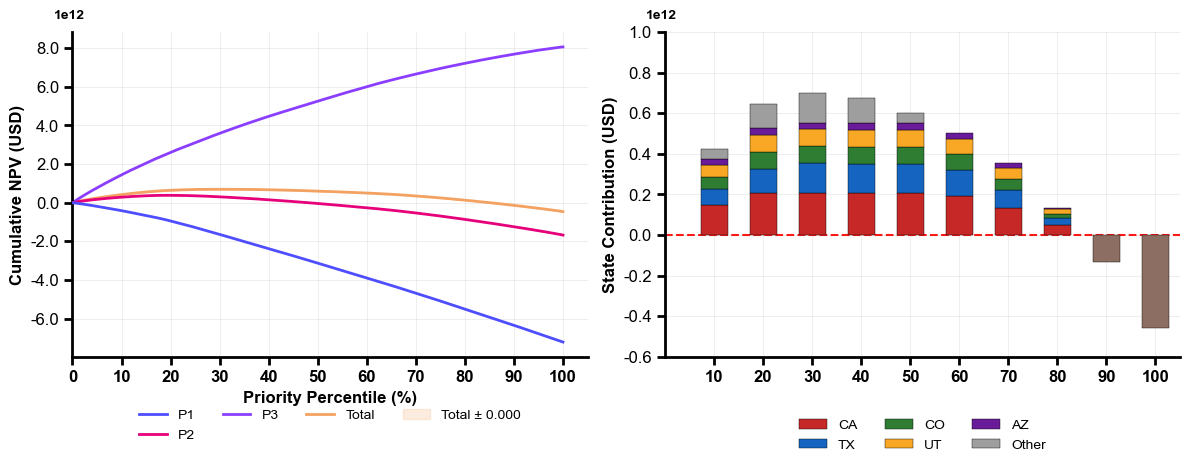

政策情景累积分析图（修正版）创建完成！


In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def create_policy_cumulative_analysis_simple(df_economic, us_states_4326, df_net_benefit):
    """
    创建政策情景累积分析图：P1,P2,P3累积路线 + 各州柱状堆积图
    修正版本：确保与create_cross_target_analysis的数据处理一致
    """
    # 设置字体
    plt.rcParams['font.family'] = 'Arial'
    
    print("开始政策情景累积分析（修正版）...")
    
    # 第一步：数据准备
    print("1. 数据预处理...")
    
    # RCP映射
    rcp_mapping = {
        'C1': 'RCP2.6', 'C2': 'RCP2.6', 'C3': 'RCP2.6',
        'C4': 'RCP4.5', 'C5': 'RCP6.0', 
        'C6': 'RCP8.5', 'C7': 'RCP8.5', 'C8': 'RCP8.5'
    }
    
    # 处理df_economic，只关注net_npv_usd
    df_economic_2050 = df_economic[df_economic['analysis_year'] == 2050].copy()
    df_economic_2050['mapped_rcp'] = df_economic_2050['pv_category'].map(rcp_mapping)
    df_economic_2050['policy_group'] = df_economic_2050['policy_category'].str.extract(r'(P[1234])')[0]
    
    # 过滤有效数据（包括P4用于总体均值计算）
    valid_mask = df_economic_2050['policy_group'].isin(['P1', 'P2', 'P3', 'P4'])
    df_economic_2050 = df_economic_2050[valid_mask]
    
    # 关键修正：先按pixel聚合，再处理policy_group
    print("2. 按pixel聚合数据...")
    
    # 先按lat, lon聚合所有policy_group的net_npv_usd
    pixel_agg = df_economic_2050.groupby(['lat', 'lon']).agg({
        'net_npv_usd': 'mean'  # 每个pixel的平均值
    }).reset_index()
    
    # 再按policy_group聚合
    policy_agg = df_economic_2050.groupby(['lat', 'lon', 'policy_group']).agg({
        'net_npv_usd': 'mean'
    }).reset_index()
    
    # 透视表：每个pixel的P1, P2, P3, total均值
    pixel_pivot = policy_agg.pivot_table(
        index=['lat', 'lon'], 
        columns='policy_group', 
        values='net_npv_usd', 
        aggfunc='mean'
    ).reset_index()
    
    # 添加总体均值（每个pixel的平均值）
    pixel_pivot = pixel_pivot.merge(pixel_agg, on=['lat', 'lon'], how='inner')
    pixel_pivot.rename(columns={'net_npv_usd': 'total_mean'}, inplace=True)
    
    print(f"聚合后数据: {len(pixel_pivot)} 行")
    
    # 添加面积信息
    area_data = df_net_benefit[['lat', 'lon', 'area_m2']].copy()
    pixel_final = pixel_pivot.merge(area_data, on=['lat', 'lon'], how='inner')
    
    # 关键修正：面积单位转换，与create_cross_target_analysis保持一致
    pixel_final['area_ha'] = pixel_final['area_m2'] / 10000  # 转换为公顷
    
    # 计算累积收益（面积 * net_npv_usd）- 使用公顷单位
    for col in ['P1', 'P2', 'P3', 'total_mean']:
        if col in pixel_final.columns:
            pixel_final[f'{col}_cumulative'] = pixel_final[col] * pixel_final['area_ha']
    
    print("数据准备完成")
    print(f"面积单位: 公顷 (ha)")
    print(f"数据范围检查:")
    for col in ['P1', 'P2', 'P3', 'total_mean']:
        if col in pixel_final.columns:
            print(f"  {col}: {pixel_final[col].min():.2e} 到 {pixel_final[col].max():.2e}")
    
    # 第二步：计算与绘图
    print("3. 开始绘图...")
    
    # 创建图形：累积路线图 + 州堆积图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # 累积路线图
    print("绘制累积路线图...")
    total_std_error = plot_cumulative_curves_simple(ax1, pixel_final)  # 接收返回值
    
    # 州堆积图
    print("绘制州堆积图...")
    plot_state_stacked_bars_combined(ax2, pixel_final, us_states_4326, None, x_max=105)
    
    # 在主函数中也打印标准误信息
    print(f"\n=== 总体标准误信息 ===")
    print(f"Total累积标准误: {total_std_error:.2e}")
    print(f"Total累积标准误 (显示单位): {total_std_error/1e12:.6f}")
    
    plt.tight_layout()
    # 去掉上方和右边框线，对两幅图执行相同操作
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    return fig, (ax1, ax2)

def plot_cumulative_curves_simple(ax, pixel_final):
    """绘制P1, P2, P3累积路线图，并计算total的标准误"""
    # 按total_mean排序（从高到低）
    sorted_data = pixel_final.sort_values('total_mean_cumulative', ascending=False)
    
    # 计算累积百分比
    total_pixels = len(sorted_data)
    cumulative_percentage = np.arange(1, total_pixels + 1) / total_pixels * 100
    
    # 计算累积值
    p1_values = sorted_data['P1_cumulative'].fillna(0)
    p2_values = sorted_data['P2_cumulative'].fillna(0)
    p3_values = sorted_data['P3_cumulative'].fillna(0)
    total_values = sorted_data['total_mean_cumulative'].fillna(0)
    
    # 累积计算
    p1_cumulative = np.cumsum(p1_values)
    p2_cumulative = np.cumsum(p2_values)
    p3_cumulative = np.cumsum(p3_values)
    total_cumulative = np.cumsum(total_values)
    
    # 添加起始点
    cumulative_percentage = np.concatenate([[0], cumulative_percentage])
    p1_cumulative = np.concatenate([[0], p1_cumulative])
    p2_cumulative = np.concatenate([[0], p2_cumulative])
    p3_cumulative = np.concatenate([[0], p3_cumulative])
    total_cumulative = np.concatenate([[0], total_cumulative])
    
    # 计算total累积的标准误
    def calculate_cumulative_std_error(cumulative_values, cumulative_percentage):
        """基于样本贡献计算累积值的标准误"""
        # 将百分比转换为[0,1]区间
        x_01 = cumulative_percentage / 100.0
        
        # 计算每个小段的贡献
        n_segments = len(cumulative_values) - 1
        if n_segments > 1:
            segment_contributions = []
            for i in range(n_segments):
                dx = x_01[i+1] - x_01[i]
                avg_y = (cumulative_values[i+1] + cumulative_values[i]) / 2.0
                contribution = avg_y * dx
                segment_contributions.append(contribution)
            
            # 基于贡献计算标准误
            contribution_std = np.std(segment_contributions, ddof=1)
            contribution_std_error = contribution_std / np.sqrt(n_segments)
        else:
            contribution_std_error = 0
        
        return contribution_std_error
    
    # 计算total累积的标准误
    total_std_error = calculate_cumulative_std_error(total_cumulative, cumulative_percentage)
    
    # 打印累积值范围和标准误
    print(f"P1累积值范围: {p1_cumulative.min():.2e} 到 {p1_cumulative.max():.2e}")
    print(f"P2累积值范围: {p2_cumulative.min():.2e} 到 {p2_cumulative.max():.2e}")
    print(f"P3累积值范围: {p3_cumulative.min():.2e} 到 {p3_cumulative.max():.2e}")
    print(f"Total累积值范围: {total_cumulative.min():.2e} 到 {total_cumulative.max():.2e}")
    print(f"Total累积标准误: {total_std_error:.2e}")
    
    # 使用自定义颜色
    colors = {
        'P1': '#4E4EFF',
        'P2': '#E6007A',
        'P3': '#8B3EFF',
        'Total': '#F4A261'
    }
    
    # 绘制主要曲线
    ax.plot(cumulative_percentage, p1_cumulative/1e12, color=colors['P1'], linewidth=2, label='P1', zorder=4)
    ax.plot(cumulative_percentage, p2_cumulative/1e12, color=colors['P2'], linewidth=2, label='P2', zorder=3)
    ax.plot(cumulative_percentage, p3_cumulative/1e12, color=colors['P3'], linewidth=2, label='P3', zorder=2)
    ax.plot(cumulative_percentage, total_cumulative/1e12, color=colors['Total'], linewidth=2, label='Total', zorder=1)
    
    # 添加Total曲线的标准误区间（阴影区域）
    total_std_error_display = total_std_error / 1e12  # 转换为显示单位
    ax.fill_between(cumulative_percentage, 
                    (total_cumulative/1e12) - total_std_error_display,
                    (total_cumulative/1e12) + total_std_error_display,
                    color=colors['Total'], alpha=0.2, zorder=0, 
                    label=f'Total ± {total_std_error_display:.3f}')
    
    # 设置X轴，Xmax=105但只显示到100
    key_percentages = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    ax.set_xticks(key_percentages)
    ax.set_xticklabels([f'{p}' for p in key_percentages], fontsize=12, fontweight='bold')
    ax.set_xlim(0, 105)  # 留出呼吸感但不显示105标签
    ax.set_xlabel('Priority Percentile (%)', fontsize=12, fontweight='bold')
    
    # 设置Y轴
    ax.set_ylabel('Cumulative NPV (USD)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelsize=12)
    
    # Y轴标签显示为普通数字（因为已经除以1e12了）
    def sci_fmt_left(x, pos):
        return f'{x:.1f}'
    ax.yaxis.set_major_formatter(FuncFormatter(sci_fmt_left))
    
    # 在Y轴顶部加1e12的单位标注
    ax.annotate('1e12', xy=(-0.05, 1.05), xycoords='axes fraction', xytext=(5, 0),
                textcoords='offset points', ha='left', va='center',
                fontsize=10, fontweight='bold', color='black')
    
    # 网格和样式
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)
    
    # 坐标轴样式
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
    # 去掉上方和右边框线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.tick_params(axis='both', which='major', width=2, size=6)
    
    # 图例
    ax.legend(fontsize=10, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4, frameon=False, title=None)
    
    # 返回标准误信息供外部使用
    return total_std_error
    

def plot_state_stacked_bars_combined(ax, pixel_final, us_states_4326, left_y_limits, x_max=105):
    """
    右轴：按分位点动态堆积
      - 若 net >= 0：只画正柱，并按 r = net/pos 等比压缩（负值不单独显示）
      - 若 net < 0 ：正柱为 0；负柱开始向下累计，总高度 = -net，
                    每个负州用 g = (-net)/|neg_sum| 等比分摊；负柱统一颜色
    这样每个分位点柱总高度 == 左轴 Total 曲线在该分位点的累计值。
    x_max: x轴最大值，保证柱子不被截断
    """
    # 1) 全局排序 + 空间连接得到州
    base = pixel_final.sort_values('total_mean_cumulative', ascending=False).reset_index(drop=True)
    gdf = gpd.GeoDataFrame(
        base, geometry=gpd.points_from_xy(base['lon'], base['lat']), crs='EPSG:4326'
    )
    gdf = gpd.sjoin(gdf, us_states_4326[['STUSPS','geometry']], how='left', predicate='within')
    gdf['STUSPS'] = gdf['STUSPS'].fillna('UNK')

    # 2) Top-5 颜色（正柱用固定色），其余合并为 Other；负柱统一色
    total_by_state = gdf.groupby('STUSPS')['total_mean_cumulative'].sum().sort_values(ascending=False)
    top_states = list(total_by_state.index[:5])
    pos_palette = ['#C62828','#1565C0','#2E7D32','#F9A825','#6A1B9A']  # 正柱：CA/TX/...
    pos_color = {st: pos_palette[i % len(pos_palette)] for i, st in enumerate(top_states)}
    pos_color['Other'] = '#9E9E9E'
    neg_color = '#8D6E63'  # 负柱统一颜色（可改）

    key_percentages = [10,20,30,40,50,60,70,80,90,100]
    w = 5.5  # 柱宽
    n = len(gdf)

    y2_min_seen, y2_max_seen = 0.0, 0.0

    # 用于legend的容器
    legend_handles = []

    for p in key_percentages:
        k = max(1, int(np.ceil(p/100.0 * n)))
        head = gdf.iloc[:k]
        s = head.groupby('STUSPS')['total_mean_cumulative'].sum()

        # Top5 + Other
        vals = {st: float(s.get(st, 0.0)) for st in top_states}
        vals['Other'] = float(s[~s.index.isin(top_states)].sum())

        pos_items = [(st, v) for st, v in vals.items() if v > 0]
        neg_items = [(st, v) for st, v in vals.items() if v < 0]

        pos_sum = sum(v for _, v in pos_items)                 # >0
        neg_sum = sum(v for _, v in neg_items)                 # <0 或 0
        net = pos_sum + neg_sum                                # 可能正/负/0

        if net >= 0:
            # 只画正柱，按 r = net/pos 压缩
            if pos_sum > 0:
                r = net / pos_sum
                r = max(0.0, min(1.0, r))
                bottom = 0.0
                for st, v in pos_items:
                    h = v * r                                 # 压缩后高度
                    if h <= 0: 
                        continue
                    # Y值除以1e12进行显示
                    bar = ax.bar(p, h/1e12, width=w, bottom=bottom,
                           color=pos_color.get(st, '#9E9E9E'),
                           edgecolor='black', linewidth=0.3, zorder=3)
                    # 只在第一个分位点收集legend
                    if p == key_percentages[0]:
                        legend_handles.append((bar[0], st))
                    bottom += h/1e12
                y2_max_seen = max(y2_max_seen, bottom)
            # 负值不单独显示（它们"吃掉"了正值）
        else:
            # 正柱清零；负柱向下累计。分摊系数 g = (-net)/|neg_sum|
            need_down = -net                                  # >0
            if neg_sum < 0:
                g = need_down / abs(neg_sum)                 # in [0,1]
            else:
                g = 0.0

            bottom_neg = 0.0
            for idx, (st, v) in enumerate(neg_items):
                h = -abs(v) * g                              # 负数；向下画
                if h == 0:
                    continue
                bar = ax.bar(p, h/1e12, width=w, bottom=bottom_neg,
                       color=neg_color, edgecolor='black', linewidth=0.3, zorder=3)
                # 只在第一个负柱收集legend
                if p == key_percentages[0] and idx == 0:
                    legend_handles.append((bar[0], 'Negative (All States)'))
                bottom_neg += h/1e12                         # 更负
            y2_min_seen = min(y2_min_seen, bottom_neg)

    # —— 右轴范围：Y=0与左轴对齐，红色虚线标注，固定Ymin/Ymax —— #
    ax.set_ylim(-0.6, 1.0)  # 因为已经除以1e12了
    ax.axhline(0, color='red', lw=1.5, ls='--', alpha=0.9, zorder=2)

    # 优化x轴，右侧多留空间，防止柱子被截断
    ax.set_xlim(0, x_max)

    ax.set_ylabel('State Contribution (USD)', fontsize=12, fontweight='bold', color='black')
    ax.tick_params(axis='y', labelsize=12, colors='black')

    # Y轴标签显示为普通数字（因为已经除以1e12了）
    def sci_fmt(x, pos):
        return f'{x:.1f}'
    ax.yaxis.set_major_formatter(FuncFormatter(sci_fmt))
    
    # 在Y轴顶部加1e12的单位标注（与左图风格一致）
    ax.annotate('1e12', xy=(-0.05, 1.05), xycoords='axes fraction', xytext=(5, 0),
                textcoords='offset points', ha='left', va='center',
                fontsize=10, fontweight='bold', color='black')
    
    # 设置X轴，只显示到100%，但范围到105
    ax.set_xticks(key_percentages)
    ax.set_xticklabels([f'{p}' for p in key_percentages], fontsize=12, fontweight='bold')
    # ax.set_xlabel('Priority Percentile (%)', fontsize=12, fontweight='bold')

    # 网格和样式
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)
    
    # 坐标轴样式
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
    # 去掉上方和右边框线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.tick_params(axis='both', which='major', width=2, size=6)

    # 创建legend并显示在图片下方
    if legend_handles:
        handles, labels = zip(*legend_handles)
        # 保证负柱只出现一次
        seen = set()
        filtered = []
        for h, l in zip(handles, labels):
            if l not in seen:
                filtered.append((h, l))
                seen.add(l)
        handles, labels = zip(*filtered)
        ax.legend(handles, labels, fontsize=10, loc='lower center', bbox_to_anchor=(0.5, -0.33), ncol=3, frameon=False, title=None)

# 执行函数
print("开始执行政策情景累积分析（修正版）...")
fig_policy, axes_policy = create_policy_cumulative_analysis_simple(
    df_economic, us_states_4326, df_net_benefit
)

# 保存图片
fig_policy.savefig('figure/US_figure/Figure_policy_cumulative_analysis_simple.eps', 
                   bbox_inches='tight', dpi=300, format='eps')
fig_policy.savefig('figure/US_figure/Figure_policy_cumulative_analysis_simple.png', 
                   bbox_inches='tight', dpi=300, format='png')

plt.show()
print("政策情景累积分析图（修正版）创建完成！")

# 五、优化对比图